In [1]:
# import whatever needed 

import numpy as np
import matplotlib as matplotlib
import matplotlib.pyplot as plt
import camb
import astropy.units as u
import astropy.constants as cu
from scipy.interpolate import interp1d, interp2d
from scipy.integrate import quad
from scipy import integrate


import sys
from LIM_b7 import *
import main as m
sys.path.append('/home/gali/Codes/lim_b7')

import hmvec.ksz as ksz
import hmvec.hod as hod
import hmvec.hmvec as hm

from tqdm import tqdm

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))
import getdist
from getdist import plots, MCSamples
import IPython
# The plotting scripts also let you plot Gaussian (or Gaussian mixture) contours 
from getdist.gaussian_mixtures import GaussianND

print('GetDist Version: %s, Matplotlib version: %s'%(getdist.__version__, plt.matplotlib.__version__))
# matplotlib 2 may not work very well without usetex on, can uncomment
# plt.rcParams['text.usetex']=True

from matplotlib import pyplot as plt
palette=['#165783', '#cd9b00', '#ad321f', '#3c651e', '#5f685f','#377eb8', '#ff7f00', '#4daf4a',
           '#f781bf', '#a65628', '#984ea3',
           '#999999', '#e41a1c', '#dede00',
            '#3f91d9', '#d93d42']
#palette=['#165783', '#cd9b00', '#ad321f', '#3c651e', '#5f685f']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=palette)
plt.rcParams['figure.figsize'] = [6, 5]
plt.rcParams['font.size'] = 14
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['axes.linewidth'] = 1.

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif"})

GetDist Version: 1.4.3, Matplotlib version: 3.7.0


In [2]:
cosmo_camb = dict(
         f_NL=0, H0=67.67, cosmomc_theta=None,
         ombh2=0.022, omch2=0.12, omk=0.0, neutrino_hierarchy='degenerate',
         num_massive_neutrinos=1, mnu=0.06, nnu=3.046,
         YHe=None, meffsterile=0.0, standard_neutrino_neff=3.046,
         TCMB=2.7255, tau=0.06, deltazrei=None, bbn_predictor=None,
         theta_H0_range=[10, 100], w=-1.0, wa=0., cs2=1.0,
         dark_energy_model='ppf',As=2.2e-09,
         # !!! Planck 2018 eq. 16/17/18 arXiv:1807.06211
         ns=0.965, nrun=0.0, nrunrun=0.0,
         r=0.0, nt=None, ntrun=0.0,
         pivot_scalar=0.05, pivot_tensor=0.05,
         parameterization=2,halofit_version='mead')


astro_a = 1.0 #0.5
astro_b = 6.9647 #8.


def Dnu_from_Dz(nu,z,Dz):
    nuObs = nu/(1.+z)
    zmin = z-Dz/2.
    zmax = z+Dz/2.
    nu_zmin = nu/(1.+zmin)
    nu_zmax = nu/(1.+zmax)
    Delta_nu = abs(nu_zmin-nu_zmax)
    return nuObs, Delta_nu

def lim_params(line, downgrade):
    #Setting line model and observational parameters. Default with RSD, smooth, one_halo, at z=2.5.
    if line=='CII':
        if not downgrade:
            cosmo_model_params = dict(cosmo_input_camb=cosmo_camb,
                                    model_name='SilvaCII',
                                    nu=1900.539*u.GHz,nuObs=(1900.539/(1+1))*u.GHz,
                                model_par={'SFR_file':os.getcwd() + '/LIM_b7/modelling/SFR_tables/silva15_sfr.dat','a':astro_a,'b':astro_b},
                                sigma_scatter=0., do_Jysr=True, Mmin=1e9*u.Msun,Mmax=1e15*u.Msun, do_onehalo=False,
                                do_RSD=True, smooth=True, kmin=3e-4*u.Mpc**-1, kmax=1e2*u.Mpc**-1, nk=300 , nmu=200,
                                nM=200, bv_par=1., bv_perp=1., Acip=0., bT_up=False, bT_down=False)

            obs_params = dict(Delta_nu=317*u.GHz, Nfeeds=1,
                                  beam_FWHM=2.*np.sqrt(8*np.log(2))*u.arcsec, tobs=10000*u.hr,
                                  Omega_field=7500*u.deg**2, Nfield=1, dnu = 0.76*u.GHz, sigma_pix=15.*1e3*u.Jy/u.sr*u.s**0.5,
                                  input_sigmaN = -1*u.Jy/u.sr*u.s**0.5)
                                  #Tsys_NEFD=1.4e-6*u.Jy*u.s**0.5)
        else:
            cosmo_model_params = dict(cosmo_input_camb=cosmo_camb,
                                    model_name='SilvaCII',
                                    nu=1900.539*u.GHz,nuObs=(1900.539/(1+1))*u.GHz,
                                model_par={'SFR_file':os.getcwd() + '/LIM_b7/modelling/SFR_tables/silva15_sfr.dat','a':astro_a,'b':astro_b},
                                sigma_scatter=0., do_Jysr=True, Mmin=1e9*u.Msun,Mmax=1e15*u.Msun, do_onehalo=False,
                                do_RSD=True, smooth=True, kmin=3e-4*u.Mpc**-1, kmax=1e2*u.Mpc**-1, nk=300 , nmu=200,
                                nM=200, bv_par=1., bv_perp=1., Acip=0., bT_up=False, bT_down=False)

            obs_params = dict(Delta_nu=317*u.GHz, Nfeeds=1,
                                  beam_FWHM=2.*u.arcsec, tobs=3000*u.hr,
                                  Omega_field=600*u.deg**2, Nfield=1, dnu = 0.76*u.GHz, sigma_pix=15.*1e3*u.Jy/u.sr*u.s**0.5,
                                  input_sigmaN = -1*u.Jy/u.sr*u.s**0.5)
                                  #Tsys_NEFD=1.4e-6*u.Jy*u.s**0.5)
    return cosmo_model_params, obs_params

R = 1000
zs = np.arange(1.5, 4.51, 1)
beam = np.array([2., 2.8, 3.6, 4.4])*u.arcsec
sigmaN = np.array([3.9, 1.4, 0.7, 0.4])*1e5*u.Jy/u.sr # from 2012.00771
sigpix = np.array([15., 7.54, 4.85, 3.39])*1e3*u.Jy/u.sr*u.s**0.5 # calculated using Jose's table sigma_pix=sigma_N*t_pix**0.5

down = False
cosmo_model_params, obs_params = lim_params('CII',down)
m = update_Pkline(obs_params,cosmo_model_params)[0]

nu, Dnu = Dnu_from_Dz(m.nu, zs[0], 1)
cosmo_model_params['nuObs'] = nu
obs_params['Delta_nu'] = Dnu
obs_params['dnu'] = (nu/R).to(u.MHz)
obs_params['beam_FWHM'] = beam[0]
obs_params['sigma_pix'] = sigpix[0]
#obs_params['input_sigmaN'] = sigmaN[0]
m = update_Pkline(obs_params,cosmo_model_params)[0]

In [3]:
cosmo_model_params['cosmo_input_camb'] = cosmo_camb
m = update_Pkline(obs_params,cosmo_model_params)[0]

deltas= [3e-1]
free_params = ['mnu']

cosmo_params = cosmo_camb

param = cosmo_params['mnu']
cosmo_p = cosmo_params.copy()
cosmo_n = cosmo_params.copy()
cosmo_p['mnu'] = param*(1+deltas[0])
cosmo_n['mnu'] = param*(1-deltas[0])
cosmo_model_params['cosmo_input_camb'] = cosmo_p
m = update_Pkline(obs_params,cosmo_model_params)[0]
fgrowth_p = m.f_eff[-1]
cosmo_model_params['cosmo_input_camb'] = cosmo_n
m = update_Pkline(obs_params,cosmo_model_params)[0]
fgrowth_n = m.f_eff[-1]

d_frowth = (fgrowth_p - fgrowth_n)/(2*param*deltas[0])


In [7]:
    
deltas= [3e-1]
free_params = ['mnu']

k_large = (m.k[(m.k.value <= 0.1)])#.value
nkL = len(k_large)

deriv_PXX=np.zeros((len(free_params), nkL))
deriv_PvX_par=np.zeros((len(free_params), nkL))
deriv_PvX_perp=np.zeros((len(free_params), nkL))
deriv_Pvv_par=np.zeros((len(free_params), nkL))
deriv_Pvv_perp=np.zeros((len(free_params), nkL))
deriv_Pvv_par_perp=np.zeros((len(free_params), nkL))

d_PXX, d_PvX_par, d_PvX_perp, d_Pvv_par, d_Pvv_perp, d_Pvv_par_perp = derivs(m, cosmo_params, bias_params, free_params, deltas, k_large)
deriv_PXX=d_PXX[:,:,-1]
deriv_PvX_par=d_PvX_par[:,:,-1]
deriv_PvX_perp=d_PvX_perp[:,:,-1]
deriv_Pvv_par=d_Pvv_par[:,:,-1]
deriv_Pvv_perp=d_Pvv_perp[:,:,-1]
deriv_Pvv_par_perp=d_Pvv_par_perp[:,:,-1]



Now simulating for (1+delta)mnu, this is parameter #1 (out of 1)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #1 (out of 1)
Note: redshifts have been re-sorted (earliest first)


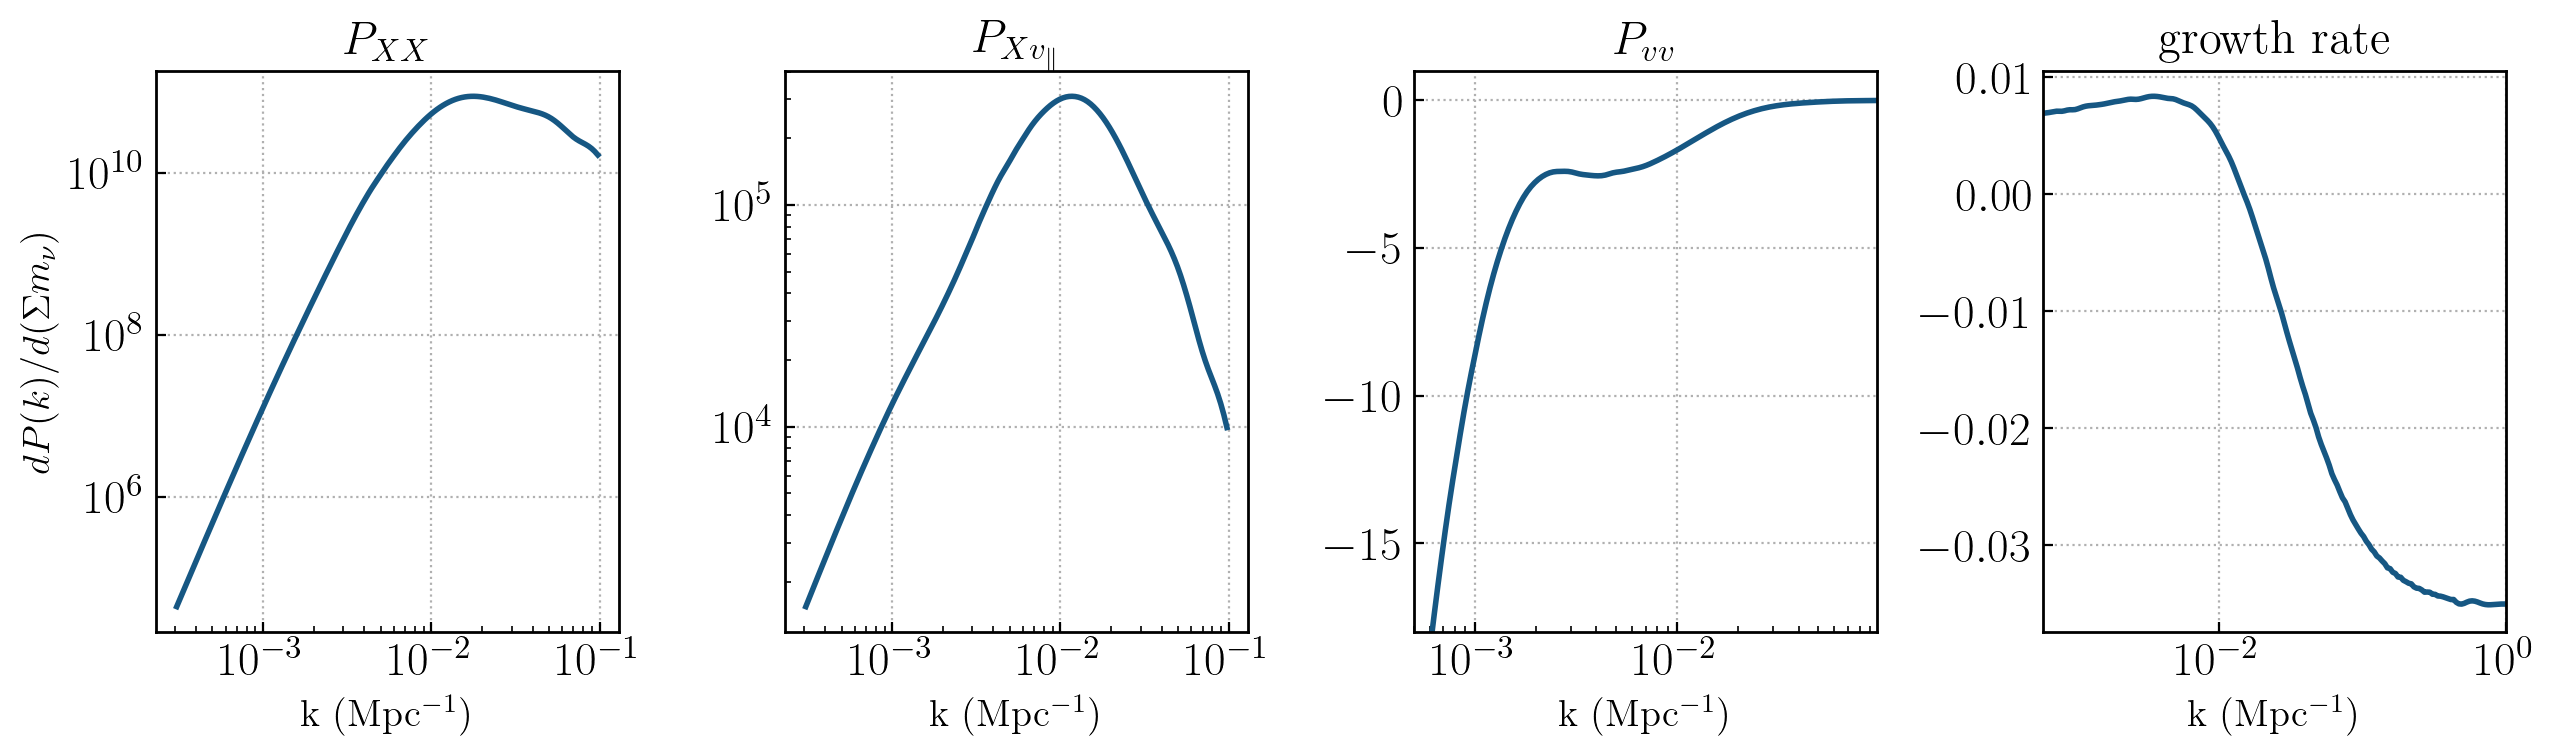

In [8]:
labels = [r'$\Sigma m_\nu$']

plt.figure(figsize=(13,4))
plt.subplot(1,4,1)
plt.loglog(k_large, abs(deriv_PXX[0,:]), color=palette[0], label='%s'%(labels[0]))

#plt.title('z = %g'%m.z)
plt.title(r'$P_{XX}$')
plt.xlabel('k (Mpc$^{-1}$)')
#plt.legend(ncol=3, handlelength=1, labelspacing=0,handletextpad=0.3, mode='expand')
plt.ylabel(r'$dP(k)/d (\Sigma m_\nu$)')
plt.grid(linestyle='dotted')

plt.subplot(1,4,2)
plt.loglog(k_large, abs(deriv_PvX_par[0,:]), color=palette[0])
plt.xlabel('k (Mpc$^{-1}$)')
plt.title(r'$P_{Xv_\parallel}$')
plt.grid(linestyle='dotted')

plt.subplot(1,4,3)
plt.semilogx(k_large, deriv_Pvv_par[0,:], color=palette[0])
plt.xlim(5e-4, k_large[-1].value)
plt.ylim(-18,1)
plt.title(r'$P_{vv}$')

plt.xlabel('k (Mpc$^{-1}$)')
plt.grid(linestyle='dotted')

plt.subplot(1,4,4)
plt.title(r'growth rate')
plt.semilogx(m.k, d_frowth)
#plt.xlim(k_large[0].value, k_large[-1].value)
plt.xlim(6e-4, 1e0)
plt.xlabel('k (Mpc$^{-1}$)')
plt.grid(linestyle='dotted')


plt.grid(linestyle='dotted')

plt.tight_layout()


#### Check $\sigma_N$ value as computed by the code
Here we set $T_{sys}$ to some fixed value to match, along with the other parameters, to the $\sigma_N$ value in Jose's paper (2012.00771)

In [9]:
m.nuObs

<Quantity 760.2156 GHz>

In [10]:
print('sigma_N / 1e5 = ')
m.sigma_N / 1e5
#((m.sigma_N**2/m.tpix).to(u.Jy**2/u.sr**2))**0.5 / 1e5


sigma_N / 1e5 = 


<Quantity 3.8971 Jy / sr>

In [11]:
print('White noise = ')
m.Pnoise

White noise = 


<Quantity 1.35047411e+09 Jy2 Mpc3 / sr2>

In [12]:
cosmo1 = dict(
         H0=67.67, cosmomc_theta=None,
         ombh2=0.022, omch2=0.12, omk=0.0, neutrino_hierarchy='degenerate',
         num_massive_neutrinos=1, mnu=0.06, nnu=3.046,
         YHe=None, meffsterile=0.0, standard_neutrino_neff=3.046,
         TCMB=2.7255, tau=0.06, deltazrei=None, bbn_predictor=None,
         theta_H0_range=[10, 100], w=-1.0, wa=0., cs2=1.0,
         dark_energy_model='ppf',As=2.2e-09,
         # !!! Planck 2018 eq. 16/17/18 arXiv:1807.06211
         ns=0.965, nrun=0.0, nrunrun=0.0,
         r=0.0, nt=None, ntrun=0.0,
         pivot_scalar=0.05, pivot_tensor=0.05,
         parameterization=2,halofit_version='mead')

cosmo2 = dict(
         H0=67.67, cosmomc_theta=None,
         ombh2=0.022, omch2=0.12, omk=0.0, neutrino_hierarchy='degenerate',
         num_massive_neutrinos=0, mnu=0., nnu=3.046,
         YHe=None, meffsterile=0.0, standard_neutrino_neff=3.046,
         TCMB=2.7255, tau=0.06, deltazrei=None, bbn_predictor=None,
         theta_H0_range=[10, 100], w=-1.0, wa=0., cs2=1.0,
         dark_energy_model='ppf',As=2.2e-09,
         # !!! Planck 2018 eq. 16/17/18 arXiv:1807.06211
         ns=0.965, nrun=0.0, nrunrun=0.0,
         r=0.0, nt=None, ntrun=0.0,
         pivot_scalar=0.05, pivot_tensor=0.05,
         parameterization=2,halofit_version='mead')



down = False
cosmo_model_params, obs_params = lim_params('CII',down)
cosmo_model_params['kmin'] = 1e-4*u.Mpc**-1
cosmo_model_params['kmax'] = 1e0*u.Mpc**-1
m = update_Pkline(obs_params,cosmo_model_params)[0]



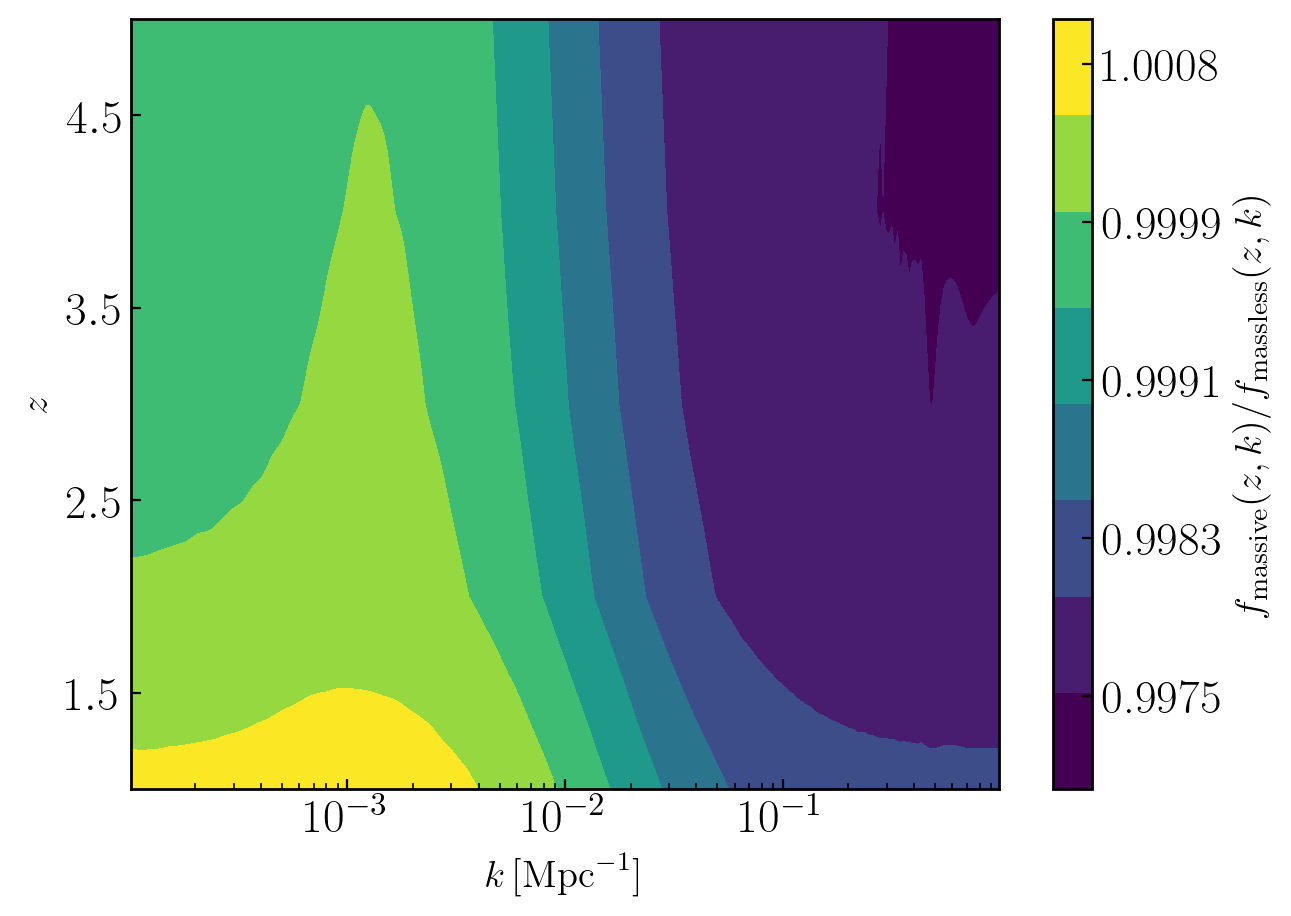

In [13]:
zs2 = np.linspace(1.,5.,5)

f_zk = np.zeros((len(zs2),len(m.k)))

for i in range(len(zs2)):
    cosmo_model_params['cosmo_input_camb'] = cosmo1
    nu, Dnu = Dnu_from_Dz(m.nu, zs2[i], 0.5)
    cosmo_model_params['nuObs'] = nu
    obs_params['Delta_nu'] = Dnu
    obs_params['dnu'] = (nu/R).to(u.MHz)
    m = update_Pkline(obs_params,cosmo_model_params)[0]
    f1 = m.f_eff[-1]    
    cosmo_model_params['cosmo_input_camb'] = cosmo2
    m = update_Pkline(obs_params,cosmo_model_params)[0]
    f2 = m.f_eff[-1]
    f_zk[i] = f1/f2

# Create a meshgrid for plotting
Z, K = np.meshgrid(zs2, m.k.value, indexing='ij')

# Plotting the 2D contour plot
plt.figure(figsize=(7, 5))
cp = plt.contourf(K, Z, f_zk, cmap='viridis', vmin=np.min(f_zk), vmax=np.max(f_zk))
cbar = plt.colorbar(cp, label=r'$f_\mathrm{massive}(z,k)/f_\mathrm{massless}(z,k)$')
# Set colorbar ticks
tick_values = np.linspace(f_zk.min(), f_zk.max(), num=5)  # Example: 5 ticks from min to max
cbar.set_ticks(tick_values)
cbar.set_ticklabels([f'{val:.4f}' for val in tick_values])  # Format tick labels

# Add y-axis ticks
y_ticks = np.arange(1.5,5.5,1)
plt.yticks(y_ticks)
plt.xscale('log')
plt.xlabel(r'$k\,[\mathrm{Mpc}^{-1}]$')
plt.ylabel(r'$z$')

plt.show()

# Functions

In [4]:
#%% Calculate the reconstructed noise N_vv
def Rec_noise(M, k_large, mu_L, Delta_T):
    Z = M.z
    nkS = 200
    nkL = len(k_large)
    nmu = len(mu_L)
    nz = 101
    k_fid = M.k
    #k_small = np.linspace(1,5,nkS)/u.Mpc # Mpc^-1
    k_small = np.logspace(-1, np.log10(5), nkS)/u.Mpc # Mpc^-1
    mu_S = -(k_large[np.newaxis,:,np.newaxis]*np.ones((nkS,nkL,nmu))/k_small[:,np.newaxis,np.newaxis]*np.ones((nkS,nkL,nmu))) * mu_L[np.newaxis,np.newaxis,:]*np.ones((nkS,nkL,nmu))
    Mh = np.logspace(8,15,200) # Msun
    zcosmo = np.linspace(0.,15.,nz)
    cosmo1 = (M.cosmo_input_camb).copy()
    cosmo1.pop('f_NL')
    camb_pars = camb.set_params(**cosmo1)
    camb_pars.set_matter_power(redshifts=list(zcosmo))
    cosmo = camb.get_results(camb_pars)
    H = lambda z: cosmo.hubble_parameter(z)/(cu.c.to(u.km/u.s)).value /u.Mpc # 1/Mpc    
    a = lambda z: 1/(1+z)
    T_CMB = ((camb_pars.TCMB* u.K).to(u.uK))#.value # muK
    chi_star = lambda z: cosmo.comoving_radial_distance(z)*u.Mpc # Mpc
    ell = lambda z,kS: chi_star(z) * kS
    
#     TT_total_for_S4 = np.loadtxt('/home/gali/Codes/kSZ coding/C_ells_kSZ_noise_Gabi.txt')
#     lvec = TT_total_for_S4[:,0]
#     Cl_TT = interp1d(lvec,TT_total_for_S4[:,1],bounds_error=False,fill_value=0.) # muK^2
    # kSZ
    xe = 1 # ionization fraction
    gasfrac = 0.9 # fraction of baryons in gas form, use default
    Yp = camb_pars.YHe # primordial He abundance
    ne0 = ksz.ne0_shaw(ombh2=M.cosmo_input_camb['ombh2'],gasfrac=gasfrac,Yp=Yp) # m^-3 # mean free electron density at z = 0
    Kstar = lambda z: -ksz.ksz_radial_function(z, camb_pars.ombh2, Yp) * u.uK/u.Mpc # muK / Mpc
    
    pxx = (M.Pk_onehalo + M.Pk_twohalo)[0] #Mpc^3 uK^2
    pxe = (M.Pke_onehalo + M.Pke_twohalo)[0] #Mpc^3 uK
    pxx_unit = pxx.unit
    pxe_unit = pxe.unit
    pxx_interp = interp1d(k_fid,pxx,bounds_error=False,fill_value='extrapolate')
    pxx_ksmall = pxx_interp(k_small)*pxx_unit #Mpc^3 uK^2 or Mpc^3 Jy^2/sr^2
    pxe_interp = interp1d(k_fid,pxe,bounds_error=False,fill_value='extrapolate')
    pxe_ksmall = pxe_interp(k_small)*pxe_unit #Mpc^3 uK or Mpc^3 Jy/sr
    kS_ind = np.argmin(np.abs(M.k - k_small[0]))
    fgrowth = M.f_eff[0,kS_ind]
    b_lim = (M.bavg)[0]
    T_lim = M.CLT
    T_mean = M.Tmean
    pshot_ksmall = (M.Pshot) * np.ones(pxx_ksmall.shape)
    pnoise_ksmall = (M.Pnoise) * np.ones(pxx_ksmall.shape)
    resize_ksmall = k_small[:,np.newaxis,np.newaxis]* np.ones((nkS,nkL,nmu))
    resize_pxx = pxx_ksmall[:,np.newaxis,np.newaxis]* np.ones((nkS,nkL,nmu))
    resize_ell_ksmall = chi_star(Z) * k_small[:,np.newaxis,np.newaxis]* np.ones((nkS,nkL,nmu))
    resize_pxe = pxe_ksmall[:,np.newaxis,np.newaxis]* np.ones((nkS,nkL,nmu))
    resize_pshot = pshot_ksmall[:,np.newaxis,np.newaxis]* np.ones((nkS,nkL,nmu))
    resize_pnoise = pnoise_ksmall[:,np.newaxis,np.newaxis]* np.ones((nkS,nkL,nmu))
    sig_par = M.sigma_par
    sig_perp = M.sigma_perp
    W_res = np.exp(-resize_ksmall**2*(sig_par**2*mu_S**2 + sig_perp**2*(1-mu_S**2)))
    kmin_par = 2*np.pi/M.Lfield
    kmin_perp = 2*np.pi/(M.Sfield)**0.5
    W_vol = (1.-np.exp(-(resize_ksmall/kmin_par)**2*mu_S**2))*(1.-np.exp(-(resize_ksmall/kmin_perp)**2*(1-mu_S**2)))
    W_ksmall = W_res * W_vol
    P_xx_ksmall = (1 + mu_S**2*fgrowth/b_lim)**2 * (resize_pxx) # Mpc^3
    P_xx_obs_ksmall = W_ksmall * (P_xx_ksmall + resize_pshot) + resize_pnoise # Mpc^3
    P_xe_ksmall = W_ksmall**0.5 * (1 + mu_S**2*fgrowth/b_lim) * (resize_pxe) # Mpc^3 -> with W(k)
    s = Delta_T *u.arcmin.to(u.radian)
    fwhm = 1.4 *u.arcmin.to(u.radian)
    N_ell=CMB_noise(resize_ell_ksmall, s, fwhm)
    Cltot_noise=(Cl_tot(resize_ell_ksmall)+N_ell)*u.uK**2
    itgrnd = resize_ksmall * (P_xe_ksmall**2 / P_xx_obs_ksmall) / Cltot_noise # Mpc^-1 muK^-2
    mask = np.isinf(itgrnd)
    itgrnd[mask] = 0.
    integral = np.trapz(itgrnd, x=k_small, axis=0) # Mpc / muK^2
    Nvv_par = (chi_star(Z)/ Kstar(Z))**2 * 2*np.pi / integral # Mpc^3
    N_vv = (mu_L[np.newaxis,:]*np.ones((nkL,nmu)))**-2 * Nvv_par
    
    #Nmm = k_large**2/(fgrowth*a(Z)*H(Z))**2 * N_vv[:,-1]
    
    # get potential Pk (non linearities included) - CAMB results is already multiplied by k^4
    interp_Pphiphi = camb.get_matter_power_interpolator(camb_pars, zmin=0, zmax=zcosmo[-1], nz_step=150, zs=None, kmax=max(k_small.value), nonlinear=True,var1=camb.model.Transfer_Weyl, var2=camb.model.Transfer_Weyl, hubble_units=False, 
                                                        k_hunit=False, return_z_k=False, k_per_logint=None, log_interp=False,  extrap_kmax=True).P  # Mpc^-1
    omegam = (camb_pars.ombh2 + camb_pars.omch2 + camb_pars.omnuh2) / (camb_pars.H0 / 100) ** 2
    rhoM0 = 3*omegam*H(0.)**2 # Mpc^-2
    # potential Pk , change of units
    use_Pphiphi_ksmall = (interp_Pphiphi(Z,k_small.value)/u.Mpc/k_small**4)[:,np.newaxis,np.newaxis]*np.ones((nkS,nkL,nmu)) # Mpc^3
    # noise on the potential
    noise_pot = ((1+Z)*rhoM0/2)**2/((resize_ksmall)**4 * (b_lim*T_mean)**2)*(pnoise_ksmall+pshot_ksmall*W_ksmall)  # Mpc^3
    # observed potential
    use_Ppot_ob = use_Pphiphi_ksmall + noise_pot # Mpc^3
    itgrnd_ML = (resize_ksmall)**3 * (use_Pphiphi_ksmall**2 / use_Ppot_ob) / Cltot_noise # muK^-2
    mask = np.isinf(itgrnd_ML)
    itgrnd_ML[mask] = 0
    integral_ML = np.trapz(itgrnd_ML, x=k_small, axis=0) # 1 / Mpc / muK^2
    new_resize_muL = mu_L[np.newaxis,:]*np.ones((nkL,nmu))
    new_resize_kL = k_large[:,np.newaxis]*np.ones((nkL,nmu))
    # noise on the transverse velocity potential (T_CMB factor to cancel the uK units from Cls)
    N_perp_Vpot = (chi_star(Z) / (T_CMB_uK*new_resize_kL*np.sqrt(1-new_resize_muL**2)))**2 * 2*np.pi / 2 / integral_ML # Mpc
    Nvv_perp = (new_resize_kL)**2 * N_perp_Vpot # v = grad pot so in Fourier you get v = k*pot
    N_vv_ML = (np.sqrt(1-new_resize_muL**2))**-2 * Nvv_perp # Mpc^3
    
    #Nvv_par = 7e-1*np.ones((nkL,nmu))*u.Mpc**3
    
    return Nvv_par, Nvv_perp
    

#%% Calculate power spectra
def get_powers(M, k_large):
    k = M.k
    pk_line = M.Pk.T
    pk_line_velocity_par = M.Pkv_par.T
    pk_line_velocity_perp = M.Pkv_perp.T
    pk_velocity_par = M.Pvv_par.T
    pk_velocity_perp = M.Pvv_perp.T
    pk_velocity_par_perp = M.Pvv_par_perp.T

    P_XX = pk_line[np.abs(k - k_large[0]).argmin():np.abs(k - k_large[-1]).argmin()+1,]
    P_Xv_par = pk_line_velocity_par[np.abs(k - k_large[0]).argmin():np.abs(k - k_large[-1]).argmin()+1,]
    P_Xv_perp = pk_line_velocity_perp[np.abs(k - k_large[0]).argmin():np.abs(k - k_large[-1]).argmin()+1,]
    P_vv_par = pk_velocity_par[np.abs(k - k_large[0]).argmin():np.abs(k - k_large[-1]).argmin()+1,]
    P_vv_perp = pk_velocity_perp[np.abs(k - k_large[0]).argmin():np.abs(k - k_large[-1]).argmin()+1,]
    P_vv_par_perp = pk_velocity_par_perp[np.abs(k - k_large[0]).argmin():np.abs(k - k_large[-1]).argmin()+1,]

    return P_XX, P_Xv_par, P_Xv_perp, P_vv_par, P_vv_perp, P_vv_par_perp

#%% Calculate noise power spectra
def get_noises(M, k_large, Delta_T):
    nkS = 300
    nkL = len(k_large)
    nz = 101    
    nmu = M.nmu
    Wk = M.Wk.T[np.abs(M.k - k_large[0]).argmin():np.abs(M.k - k_large[-1]).argmin()+1,]
    N_XX = M.Pnoise * np.ones((nkL,nmu)) # / Wk
    Nvv_par, Nvv_perp = Rec_noise(M, k_large, M.mu, Delta_T)
    
    return N_XX, Nvv_par, Nvv_perp



#%% Calculate derivatives of power spectra
def derivs(M, cosmo0, bias0, free_params, deltas, k_large):
    nmu = M.nmu
    nk = len(k_large)
    d_PXX = np.zeros((len(free_params), nk, nmu))
    d_PXv_par = np.zeros((len(free_params), nk, nmu))
    d_PXv_perp = np.zeros((len(free_params), nk, nmu))
    d_Pvv_par = np.zeros((len(free_params), nk, nmu))
    d_Pvv_perp = np.zeros((len(free_params), nk, nmu))
    d_Pvv_par_perp = np.zeros((len(free_params), nk, nmu))
    param_values = np.zeros(len(free_params))
    for free_param_ind, free_param in enumerate(free_params):
        if free_param in cosmo0:
            param_values[free_param_ind] = cosmo0[free_param]
        elif free_param in bias0:
            param_values[free_param_ind] = bias0[free_param]
        else:
            raise KeyError(f"{free_param} is not a valid parameters for this code!")
    for i, param in enumerate(free_params):
        delta = deltas[i]
        param_value = param_values[i]
        cosmo_model_params['bv_par'] = bias0['bv_par']
        cosmo_model_params['bv_perp'] = bias0['bv_perp']
        cosmo_model_params['bT_up'] = False
        cosmo_model_params['bT_down'] = False
        if param in cosmo0:
            cosmo_p = cosmo0.copy()
            cosmo_n = cosmo0.copy()
            if not cosmo0[param] == 0.:
                cosmo_p[param] = cosmo0[param]*(1.+delta)
                cosmo_n[param] = cosmo0[param]*(1.-delta)
            else:
                cosmo_p[param] = delta
                cosmo_n[param] = -delta
            print('\n\nNow simulating for (1+delta)'+param+
                  f', this is parameter #{i+1} (out of {len(free_params)})')
            cosmo_model_params['cosmo_input_camb'] = cosmo_p
            M = update_Pkline(obs_params,cosmo_model_params)[0]
            PXX_p, PXv_par_p, PXv_perp_p, Pvv_par_p, Pvv_perp_p, Pvv_par_perp_p = get_powers(M, k_large)
            print('\n\nNow simulating for (1-delta)'+param+
                  f', this is parameter #{i+1} (out of {len(free_params)})')
            cosmo_model_params['cosmo_input_camb'] = cosmo_n
            M = update_Pkline(obs_params,cosmo_model_params)[0]
            PXX_n, PXv_par_n, PXv_perp_n, Pvv_par_n, Pvv_perp_n, Pvv_par_perp_n = get_powers(M, k_large)
        else:
            bias_p = bias0.copy()
            bias_n = bias0.copy()
            if not bias0[param] == 0.:
                bias_p[param] = bias0[param]*(1.+delta)
                bias_n[param] = bias0[param]*(1.-delta)
            else:
                bias_p[param] = delta
                bias_n[param] = -delta
            print('\n\nNow simulating for (1+delta)'+param+
                  f', this is parameter #{i+1} (out of {len(free_params)})')
            cosmo_model_params['cosmo_input_camb'] = cosmo0
            if param=='bT':
                cosmo_model_params['bT_up'] = True
            else:
                cosmo_model_params[param] = bias_p[param]
            M = update_Pkline(obs_params,cosmo_model_params)[0]
            PXX_p, PXv_par_p, PXv_perp_p, Pvv_par_p, Pvv_perp_p, Pvv_par_perp_p = get_powers(M, k_large)
            print('\n\nNow simulating for (1-delta)'+param+
                  f', this is parameter #{i+1} (out of {len(free_params)})')
            cosmo_model_params['cosmo_input_camb'] = cosmo0
            if param=='bT':
                cosmo_model_params['bT_up'] = False
                cosmo_model_params['bT_down'] = True
            else:
                cosmo_model_params[param] = bias_n[param]
            M = update_Pkline(obs_params,cosmo_model_params)[0]
            PXX_n, PXv_par_n, PXv_perp_n, Pvv_par_n, Pvv_perp_n, Pvv_par_perp_n = get_powers(M, k_large)
        if not param_value == 0.:
            d_PXX[i] = (PXX_p - PXX_n)/(2*param_value*delta)
            d_PXv_par[i] = (PXv_par_p - PXv_par_n)/(2*param_value*delta)
            d_PXv_perp[i] = (PXv_perp_p - PXv_perp_n)/(2*param_value*delta)
            d_Pvv_par[i] = (Pvv_par_p - Pvv_par_n)/(2*param_value*delta)
            d_Pvv_perp[i] = (Pvv_perp_p - Pvv_perp_n)/(2*param_value*delta)
            d_Pvv_par_perp[i] = (Pvv_par_perp_p - Pvv_par_perp_n)/(2*param_value*delta)
        else:
            d_PXX[i] = (PXX_p - PXX_n)/(2*delta)
            d_PXv_par[i] = (PXv_par_p - PXv_par_n)/(2*delta)
            d_PXv_perp[i] = (PXv_perp_p - PXv_perp_n)/(2*delta)
            d_Pvv_par[i] = (Pvv_par_p - Pvv_par_n)/(2*delta)
            d_Pvv_perp[i] = (Pvv_perp_p - Pvv_perp_n)/(2*delta)
            d_Pvv_par_perp[i] = (Pvv_par_perp_p - Pvv_par_perp_n)/(2*delta)
    return d_PXX, d_PXv_par, d_PXv_perp, d_Pvv_par, d_Pvv_perp, d_Pvv_par_perp
             
    
    
def Fisher_mat(M, cosmo0, bias0, free_params, deltas, k, vol, Delta_T):
    mu = M.mu
    k_grid=np.meshgrid(mu, k)[1]
    #Wk = M.Wk.T[np.abs(M.k - k[0]).argmin():np.abs(M.k - k[-1]).argmin()+1,]
    PXX, PXv_par, PXv_perp, Pvv_par, Pvv_perp, Pvv_par_perp = get_powers(M, k)
    cosmo_model_params['do_onehalo'] = True
    M = update_Pkline(obs_params,cosmo_model_params)[0]
    NXX, Nvv_par, Nvv_perp = get_noises(M, k, Delta_T)
    cosmo_model_params['do_onehalo'] = False
    M = update_Pkline(obs_params,cosmo_model_params)[0]
    d_PXX, d_PXv_par, d_PXv_perp, d_Pvv_par, d_Pvv_perp, d_Pvv_par_perp = derivs(M, cosmo0, bias0, free_params, deltas, k)
    #PXX = Wk * PXX2; PXv_par = Wk**0.5 * PXv_par2; PXv_perp = Wk**0.5 * PXv_perp2
    #d_PXX = Wk * d_PXX2; d_PXv_par = Wk**0.5 * d_PXv_par2; d_PXv_perp = Wk**0.5 * d_PXv_perp2
    S=np.zeros((len(k),len(mu),4,4))
    S[:,:,0,0]=Pvv_par; S[:,:,0,1]=Pvv_par_perp; S[:,:,1,0]=Pvv_par_perp; S[:,:,1,1]=Pvv_perp;
    S[:,:,0,3]=PXv_par; S[:,:,3,0]=PXv_par; S[:,:,1,3]=PXv_perp; S[:,:,3,1]=PXv_perp; S[:,:,3,3]=PXX;
    N=np.zeros((len(k),len(mu),4,4))
    N[:,:,0,0]=Nvv_par; N[:,:,1,1]=Nvv_perp; N[:,:,2,2]=Nvv_perp; N[:,:,3,3]=NXX;
    C = S+N
    C_inv = np.linalg.inv(C)
    F_XX=np.zeros((len(free_params), len(free_params)))
    F_Xv=np.zeros((len(free_params), len(free_params)))
    for a in range(len(free_params)):
        d_PXX_a=d_PXX[a,:,:]; d_PXv_par_a=d_PXv_par[a,:,:]; d_PXv_perp_a=d_PXv_perp[a,:,:]
        d_Pvv_par_a=d_Pvv_par[a,:,:]; d_Pvv_perp_a=d_Pvv_perp[a,:,:]; d_Pvv_par_perp_a=d_Pvv_par_perp[a,:,:]
        for b in range(len(free_params)):
            d_PXX_b=d_PXX[b,:,:]; d_PXv_par_b=d_PXv_par[b,:,:]; d_PXv_perp_b=d_PXv_perp[b,:,:]
            d_Pvv_par_b=d_Pvv_par[b,:,:]; d_Pvv_perp_b=d_Pvv_perp[b,:,:]; d_Pvv_par_perp_b=d_Pvv_par_perp[b,:,:]
            
            dC_a=np.zeros((len(k),len(mu),4,4))
            dC_a[:,:,0,0]=d_Pvv_par_a; dC_a[:,:,0,1]=d_Pvv_par_perp_a; dC_a[:,:,1,0]=d_Pvv_par_perp_a; dC_a[:,:,1,1]=d_Pvv_perp_a;
            dC_a[:,:,0,3]=d_PXv_par_a; dC_a[:,:,3,0]=d_PXv_par_a; dC_a[:,:,1,3]=d_PXv_perp_a; dC_a[:,:,3,1]=d_PXv_perp_a; dC_a[:,:,3,3]=d_PXX_a;
            dC_b=np.zeros((len(k),len(mu),4,4))
            dC_b[:,:,0,0]=d_Pvv_par_b; dC_b[:,:,0,1]=d_Pvv_par_perp_b; dC_b[:,:,1,0]=d_Pvv_par_perp_b; dC_b[:,:,1,1]=d_Pvv_perp_b;
            dC_b[:,:,0,3]=d_PXv_par_b; dC_b[:,:,3,0]=d_PXv_par_b; dC_b[:,:,1,3]=d_PXv_perp_b; dC_b[:,:,3,1]=d_PXv_perp_b; dC_b[:,:,3,3]=d_PXX_b;
    
            int_F_Xv=vol.value*((k_grid**2)/(8.*(np.pi**2)))*(np.trace(np.matmul(dC_a, np.matmul(C_inv, np.matmul(dC_b, C_inv))), axis1=2, axis2=3))
            #int_F_hv=vol.value*((k_grid**2)/(8.*(np.pi**2)))*(np.trace(np.matmul(C_inv, np.matmul(dC_a, np.matmul(C_inv, dC_b))), axis1=2, axis2=3))
            F_Xv[a,b]=integrate.simps(integrate.simps(int_F_Xv, mu, axis=1), k)
            F_Xv[b,a]=F_Xv[a,b]
            
            int_F_XX=vol.value*((k_grid**2)/(8.*(np.pi**2)))*(d_PXX_a*d_PXX_b)*((1./(PXX+NXX))**2)
            F_XX[a,b]=integrate.simps(integrate.simps(int_F_XX, mu, axis=1), k)
            F_XX[b,a]=F_XX[a,b]
    
    return F_XX, F_Xv



#%% Calculate the covariance matrix, including fixing
def covariance_mat(F,
                   free_params,
                   fixed_params,
                   priors):
    F1 = np.copy(F)
    # Add priors to the Fisher matrix
    sigma_priors = np.inf*np.ones(len(free_params))
    for prior in priors:
        sigma_priors[free_params.index(prior)] = priors[prior]
    F1 += np.diag(1./sigma_priors**2.)
    # Find the fixed parameters indices within the free parameters list
    fixed_inds = []
    if len(fixed_params)>0:
        for i in range(len(fixed_params)):
            for j in range(len(free_params)):
                if fixed_params[i] == free_params[j]:
                    fixed_inds.append(j)
    # Omit the fixed parameters from the Fisher matrix
    F1 = np.delete(F1,fixed_inds,0)
    F1 = np.delete(F1,fixed_inds,1)
    # Keep only the remaining free parameters (that weren't fixed)
    cov_inds = [ind for ind in np.arange(len(free_params)) if ind not in fixed_inds]
    cov_params = [free_params[i] for i in cov_inds]
    # Calculate the covariance matrix
    cov_mat = np.linalg.inv(F1)
    # Return covariance matrix and its corresponding parameters
    return cov_mat, cov_params


#%% Print the 1-sigmas of the parameters
def print_1_sigmas(cov_mat,
                   cov_params):
    print('\n')
    sigmas = {}
    for ind, param in enumerate(cov_params):
        sigmas[param] = np.sqrt(cov_mat[ind,ind])
        print('1-sigma of '+param+f' is {sigmas[param]}')
    
    
#%% Define latex names for Fisher plot
def latex_gen(parameters_list):
    names_list = []
    for element in parameters_list:
        if element == 'h':
            names_list.append('h')
        elif element == 'Omb' or element == 'ombh2' :
            names_list.append('\\Omega_b')
        elif element == 'Omc' or element == 'omch2':
            names_list.append('\\Omega_m')
        elif element == 'As':
            names_list.append('A_s')
        elif element == 'ns':
            names_list.append('n_s')
        elif element == 'tau':
            names_list.append('\\tau')
        elif element == 'H0':
            names_list.append('H_0')
        elif element == 'bv':
            names_list.append('b_v')
        elif element == 'mnu':
            names_list.append('\\Sigma m_\\nu')
        elif element == 'f_NL':
            names_list.append('f_{NL}')
        elif element == 'Acip':
            names_list.append('A_{CIP}')
    return(names_list)


In [4]:

#%% Calculate analytic derivatives of power spectra
def analytic_derivs(M, cosmo0, bias0, free_params, deltas, k_large):
    nmu = M.nmu
    nk = len(k_large)
    d_PXX = np.zeros((len(free_params), nk, nmu))
    d_PXv_par = np.zeros((len(free_params), nk, nmu))
    d_PXv_perp = np.zeros((len(free_params), nk, nmu))
    d_Pvv_par = np.zeros((len(free_params), nk, nmu))
    d_Pvv_perp = np.zeros((len(free_params), nk, nmu))
    d_Pvv_par_perp = np.zeros((len(free_params), nk, nmu))
    param_values = np.zeros(len(free_params))
    for free_param_ind, free_param in enumerate(free_params):
        if free_param in cosmo0:
            param_values[free_param_ind] = cosmo0[free_param]
        elif free_param in bias0:
            param_values[free_param_ind] = bias0[free_param]
        else:
            raise KeyError(f"{free_param} is not a valid parameters for this code!")
    for i, param in enumerate(free_params):
        delta = deltas[i]
        param_value = param_values[i]
        cosmo_model_params['bv_par'] = bias0['bv_par']
        cosmo_model_params['bv_perp'] = bias0['bv_perp']
        cosmo_model_params['bT_up'] = False
        cosmo_model_params['bT_down'] = False
        if param in cosmo0:
            cosmo_p = cosmo0.copy()
            cosmo_n = cosmo0.copy()
            if not cosmo0[param] == 0.:
                cosmo_p[param] = cosmo0[param]*(1.+delta)
                cosmo_n[param] = cosmo0[param]*(1.-delta)
            else:
                cosmo_p[param] = delta
                cosmo_n[param] = -delta
            print('\n\nNow simulating for (1+delta)'+param+
                  f', this is parameter #{i+1} (out of {len(free_params)})')
            cosmo_model_params['cosmo_input_camb'] = cosmo_p
            M = update_Pkline(obs_params,cosmo_model_params)[0]
            PXX_p, PXv_par_p, PXv_perp_p, Pvv_par_p, Pvv_perp_p, Pvv_par_perp_p = get_powers(M, k_large)
            print('\n\nNow simulating for (1-delta)'+param+
                  f', this is parameter #{i+1} (out of {len(free_params)})')
            cosmo_model_params['cosmo_input_camb'] = cosmo_n
            M = update_Pkline(obs_params,cosmo_model_params)[0]
            PXX_n, PXv_par_n, PXv_perp_n, Pvv_par_n, Pvv_perp_n, Pvv_par_perp_n = get_powers(M, k_large)
            if not param_value == 0.:
                d_PXX[i] = (PXX_p - PXX_n)/(2*param_value*delta)
                d_PXv_par[i] = (PXv_par_p - PXv_par_n)/(2*param_value*delta)
                d_PXv_perp[i] = (PXv_perp_p - PXv_perp_n)/(2*param_value*delta)
                d_Pvv_par[i] = (Pvv_par_p - Pvv_par_n)/(2*param_value*delta)
                d_Pvv_perp[i] = (Pvv_perp_p - Pvv_perp_n)/(2*param_value*delta)
                d_Pvv_par_perp[i] = (Pvv_par_perp_p - Pvv_par_perp_n)/(2*param_value*delta)
            else:
                d_PXX[i] = (PXX_p - PXX_n)/(2*delta)
                d_PXv_par[i] = (PXv_par_p - PXv_par_n)/(2*delta)
                d_PXv_perp[i] = (PXv_perp_p - PXv_perp_n)/(2*delta)
                d_Pvv_par[i] = (Pvv_par_p - Pvv_par_n)/(2*delta)
                d_Pvv_perp[i] = (Pvv_perp_p - Pvv_perp_n)/(2*delta)
                d_Pvv_par_perp[i] = (Pvv_par_perp_p - Pvv_par_perp_n)/(2*delta)
        else:
            cosmo_model_params['cosmo_input_camb'] = cosmo0
            M = update_Pkline(obs_params,cosmo_model_params)[0]
            PXX, PXv_par, PXv_perp, Pvv_par, Pvv_perp, Pvv_par_perp = get_powers(M, k_large)
            if param=='bT':
                RSD = M.RSD.T[np.abs(M.k - k_large[0]).argmin():np.abs(M.k - k_large[-1]).argmin()+1,]
                Pm = M.Pm.T[np.abs(M.k - k_large[0]).argmin():np.abs(M.k - k_large[-1]).argmin()+1,]
                Wk = M.Wk.T[np.abs(M.k - k_large[0]).argmin():np.abs(M.k - k_large[-1]).argmin()+1,]
                b_v_par = M.b_v_par.T[np.abs(M.k - k_large[0]).argmin():np.abs(M.k - k_large[-1]).argmin()+1,]
                b_v_perp = M.b_v_perp.T[np.abs(M.k - k_large[0]).argmin():np.abs(M.k - k_large[-1]).argmin()+1,]
                d_PXX[i] = 2*bias0['bT']*RSD*Pm*Wk
                d_PXv_par[i] = b_v_par*RSD**0.5*Pm*Wk**0.5
                d_PXv_perp[i] = b_v_perp*RSD**0.5*Pm*Wk**0.5
                d_Pvv_par[i] = np.zeros((nk, nmu))
                d_Pvv_perp[i] = np.zeros((nk, nmu))
                d_Pvv_par_perp[i] = np.zeros((nk, nmu))
            elif param=='bv_par':
                d_PXX[i] = np.zeros((nk, nmu))
                d_PXv_par[i] = PXv_par
                d_PXv_perp[i] = np.zeros((nk, nmu))
                d_Pvv_par[i] = 2*Pvv_par
                d_Pvv_perp[i] = np.zeros((nk, nmu))
                d_Pvv_par_perp[i] = Pvv_par_perp
            elif param=='bv_perp':
                d_PXX[i] = np.zeros((nk, nmu))
                d_PXv_par[i] = np.zeros((nk, nmu))
                d_PXv_perp[i] = PXv_perp
                d_Pvv_par[i] = np.zeros((nk, nmu))
                d_Pvv_perp[i] = 2*Pvv_perp
                d_Pvv_par_perp[i] = Pvv_par_perp
                    
        
    return d_PXX, d_PXv_par, d_PXv_perp, d_Pvv_par, d_Pvv_perp, d_Pvv_par_perp
             
    

### Insert here the CMB+BAO Fisher matrix used in the analysis

In [5]:
fisher_root = '/media/HostShared/Fisher matrices/'
F_planck_lowell = np.loadtxt(fisher_root+'Fisher_planck_lowell')
F_bao = np.loadtxt(fisher_root+'Fisher_desi_bao')

import pickle

#with open(fisher_root+'fisher_8p_varyDT_theta14.pkl', "rb") as f:
with open(fisher_root+'fisher_8p_S4.pkl', "rb") as f:

    F_CMB_DT = pickle.load(f)
    
F_CMB_DT


{'cmbNoiseSpectra': {0: {'l': array([   2,    3,    4, ..., 8498, 8499, 8500]),
   'cl_TT': array([1.65847292e-07, 1.65847321e-07, 1.65847361e-07, ...,
          1.43825370e-06, 1.43898507e-06, 1.43971689e-06]),
   'cl_EE': array([3.31694583e-07, 3.31694643e-07, 3.31694722e-07, ...,
          2.87650740e-06, 2.87797013e-06, 2.87943379e-06]),
   'cl_TE': array([0., 0., 0., ..., 0., 0., 0.]),
   'cl_BB': array([3.31694583e-07, 3.31694643e-07, 3.31694722e-07, ...,
          2.87650740e-06, 2.87797013e-06, 2.87943379e-06]),
   'dl_TT': array([1.58372498e-07, 3.16745052e-07, 5.27908546e-07, ...,
          1.65325630e+01, 1.65448629e+01, 1.65571725e+01]),
   'dl_EE': array([3.16744995e-07, 6.33490104e-07, 1.05581709e-06, ...,
          3.30651260e+01, 3.30897259e+01, 3.31143451e+01]),
   'dl_TE': array([0., 0., 0., ..., 0., 0., 0.]),
   'dl_BB': array([3.16744995e-07, 6.33490104e-07, 1.05581709e-06, ...,
          3.30651260e+01, 3.30897259e+01, 3.31143451e+01])}},
 'powersFid': {0: {'unlens

In [6]:
fsky=0.4
F_S4 = F_CMB_DT['fisherGaussian'][0]['lensed']*fsky
F_S4 = np.delete(F_S4, -1, axis=0)
F_S4 = np.delete(F_S4, -1, axis=1)
F_bao_CMB = F_bao + F_planck_lowell + F_S4

free_params2 = ['H0','ombh2','omch2','ns','As','tau','mnu']
cov, covp = covariance_mat(F_bao_CMB, free_params2, [], {})#{'tau':0.01})
print_1_sigmas(cov,covp)




1-sigma of H0 is 0.23743819001822128
1-sigma of ombh2 is 2.9755013936899864e-05
1-sigma of omch2 is 0.0006202468896810857
1-sigma of ns is 0.0021416703088988453
1-sigma of As is 4.300607508764283e-11
1-sigma of tau is 0.010748234050895228
1-sigma of mnu is 0.03799981310467601


# CMB power spectrum - late time kSZ + noise

In [7]:
#Primary CMB
T_CMB=2.7260 #K
T_CMB_uK=T_CMB*1e6
ell_max_CMB = 10000
m.camb_pars.set_for_lmax(ell_max_CMB, lens_potential_accuracy=0)
m.camb_pars.Reion.set_tau(0.056)
powers =m.cosmo.get_cmb_power_spectra(m.camb_pars, CMB_unit='muK', raw_cl=True)
cl_TT_camb=powers['unlensed_scalar'][:,0]
ls = np.arange(cl_TT_camb.shape[0])
cl_TT=interp1d(ls, cl_TT_camb, fill_value='extrapolate')

kSZ_outroot = '/home/gali/Codes/kSZ coding/output/'
output = np.loadtxt(kSZ_outroot+'kSZ_PS_kSZ_Cells.txt')
ls_kSZ2 = output[:,0]
ClTT_kSZ = output[:,1] * T_CMB_uK**2

ls_kSZ=np.logspace(3, 6, 1000)
Cl_kSZ=interp1d(ls_kSZ2, ClTT_kSZ, fill_value='extrapolate')

ls_tot = np.arange(0, 1e6)
cl_TT_tot = np.zeros((len(ls_tot)))
cl_TT_tot[:len(ls)] = cl_TT(ls)

Cl_tot=interp1d(ls_tot, (cl_TT_tot+Cl_kSZ(ls_tot)), fill_value='extrapolate')

def CMB_noise(ell, s, th_FWHM):
    return s**2*np.exp((ell*(ell+1)*(th_FWHM**2))/(8*np.log(2)))

### First entry is for SO, second for CMB-S4
theta_FWHM = np.array([1.4, 1.4]) *u.arcmin.to(u.radian)
s = np.array([6.,  1.4])*u.arcmin.to(u.radian) #in micro-Kelvin
#sigma_b = theta_FWHM*u.arcmin.to(u.radian)
N_exp = len(s)
noise_TT = np.zeros([N_exp,len(ls_tot)])
for j in range(N_exp):
    noise_TT[j] = CMB_noise(ls_tot, s[j], theta_FWHM[j])


Note: redshifts have been re-sorted (earliest first)


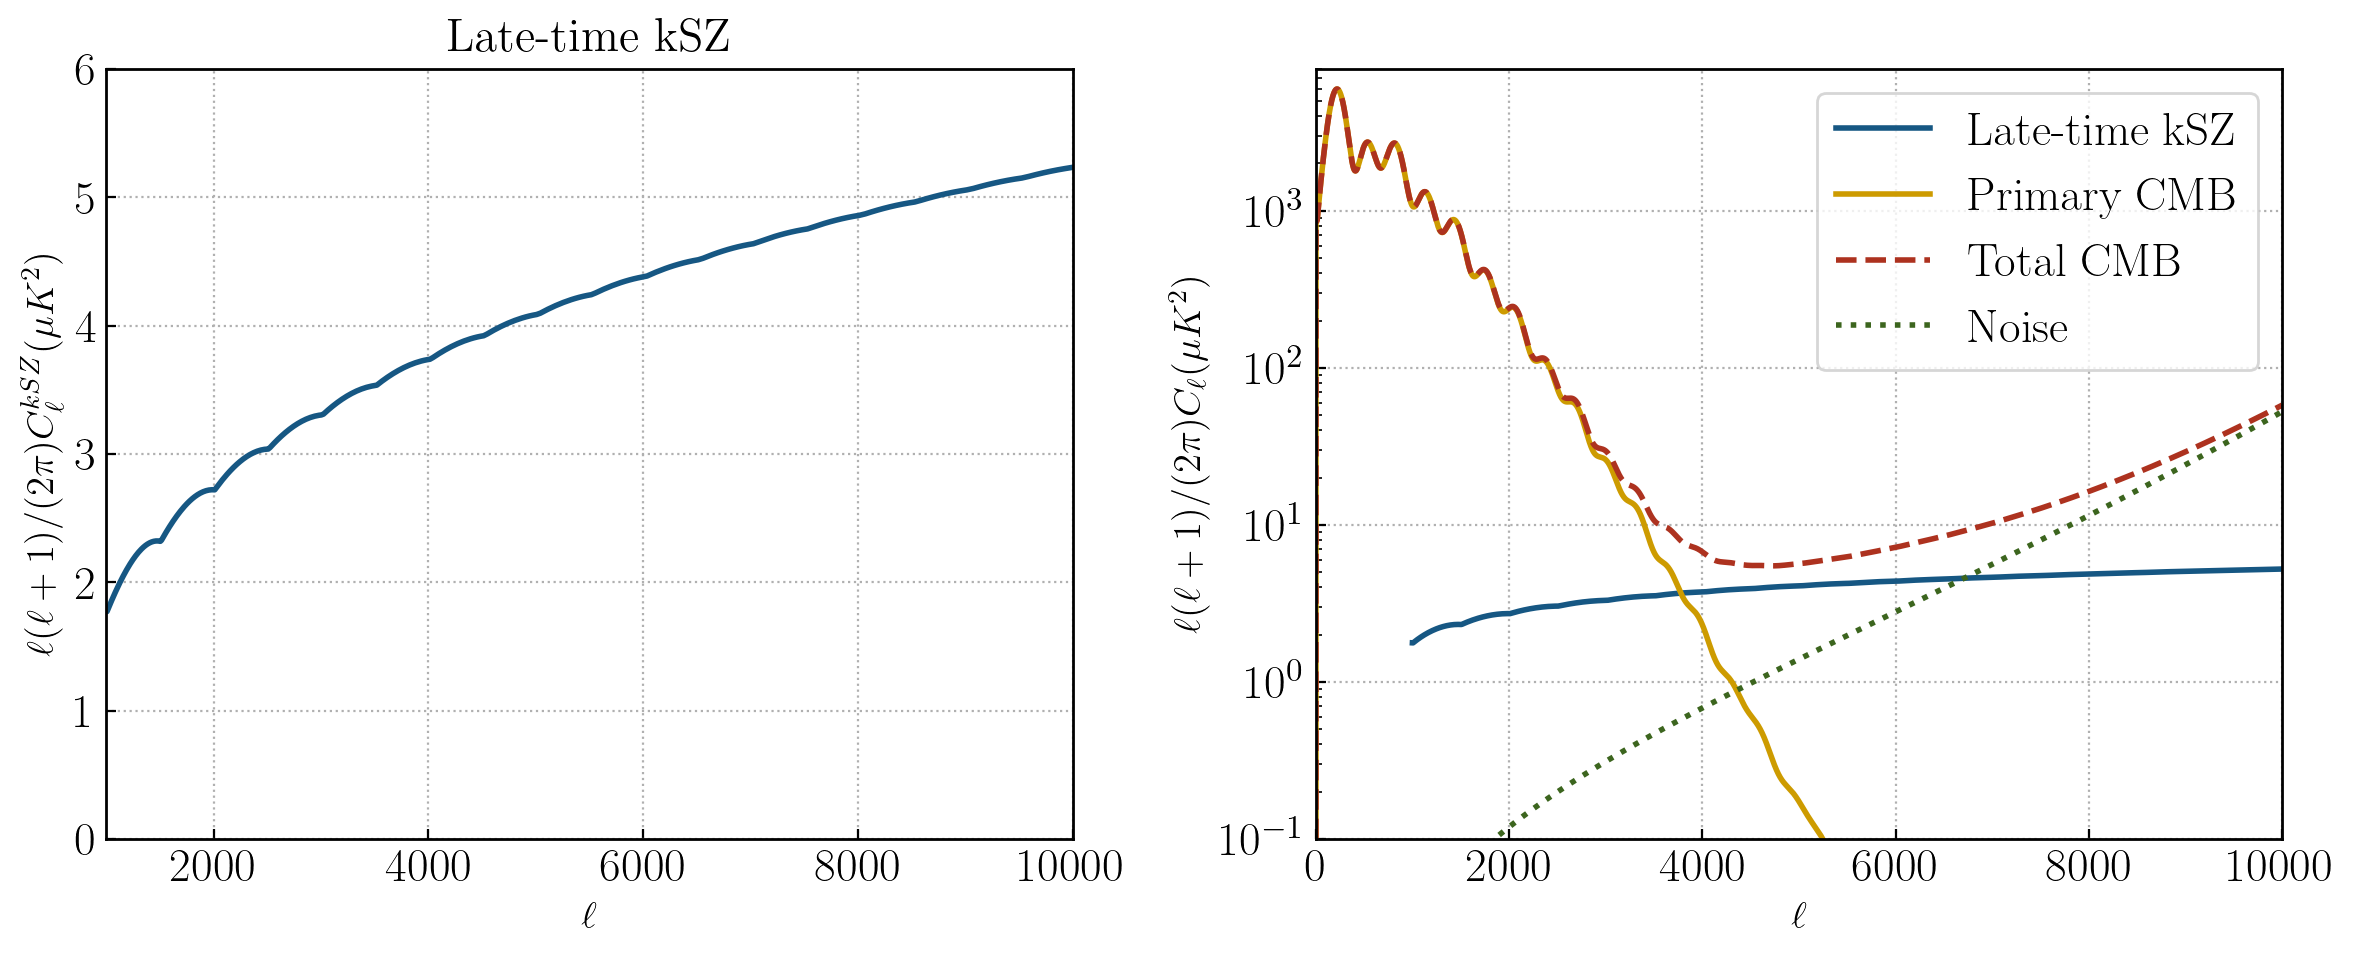

In [8]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(ls_kSZ, Cl_kSZ(ls_kSZ)*(ls_kSZ*(ls_kSZ+1))/(2.*np.pi))
plt.ylabel('$\ell(\ell +1)/(2\pi) C^{kSZ}_{\ell} (\mu K^2)$')
plt.xlabel('$\ell$')
plt.xlim(1000, 10000)
plt.ylim(0,6)
plt.title('Late-time kSZ')
plt.grid(linestyle='dotted')

plt.subplot(1,2,2)
plt.plot(ls_kSZ, Cl_kSZ(ls_kSZ)*(ls_kSZ*(ls_kSZ+1))/(2.*np.pi), label='Late-time kSZ')
plt.plot(ls[1:], cl_TT(ls[1:])*(ls[1:]*(ls[1:]+1))/(2*np.pi), label='Primary CMB')
plt.plot(ls_tot, Cl_tot(ls_tot)*(ls_tot*(ls_tot+1))/(2.*np.pi)+noise_TT[1]*(ls_tot*(ls_tot+1))/(2.*np.pi), '--', label='Total CMB')
plt.plot(ls_tot, noise_TT[1]*(ls_tot*(ls_tot+1))/(2.*np.pi), ':', label='Noise')

plt.xlim(0, 10000)
plt.ylim(1e-1, 8e3)
plt.yscale('log')
plt.ylabel('$\ell(\ell +1)/(2\pi) C_{\ell} (\mu K^2)$')
plt.xlabel('$\ell$')
plt.legend(loc='upper right')
plt.grid(linestyle='dotted')
plt.tight_layout()

# Line Intensity Mapping

In [9]:
cosmo_params = dict(
         H0=67.67, cosmomc_theta=None,
         ombh2=0.022, omch2=0.12, omk=0.0, neutrino_hierarchy='degenerate',
         num_massive_neutrinos=1, mnu=0.06, nnu=3.046,
         YHe=None, meffsterile=0.0, standard_neutrino_neff=3.046,
         TCMB=2.7255, tau=0.06, deltazrei=None, bbn_predictor=None,
         theta_H0_range=[10, 100], w=-1.0, wa=0., cs2=1.0,
         dark_energy_model='ppf',As=2.2e-09,
         # !!! Planck 2018 eq. 16/17/18 arXiv:1807.06211
         ns=0.965, nrun=0.0, nrunrun=0.0,
         r=0.0, nt=None, ntrun=0.0,
         pivot_scalar=0.05, pivot_tensor=0.05,
         parameterization=2,halofit_version='mead')


bias_params = dict(
        bv_par=1., bv_perp=1., bT=(m.bavg[0]*m.Tmean).value)#, a=astro_a, b=astro_b, bT=(m.bavg[0]*m.Tmean).value)

k_fid = m.k
k_large = (k_fid[(k_fid.value <= 0.1)])
mu_L = m.mu

nkL = len(k_large)
nmu = m.nmu

# halo masses
Mh = np.logspace(8,15,200) # Msun
bg = 1.6
bh = 1.6

vol = m.Vfield
delta=0.01
bv_par = m.bv_par
bv_perp = m.bv_perp

Delta_T_S4 = 1.4

In [19]:
_,_,_,Pvpar,Pvperp,_ = get_powers(m, k_large)
Pvv = Pvpar+Pvperp

# Need to turn on the 1-halo flag for the noise calulation (for others we leave it off)
cosmo_model_params['do_onehalo'] = True
m = update_Pkline(obs_params,cosmo_model_params)[0]
_,Nvv_par,Nvv_perp = get_noises(m, k_large, Delta_T_S4)
cosmo_model_params['do_onehalo'] = False
m = update_Pkline(obs_params,cosmo_model_params)[0]

Nvv_kSZ = mu_L**-2 * Nvv_par
Nvv_ML = (np.sqrt(1-mu_L**2))**-2 * Nvv_perp


Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Text(0.0013, 0.05, '$\\mu=0.9$')

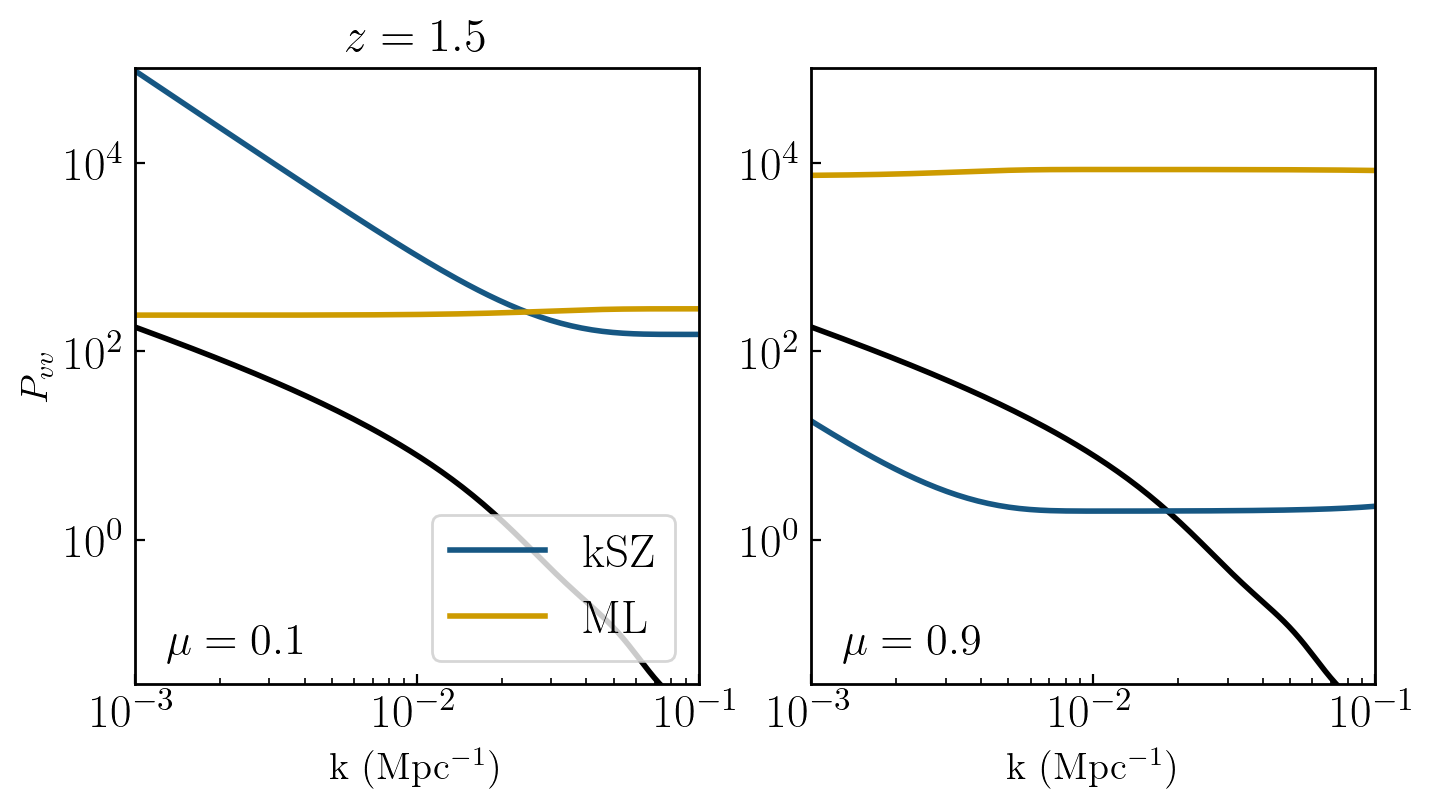

In [22]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)

plt.loglog(k_large, Pvv[:,0], 'k')
plt.loglog(k_large, Nvv_kSZ[:,110], color=palette[0], label='kSZ')
plt.loglog(k_large, Nvv_ML[:,110], color=palette[1], label='ML')
plt.title(r'$z=%g$'%m.z)
plt.xlim(1e-3, 1e-1)
plt.ylim(3e-2,1e5)
plt.legend(loc='lower right')
plt.xlabel('k (Mpc$^{-1}$)')
plt.ylabel(r'$P_{vv}$')
plt.text(1.3e-3, 5e-2, r'$\mu=%g$'%np.round(mu_L[110],1), fontsize=16, ha='left', va='bottom', color='black', alpha=1)

plt.subplot(1,2,2)
plt.loglog(k_large, Pvv[:,0], 'k')
plt.loglog(k_large, Nvv_kSZ[:,190], color=palette[0])
plt.loglog(k_large, Nvv_ML[:,190], color=palette[1])
plt.xlim(1e-3, 1e-1)
plt.ylim(3e-2,1e5)
plt.xlabel('k (Mpc$^{-1}$)')
plt.text(1.3e-3, 5e-2, r'$\mu=%g$'%np.round(mu_L[190],1), fontsize=16, ha='left', va='bottom', color='black', alpha=1)


#### Test only moving-lens part

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


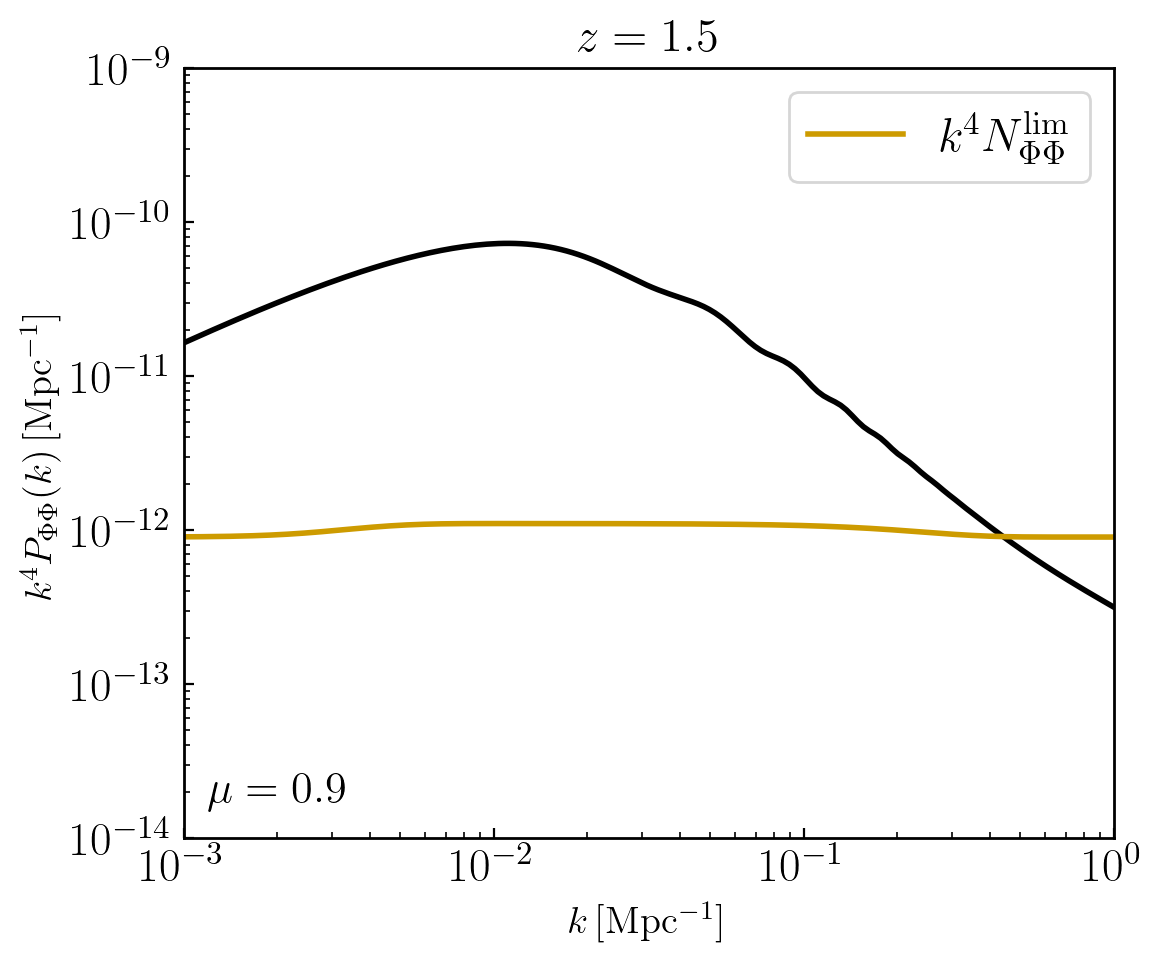

In [23]:

N_xx = m.Pshot*m.Wk + m.Pnoise

zcosmo = np.linspace(0.,15.,101)
cosmo1 = (m.cosmo_input_camb).copy()
cosmo1.pop('f_NL')
camb_pars = camb.set_params(**cosmo1)
camb_pars.set_matter_power(redshifts=list(zcosmo))
cosmo = camb.get_results(camb_pars)
H = lambda z: cosmo.hubble_parameter(z)/(cu.c.to(u.km/u.s)).value  # 1/Mpc    
omegam = (camb_pars.ombh2 + camb_pars.omch2 + camb_pars.omnuh2) / (camb_pars.H0 / 100) ** 2
rhoM0 = 3*omegam*H(0.)**2 # Mpc^-2

noise_pot = ((1+m.z)*rhoM0/2)**2/((m.k)**4 * (m.bavg[0]*m.Tmean)**2)*N_xx # Mpc^3

interp_Pphiphi = camb.get_matter_power_interpolator(camb_pars, zmin=0, zmax=zcosmo[-1], nz_step=150, zs=None, kmax=max(m.k.value), nonlinear=True,var1=camb.model.Transfer_Weyl, var2=camb.model.Transfer_Weyl, hubble_units=False, 
                                                    k_hunit=False, return_z_k=False, k_per_logint=None, log_interp=False,  extrap_kmax=True).P  # Mpc^-1


plt.loglog(m.k, interp_Pphiphi(m.z, m.k.value), 'k')
plt.loglog(m.k, m.k**4*noise_pot[190,:], label=r'$k^4 N_{\Phi\Phi}^{\mathrm{lim}}$', color=palette[1])
plt.xlim(1e-3,1e0)
plt.ylim(1e-14,1e-9)
#plt.ylim(1e-14,1e2)
plt.title(r'$z=%g$'%m.z)
plt.xlabel(r'$k\,[{\rm Mpc^{-1}}]$')
plt.ylabel(r'$k^4 P_{\Phi \Phi}(k)\,[{\rm Mpc^{-1}}]$')
plt.text(1.2e-3, 1.5e-14, r'$\mu=%g$'%np.round(m.mu[190],1), fontsize=16, ha='left', va='bottom', color='black', alpha=1)
plt.legend()

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Text(0.0012, 0.05, '$\\mu=0.9$')

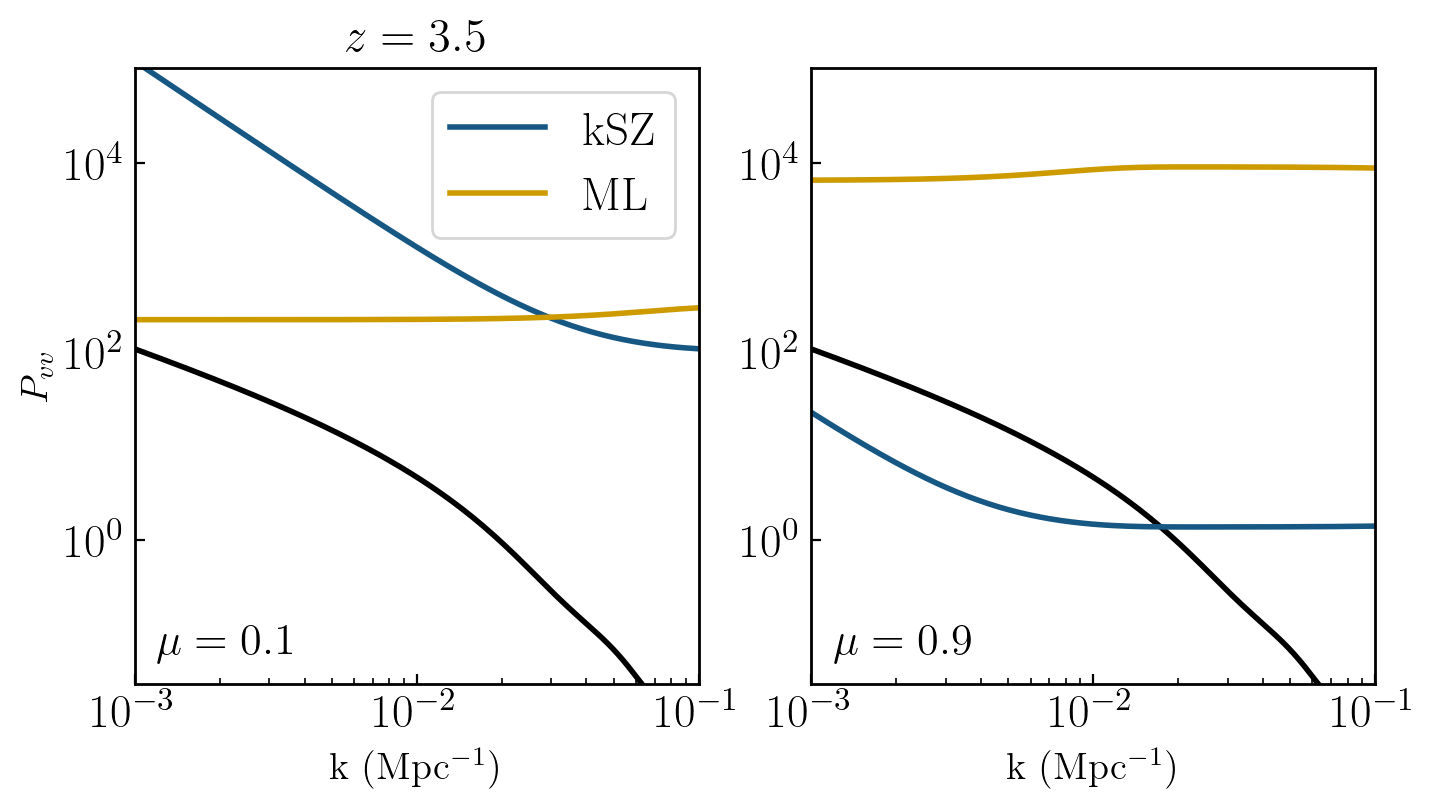

In [24]:
nu, Dnu = Dnu_from_Dz(m.nu, zs[2], 1)
cosmo_model_params['nuObs'] = nu
obs_params['Delta_nu'] = Dnu
obs_params['dnu'] = (nu/R).to(u.MHz)
obs_params['beam_FWHM'] = beam[2]
obs_params['sigma_pix'] = sigpix[2]
m = update_Pkline(obs_params,cosmo_model_params)[0]

_,_,_,Pvpar,Pvperp,_ = get_powers(m, k_large)
Pvv = Pvpar+Pvperp

# Need to turn on the 1-halo flag for the noise calulation (for others we leave it off)
cosmo_model_params['do_onehalo'] = True
m = update_Pkline(obs_params,cosmo_model_params)[0]
_,Nvv_par,Nvv_perp = get_noises(m, k_large, Delta_T_S4)
cosmo_model_params['do_onehalo'] = False
m = update_Pkline(obs_params,cosmo_model_params)[0]

Nvv_kSZ = mu_L**-2 * Nvv_par
Nvv_ML = (np.sqrt(1-mu_L**2))**-2 * Nvv_perp



plt.figure(figsize=(8,4))
plt.subplot(1,2,1)

plt.loglog(k_large, Pvv[:,0], 'k')
plt.loglog(k_large, Nvv_kSZ[:,110], color=palette[0], label='kSZ')
plt.loglog(k_large, Nvv_ML[:,110], color=palette[1], label='ML')
plt.title(r'$z=%g$'%m.z)
plt.xlim(1e-3, 1e-1)
plt.ylim(3e-2,1e5)
plt.legend()
plt.xlabel('k (Mpc$^{-1}$)')
plt.ylabel(r'$P_{vv}$')
plt.text(1.2e-3, 5e-2, r'$\mu=%g$'%np.round(mu_L[110],1), fontsize=16, ha='left', va='bottom', color='black', alpha=1)

plt.subplot(1,2,2)
plt.loglog(k_large, Pvv[:,0], 'k')
plt.loglog(k_large, Nvv_kSZ[:,190], color=palette[0])
plt.loglog(k_large, Nvv_ML[:,190], color=palette[1])
plt.xlim(1e-3, 1e-1)
plt.ylim(3e-2,1e5)
plt.xlabel('k (Mpc$^{-1}$)')
plt.text(1.2e-3, 5e-2, r'$\mu=%g$'%np.round(mu_L[190],1), fontsize=16, ha='left', va='bottom', color='black', alpha=1)


In [25]:
deltas= [1e-2,1e-2,-1e-2,1e-2,1e-2,3e-1,3e-1,1e-2,1e-2,1e-2]
free_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'bv_par', 'bv_perp', 'bT']

deriv_PXX=np.zeros((len(free_params), nkL))
deriv_PvX_par=np.zeros((len(free_params), nkL))
deriv_PvX_perp=np.zeros((len(free_params), nkL))
deriv_Pvv_par=np.zeros((len(free_params), nkL))
deriv_Pvv_perp=np.zeros((len(free_params), nkL))
deriv_Pvv_par_perp=np.zeros((len(free_params), nkL))

d_PXX, d_PvX_par, d_PvX_perp, d_Pvv_par, d_Pvv_perp, d_Pvv_par_perp = derivs(m, cosmo_params, bias_params, free_params, deltas, k_large)
deriv_PXX=d_PXX[:,:,-1]
deriv_PvX_par=d_PvX_par[:,:,-1]
deriv_PvX_perp=d_PvX_perp[:,:,-1]
deriv_Pvv_par=d_Pvv_par[:,:,-1]
deriv_Pvv_perp=d_Pvv_perp[:,:,-1]
deriv_Pvv_par_perp=d_Pvv_par_perp[:,:,-1]



Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt

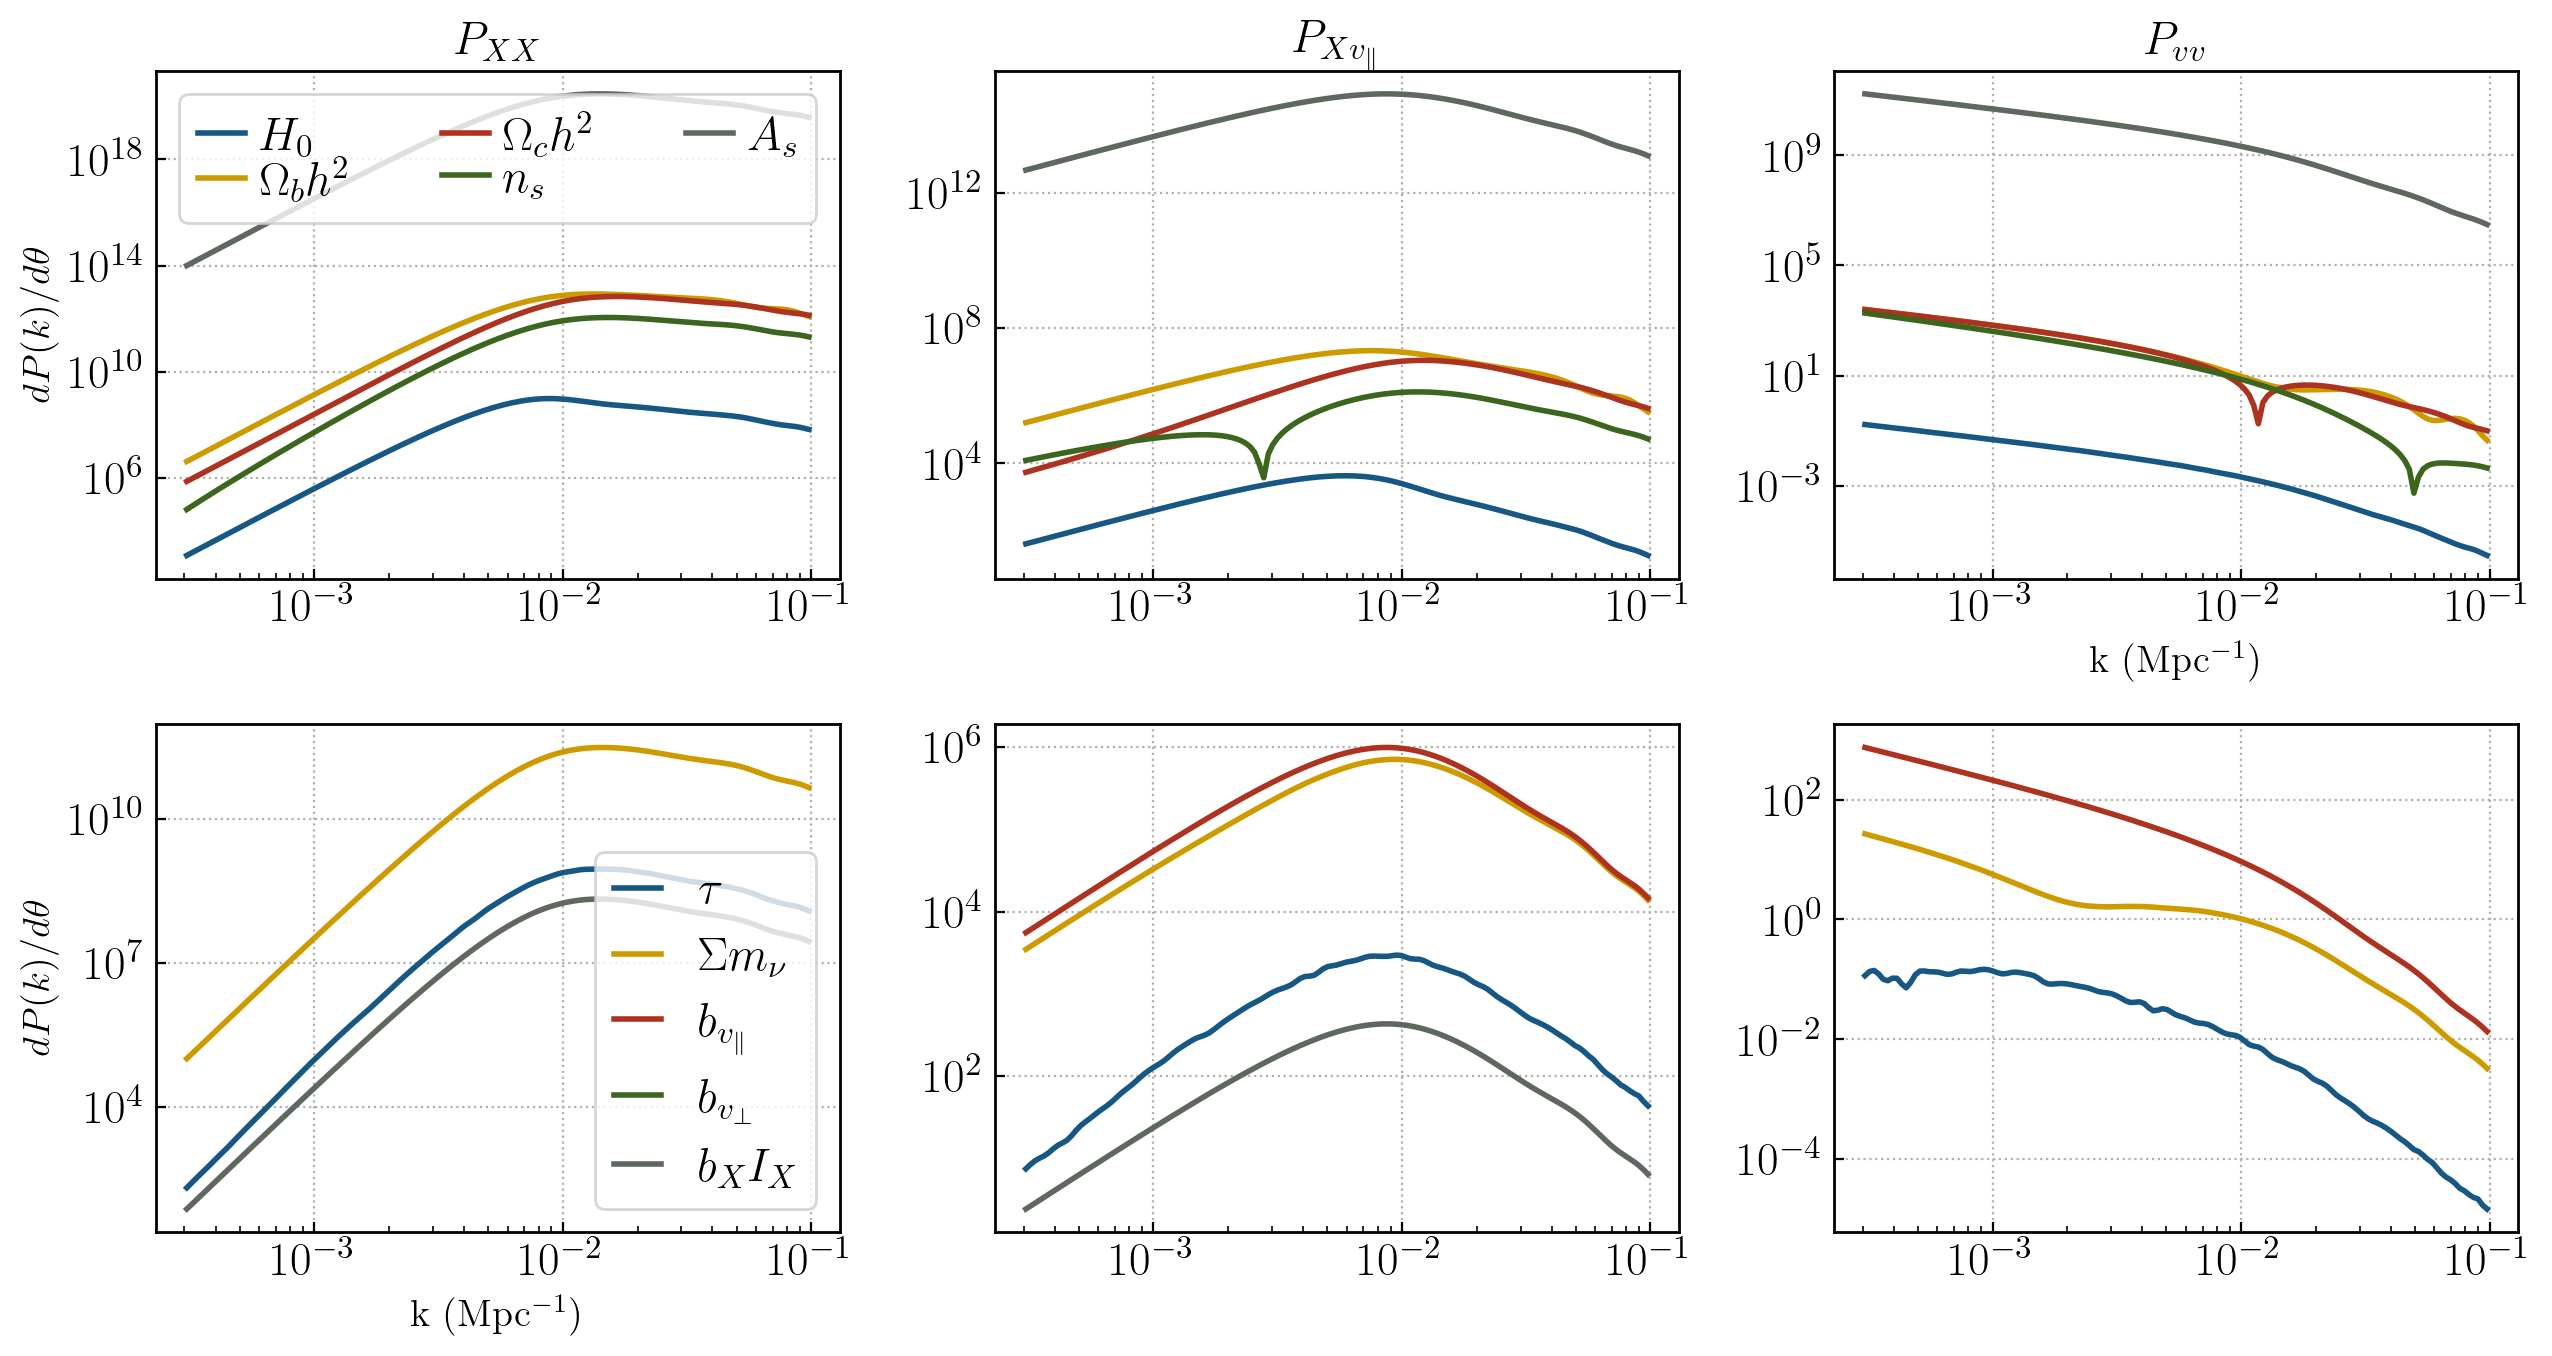

In [26]:
labels = ['$H_0$', r'$\Omega_{b}h^2$', r'$\Omega_{c}h^2$', '$n_s$', '$A_s$', r'$\tau$', r'$\Sigma m_\nu$', '$b_{v_{\parallel}}$', '$b_{v_{\perp}}$', '$b_X I_X$']

plt.figure(figsize=(13,7))
plt.subplot(2,3,1)

plt.loglog(k_large, abs(deriv_PXX[0,:]), color=palette[0], label='%s'%(labels[0]))
plt.loglog(k_large, abs(deriv_PXX[1,:]), color=palette[1], label='%s'%(labels[1]))
plt.loglog(k_large, abs(deriv_PXX[2,:]), color=palette[2], label='%s'%(labels[2]))
plt.loglog(k_large, abs(deriv_PXX[3,:]), color=palette[3], label='%s'%(labels[3]))
plt.loglog(k_large, abs(deriv_PXX[4,:]), color=palette[4], label='%s'%(labels[4]))

#plt.title('z = %g'%m.z)
plt.title(r'$P_{XX}$')
plt.legend(ncol=3, handlelength=1, labelspacing=0,handletextpad=0.3, mode='expand')
plt.ylabel(r'$dP(k)/d \theta$')
plt.grid(linestyle='dotted')

plt.subplot(2,3,2)
plt.loglog(k_large, abs(deriv_PvX_par[0,:]), color=palette[0])
plt.loglog(k_large, abs(deriv_PvX_par[1,:]), color=palette[1])
plt.loglog(k_large, abs(deriv_PvX_par[2,:]), color=palette[2])
plt.loglog(k_large, abs(deriv_PvX_par[3,:]), color=palette[3])
plt.loglog(k_large, abs(deriv_PvX_par[4,:]), color=palette[4])
plt.title(r'$P_{Xv_\parallel}$')
plt.grid(linestyle='dotted')

plt.subplot(2,3,3)
plt.loglog(k_large, abs(deriv_Pvv_par[0,:]), color=palette[0])
plt.loglog(k_large, abs(deriv_Pvv_par[1,:]), color=palette[1])
plt.loglog(k_large, abs(deriv_Pvv_par[2,:]), color=palette[2])
plt.loglog(k_large, abs(deriv_Pvv_par[3,:]), color=palette[3])
plt.loglog(k_large, abs(deriv_Pvv_par[4,:]), color=palette[4])
plt.title(r'$P_{vv}$')

plt.xlabel('k (Mpc$^{-1}$)')
plt.grid(linestyle='dotted')

plt.subplot(2,3,4)
plt.loglog(k_large, abs(deriv_PXX[5,:]), color=palette[0], label='%s'%(labels[5]))
plt.loglog(k_large, abs(deriv_PXX[6,:]), color=palette[1], label='%s'%(labels[6]))
plt.loglog(k_large, abs(deriv_PXX[7,:]), color=palette[2], label='%s'%(labels[7]))
plt.loglog(k_large, abs(deriv_PXX[8,:]), color=palette[3], label='%s'%(labels[8]))
plt.loglog(k_large, abs(deriv_PXX[9,:]), color=palette[4], label='%s'%(labels[9]))
plt.legend(handlelength=1)
plt.xlabel('k (Mpc$^{-1}$)')
plt.ylabel(r'$dP(k)/d \theta$')
plt.grid(linestyle='dotted')

plt.subplot(2,3,5)
plt.loglog(k_large, abs(deriv_PvX_par[5,:]), color=palette[0])
plt.loglog(k_large, abs(deriv_PvX_par[6,:]), color=palette[1])
plt.loglog(k_large, abs(deriv_PvX_par[7,:]), color=palette[2])
plt.loglog(k_large, abs(deriv_PvX_par[8,:]), color=palette[3])
plt.loglog(k_large, abs(deriv_PvX_par[9,:]), color=palette[4])

plt.grid(linestyle='dotted')

plt.subplot(2,3,6)
plt.loglog(k_large, abs(deriv_Pvv_par[5,:]), color=palette[0])
plt.loglog(k_large, abs(deriv_Pvv_par[6,:]), color=palette[1])
plt.loglog(k_large, abs(deriv_Pvv_par[7,:]), color=palette[2])
plt.loglog(k_large, abs(deriv_Pvv_par[8,:]), color=palette[3])
plt.loglog(k_large, abs(deriv_Pvv_par[9,:]), color=palette[4])


plt.grid(linestyle='dotted')

plt.tight_layout()


#### Some power spectra plots

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


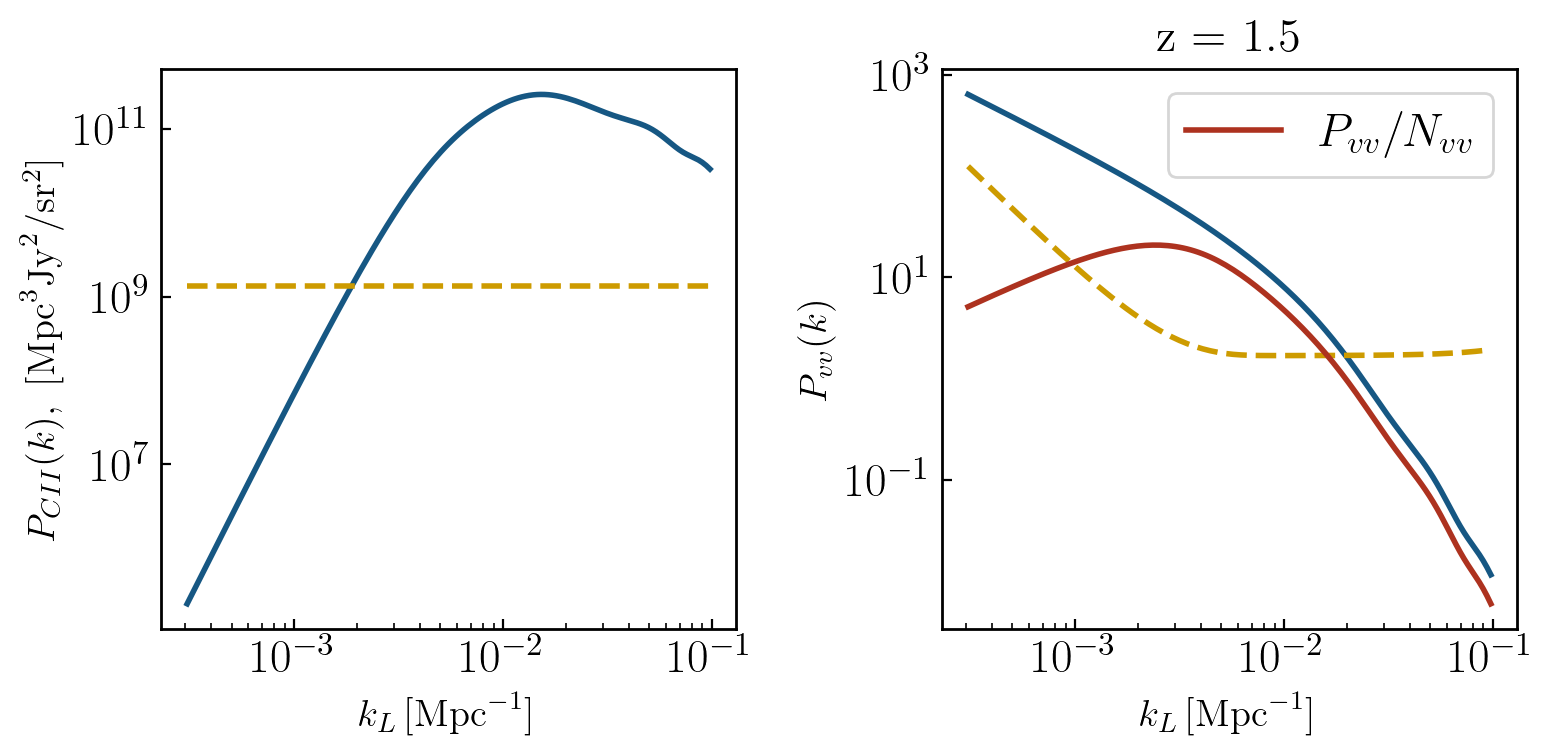

In [27]:
nu, Dnu = Dnu_from_Dz(m.nu, zs[0], 1)
cosmo_model_params['nuObs'] = nu
obs_params['Delta_nu'] = Dnu
obs_params['dnu'] = (nu/R).to(u.MHz)
obs_params['beam_FWHM'] = beam[0]
obs_params['sigma_pix'] = sigpix[0]
m = update_Pkline(obs_params,cosmo_model_params)[0]

P_XX,_,_,Pvpar,Pvperp,_ = get_powers(m, k_large)
P_vv = Pvpar+Pvperp

# Need to turn on the 1-halo flag for the noise calulation (for others we leave it off)
cosmo_model_params['do_onehalo'] = True
m = update_Pkline(obs_params,cosmo_model_params)[0]
N_XX,Nvv_par,_ = get_noises(m, k_large, Delta_T_S4)
cosmo_model_params['do_onehalo'] = False
m = update_Pkline(obs_params,cosmo_model_params)[0]

Nvv_kSZ = mu_L**-2 * Nvv_par


plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.loglog(k_large, P_XX[:,-1])
plt.loglog(k_large, N_XX[:,-1], ls='--')
plt.ylabel(r'$P_{CII}(k),\ [\mathrm{Mpc}^3 \mathrm{Jy}^2 / \mathrm{sr}^2]$')
plt.xlabel(r'$k_L \, [\mathrm{Mpc}^{-1}]$')

plt.subplot(1,2,2)
plt.loglog(k_large, P_vv[:,-1])
plt.loglog(k_large, Nvv_kSZ[:,-1], ls='--')
plt.loglog(k_large, (P_vv/Nvv_kSZ)[:,-1], label=r'$P_{vv}/N_{vv}$')
plt.ylabel(r'$P_{vv}(k)$')
plt.xlabel(r'$k_L \, [\mathrm{Mpc}^{-1}]$')
plt.legend()
plt.title('z = %g'%m.z)
plt.tight_layout()

# $\Sigma m_\nu$ analysis

In [21]:
down = False
cosmo_model_params, obs_params = lim_params('CII',down)
cosmo_model_params['cosmo_input_camb'] = cosmo_params
m = update_Pkline(obs_params,cosmo_model_params)[0]

deltas= [1e-2,1e-2,-1e-2,1e-2,1e-2,3e-1,3e-1,1e-2,1e-2,1e-2]
free_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'bv_par', 'bv_perp', 'bT']
fixed_params = ['bv_par', 'bv_perp']


nu, Dnu = Dnu_from_Dz(m.nu, zs[0], 1)
cosmo_model_params['nuObs'] = nu
obs_params['Delta_nu'] = Dnu
obs_params['dnu'] = (nu/R).to(u.MHz)
obs_params['beam_FWHM'] = beam[0]
obs_params['sigma_pix'] = sigpix[0]
m = update_Pkline(obs_params,cosmo_model_params)[0]
bias_params['bT'] = (m.bavg[0]*m.Tmean).value
print(m.z, m.nuObs, m.Delta_nu, m.beam_FWHM, m.sigma_N)

vol = m.Vfield
k_large = (k_fid[(k_fid.value <= 0.1)])
xx,vx = Fisher_mat(m, cosmo_params, bias_params, free_params, deltas, k_large, vol, Delta_T_S4)

print('LIM:')
covmat_lim, cov_params = covariance_mat(xx, free_params, fixed_params, {})
print_1_sigmas(covmat_lim,cov_params)
print('\n LIM+kSZ:')
covmat_lim_kSZ, cov_params = covariance_mat(vx, free_params, [], {})
print_1_sigmas(covmat_lim_kSZ,cov_params)


Note: redshifts have been re-sorted (earliest first)
1.5 760.2156 GHz 316.75649999999996 GHz 2.0 arcsec 389710.0 Jy / sr
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is

#### With redshift bins

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Text(0.5, 1.0, 'early-AtLAST')

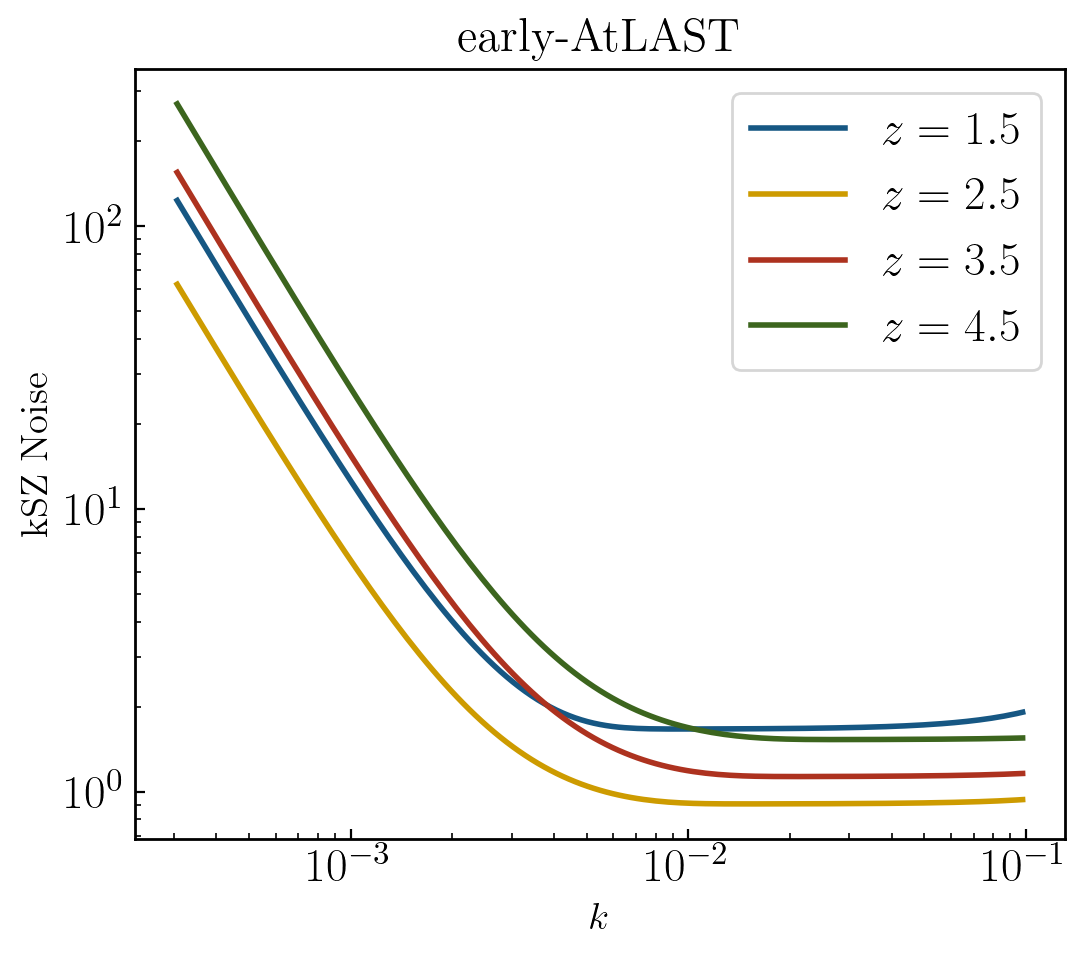

In [28]:
kL_list = []
Nvv_list = []

cosmo_model_params, obs_params = lim_params('CII', downgrade=False)
m = update_Pkline(obs_params,cosmo_model_params)[0]

for i in range(len(zs)):
    nu, Dnu = Dnu_from_Dz(m.nu, zs[i], 1)
    cosmo_model_params['nuObs'] = nu
    obs_params['Delta_nu'] = Dnu
    obs_params['dnu'] = (nu/R).to(u.MHz)
    obs_params['beam_FWHM'] = beam[i]
    obs_params['sigma_pix'] = sigpix[i]
    cosmo_model_params['do_onehalo'] = True
    m = update_Pkline(obs_params,cosmo_model_params)[0]
    vol = m.Vfield
    kL = (m.k[(m.k.value <= 0.1)])
    Nvv_par,_ = Rec_noise(m, kL, m.mu, Delta_T_S4)
    kL_list.append(kL)
    Nvv_list.append(Nvv_par[:,-1])
    
    
for i in range(len(zs)):
    plt.loglog(kL_list[i], Nvv_list[i], label=r'$z=%g$'%zs[i])
    
plt.legend()
plt.xlabel(r'$k$')
plt.ylabel('kSZ Noise')
plt.title('early-AtLAST')

In [29]:
cosmo_model_params['cosmo_input_camb'] = cosmo_params
m = update_Pkline(obs_params,cosmo_model_params)[0]

zs = np.arange(1.5, 4.51, 1)

deltas= [1e-2,1e-2,-1e-2,1e-2,1e-2,3e-1,3e-1,1e-2,1e-2,1e-2,1e-2]
free_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'bv_par', 'bv_perp', 'bT']
fixed_params = ['bv_par', 'bv_perp']

Fz_XX_LIM=np.zeros((len(zs),len(free_params),len(free_params)))
Fz_vX_LIM=np.zeros((len(zs),len(free_params),len(free_params)))
for i in range(len(zs)):
    cosmo_model_params, obs_params = lim_params('CII', downgrade=False)
    nu, Dnu = Dnu_from_Dz(m.nu, zs[i], 1)
    cosmo_model_params['nuObs'] = nu
    obs_params['Delta_nu'] = Dnu
    obs_params['dnu'] = (nu/R).to(u.MHz)
    obs_params['beam_FWHM'] = beam[i]
    obs_params['sigma_pix'] = sigpix[i]
    m = update_Pkline(obs_params,cosmo_model_params)[0]
    bias_params['bT'] = (m.bavg[0]*m.Tmean).value
    print(m.z, m.nuObs, m.Delta_nu, m.beam_FWHM, m.sigma_N)
    
    vol = m.Vfield
    k_large = (m.k[(m.k.value <= 0.1)])
    xx,vx = Fisher_mat(m, cosmo_params, bias_params, free_params, deltas, k_large, vol, Delta_T_S4)
    Fz_XX_LIM[i,:,:]=xx
    Fz_vX_LIM[i,:,:]=vx



Note: redshifts have been re-sorted (earliest first)
1.5 760.2156 GHz 316.75649999999996 GHz 2.0 arcsec 389710.0 Jy / sr
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is



Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt

In [30]:
lcdm_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'bv_par', 'bv_perp']
bT_params = ['bT0', 'bT1', 'bT2', 'bT3']
all_params = lcdm_params + bT_params
Nparams = len(all_params)

# Function to map parameter names to indices in the combined Fisher matrix
def get_param_indices(all_params):
    return {param: idx for idx, param in enumerate(all_params)}

F_XX_AtLAST = np.zeros((Nparams, Nparams))
F_vX_AtLAST = np.zeros((Nparams, Nparams))
# Get the parameter indices for the combined Fisher matrix
param_indices = get_param_indices(all_params)

bT_ind = free_params.index('bT')

# Add each individual Fisher matrix to the combined Fisher matrix
for i, F in enumerate(Fz_XX_LIM):
    # Indices for the LCDM parameters
    for j, param1 in enumerate(lcdm_params):
        for k, param2 in enumerate(lcdm_params):
            F_XX_AtLAST[param_indices[param1], param_indices[param2]] += F[j, k]

    # Indices for the LCDM parameters and bg parameter for this redshift bin
    bT_param = f'bT{i}'
    for j, param1 in enumerate(lcdm_params):
        F_XX_AtLAST[param_indices[param1], param_indices[bT_param]] += F[j, bT_ind]
        F_XX_AtLAST[param_indices[bT_param], param_indices[param1]] += F[bT_ind, j]

    # Index for the bg parameter for this redshift bin
    F_XX_AtLAST[param_indices[bT_param], param_indices[bT_param]] += F[bT_ind, bT_ind]

# Add each individual Fisher matrix to the combined Fisher matrix
for i, F in enumerate(Fz_vX_LIM):
    # Indices for the LCDM parameters
    for j, param1 in enumerate(lcdm_params):
        for k, param2 in enumerate(lcdm_params):
            F_vX_AtLAST[param_indices[param1], param_indices[param2]] += F[j, k]

    # Indices for the LCDM parameters and bg parameter for this redshift bin
    bT_param = f'bT{i}'
    for j, param1 in enumerate(lcdm_params):
        F_vX_AtLAST[param_indices[param1], param_indices[bT_param]] += F[j, bT_ind]
        F_vX_AtLAST[param_indices[bT_param], param_indices[param1]] += F[bT_ind, j]

    # Index for the bg parameter for this redshift bin
    F_vX_AtLAST[param_indices[bT_param], param_indices[bT_param]] += F[bT_ind, bT_ind]


In [33]:
print('LIM:')
covmat_lim, cov_params = covariance_mat(F_XX_AtLAST, all_params, fixed_params, {})
print_1_sigmas(covmat_lim,cov_params)
print('\n LIM+kSZ:')
covmat_lim_kSZ, cov_params = covariance_mat(F_vX_AtLAST, all_params, [], {'bv_par':0.01})
print_1_sigmas(covmat_lim_kSZ,cov_params)



LIM:


1-sigma of H0 is 1.690930485698097
1-sigma of ombh2 is 0.00016807678842860915
1-sigma of omch2 is 0.0005639088737556957
1-sigma of ns is 0.005410738585670781
1-sigma of As is 1.3230772985876416e-10
1-sigma of tau is 29.820069324668296
1-sigma of mnu is 0.05103178885940669
1-sigma of bT0 is 12.978954988466828
1-sigma of bT1 is 37.42041691821158
1-sigma of bT2 is 85.69654812476556
1-sigma of bT3 is 182.8511785921454

 LIM+kSZ:


1-sigma of H0 is 1.6525782696004523
1-sigma of ombh2 is 0.00016747472802483093
1-sigma of omch2 is 0.0005530284183946437
1-sigma of ns is 0.0051784312700056175
1-sigma of As is 9.709051451894297e-11
1-sigma of tau is 20.461004029008915
1-sigma of mnu is 0.04898282977822626
1-sigma of bv_par is 0.0047732023429939
1-sigma of bv_perp is 0.033854818354070636
1-sigma of bT0 is 12.239312629039121
1-sigma of bT1 is 29.79306170739617
1-sigma of bT2 is 65.55293935642209
1-sigma of bT3 is 135.52811950222218


In [67]:
print('LIM:')
covmat_lim, cov_params = covariance_mat(F_bao_CMB_lim+F_XX_AtLAST, all_params, fixed_params, {})
print_1_sigmas(covmat_lim,cov_params)
print('\n LIM+kSZ:')
covmat_lim_kSZ, cov_params = covariance_mat(F_bao_CMB_lim_vel+F_vX_AtLAST, all_params, [], {'bv_par':0.01})
print_1_sigmas(covmat_lim_kSZ,cov_params)



LIM:


1-sigma of H0 is 0.17356764352286125
1-sigma of ombh2 is 2.8262708192543164e-05
1-sigma of omch2 is 0.0002774228893344543
1-sigma of ns is 0.001734323108200138
1-sigma of As is 1.7845659396847007e-11
1-sigma of tau is 0.004680281554117295
1-sigma of mnu is 0.01895754888497249
1-sigma of bT0 is 2.710275189172407
1-sigma of bT1 is 13.82453862623139
1-sigma of bT2 is 21.773874154510377
1-sigma of bT3 is 33.020940353681446

 LIM+kSZ:


1-sigma of H0 is 0.17205919289301078
1-sigma of ombh2 is 2.821533991732699e-05
1-sigma of omch2 is 0.00027716304858117817
1-sigma of ns is 0.0017286605278413775
1-sigma of As is 1.7795319953939358e-11
1-sigma of tau is 0.0046668786312371036
1-sigma of mnu is 0.018795624459594512
1-sigma of bv_par is 0.0032158749027346506
1-sigma of bv_perp is 0.03362560768808517
1-sigma of bT0 is 2.688534212266446
1-sigma of bT1 is 13.690720172302006
1-sigma of bT2 is 21.604604125594797
1-sigma of bT3 is 32.81370633348241


## Plots for paper

Text(0, 0.5, '$\\sigma(\\Sigma m_\\nu) \\, \\textrm{[meV]}$')

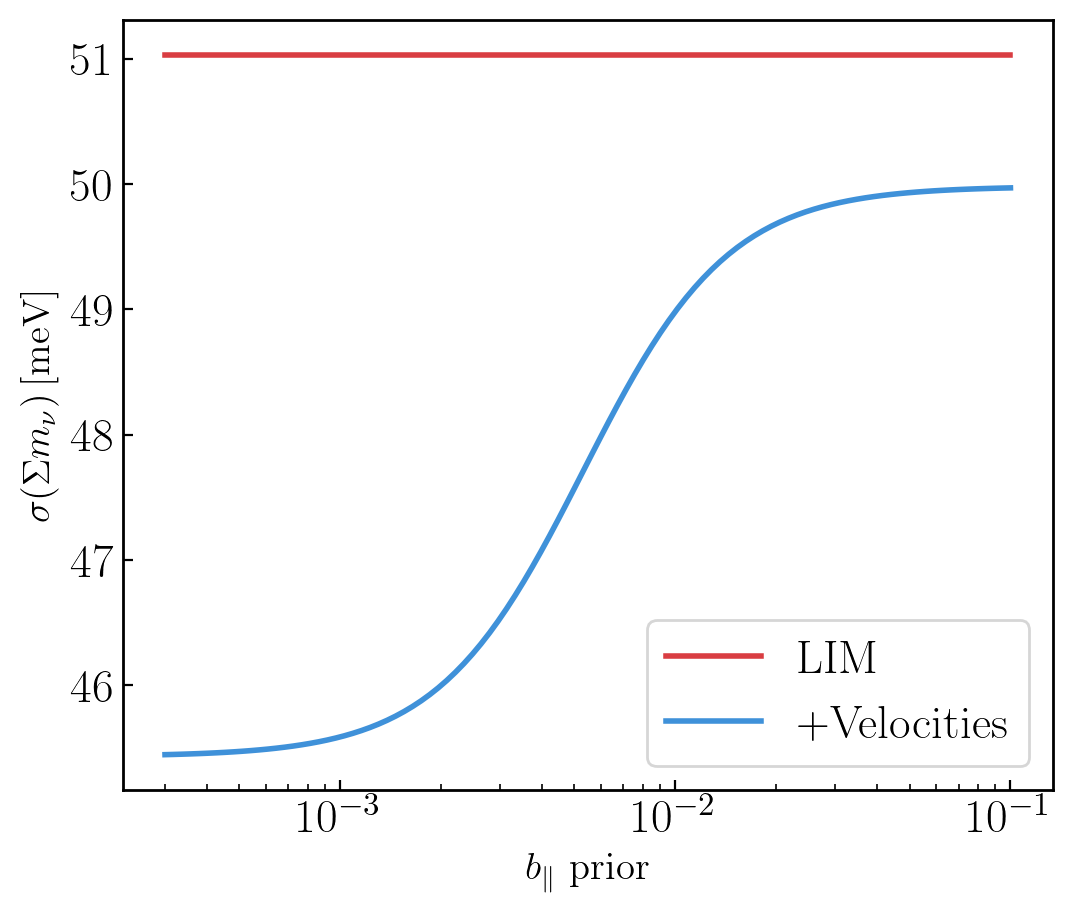

In [35]:
#bpar_pr = np.linspace(1e-4,1e-1,100)
bpar_pr = np.logspace(np.log10(3e-4),-1,100)

mnu_ind = free_params.index('mnu')
sig_mnu_lim = np.zeros(len(bpar_pr))
sig_mnu_lim_vel = np.zeros(len(bpar_pr))

for i in range(len(bpar_pr)):
    covmat_lim, cov_params = covariance_mat(F_XX_AtLAST, all_params, fixed_params, {})
    sig_mnu_lim[i] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_kSZ, cov_params = covariance_mat(F_vX_AtLAST, all_params, [], {'bv_par':bpar_pr[i]})
    sig_mnu_lim_vel[i] = np.sqrt(covmat_lim_kSZ[mnu_ind,mnu_ind])

plt.plot(bpar_pr, sig_mnu_lim*1e3, label='LIM', color=palette[15])
plt.plot(bpar_pr, sig_mnu_lim_vel*1e3, label='+Velocities', color=palette[14])
plt.xscale('log')
plt.legend()
plt.xlabel(r'$b_\parallel$ prior')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[meV]}$')
#plt.title(r'low+high $z$ with 0.5\% prior on $b_\parallel$')
#plt.ylim(60,75)

Text(0, 0.5, '$\\sigma(\\Sigma m_\\nu) \\, \\textrm{[meV]}$')

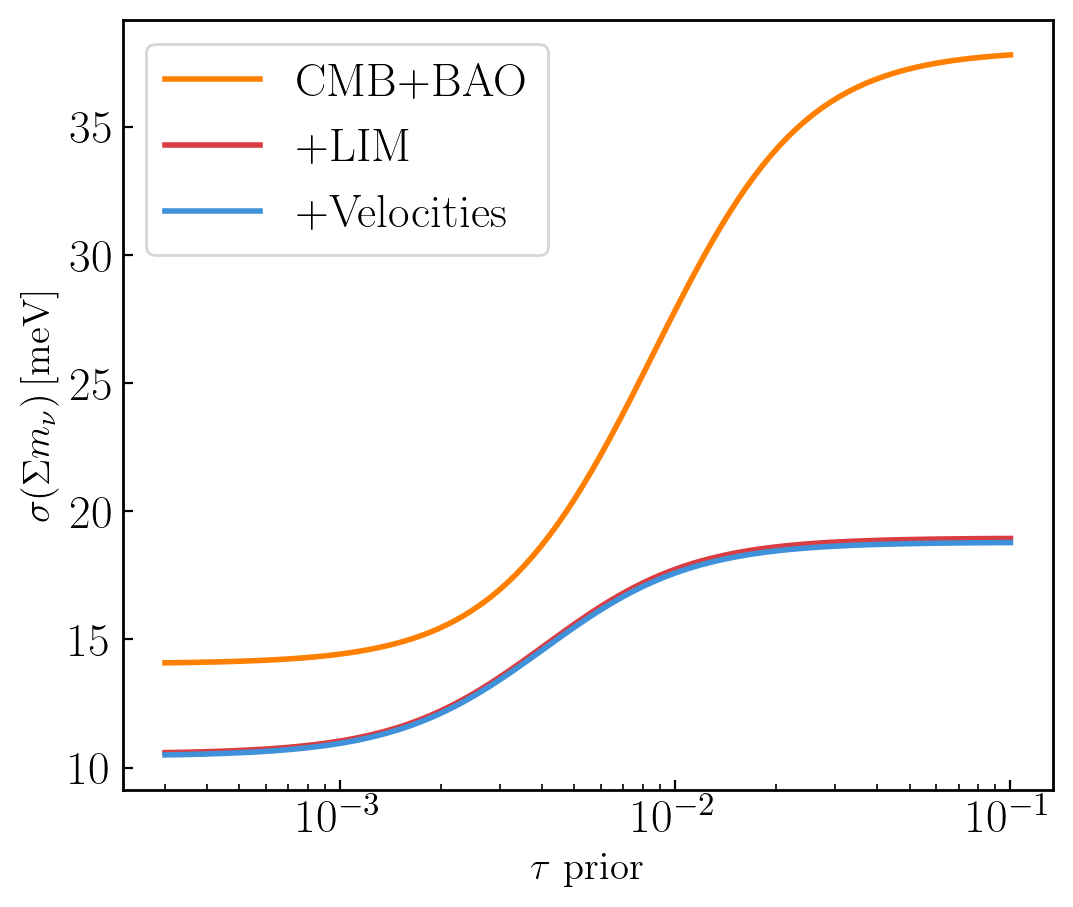

In [36]:
#bpar_pr = np.linspace(1e-4,1e-1,100)
tau_pr = np.logspace(np.log10(3e-4),-1,100)

mnu_ind = free_params.index('mnu')
sig_mnu = np.zeros(len(tau_pr))
sig_mnu_lim = np.zeros(len(tau_pr))
sig_mnu_lim_vel = np.zeros(len(tau_pr))

F_bao_CMB_lim = np.zeros((len(F_XX_AtLAST), len(F_XX_AtLAST)))
F_bao_CMB_lim[:len(F_bao_CMB), :len(F_bao_CMB)] = F_bao_CMB

F_bao_CMB_lim_vel = np.zeros((len(F_vX_AtLAST), len(F_vX_AtLAST)))
F_bao_CMB_lim_vel[:len(F_bao_CMB), :len(F_bao_CMB)] = F_bao_CMB

for i in range(len(tau_pr)):
    covmat, cov_params = covariance_mat(F_bao_CMB, free_params2, [], {'tau':tau_pr[i]})
    sig_mnu[i] = np.sqrt(covmat[mnu_ind,mnu_ind])
    covmat_lim, cov_params = covariance_mat(F_bao_CMB_lim+F_XX_AtLAST, all_params, fixed_params, {'tau':tau_pr[i]})
    sig_mnu_lim[i] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_kSZ, cov_params = covariance_mat(F_bao_CMB_lim_vel+F_vX_AtLAST, all_params, [], {'tau':tau_pr[i], 'bv_par':0.01})
    sig_mnu_lim_vel[i] = np.sqrt(covmat_lim_kSZ[mnu_ind,mnu_ind])

plt.plot(tau_pr, sig_mnu*1e3, label='CMB+BAO', color=palette[6])
plt.plot(tau_pr, sig_mnu_lim*1e3, label='+LIM', color=palette[15])
plt.plot(tau_pr, sig_mnu_lim_vel*1e3, label='+Velocities', color=palette[14])
plt.xscale('log')
plt.legend()
plt.xlabel(r'$\tau$ prior')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[meV]}$')
#plt.title(r'low+high $z$ with 0.5\% prior on $b_\parallel$')
#plt.ylim(60,75)

Text(0, 0.5, '$\\sigma(\\Sigma m_\\nu) \\, \\textrm{[meV]}$')

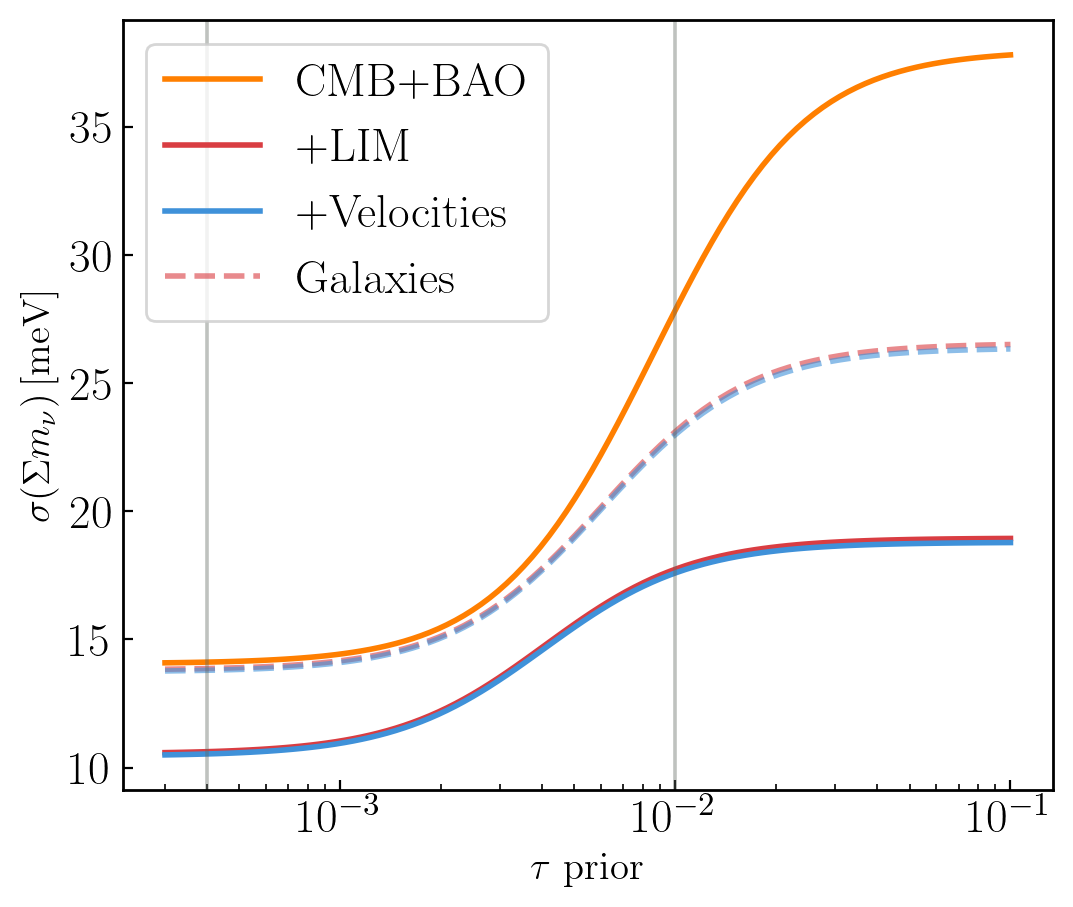

In [37]:
vm_root = '/media/HostShared/galaxies/'

sig_mnu_gal = np.loadtxt(vm_root+'sig_mnu_VRO10.txt')
sig_mnu_gal_vel = np.loadtxt(vm_root+'sig_mnu_VRO10_vel.txt')

tau_pr = np.logspace(np.log10(3e-4),-1,100)

mnu_ind = free_params.index('mnu')
sig_mnu = np.zeros(len(tau_pr))
sig_mnu_lim = np.zeros(len(tau_pr))
sig_mnu_lim_vel = np.zeros(len(tau_pr))

F_bao_CMB_lim = np.zeros((len(F_XX_AtLAST), len(F_XX_AtLAST)))
F_bao_CMB_lim[:len(F_bao_CMB), :len(F_bao_CMB)] = F_bao_CMB

F_bao_CMB_lim_vel = np.zeros((len(F_vX_AtLAST), len(F_vX_AtLAST)))
F_bao_CMB_lim_vel[:len(F_bao_CMB), :len(F_bao_CMB)] = F_bao_CMB

for i in range(len(tau_pr)):
    covmat, cov_params = covariance_mat(F_bao_CMB, free_params2, [], {'tau':tau_pr[i]})
    sig_mnu[i] = np.sqrt(covmat[mnu_ind,mnu_ind])
    covmat_lim, cov_params = covariance_mat(F_bao_CMB_lim+F_XX_AtLAST, all_params, fixed_params, {'tau':tau_pr[i]})
    sig_mnu_lim[i] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_kSZ, cov_params = covariance_mat(F_bao_CMB_lim_vel+F_vX_AtLAST, all_params, [], {'tau':tau_pr[i], 'bv_par':0.01})
    sig_mnu_lim_vel[i] = np.sqrt(covmat_lim_kSZ[mnu_ind,mnu_ind])

plt.plot(tau_pr, sig_mnu*1e3, label='CMB+BAO', color=palette[6])
plt.plot(tau_pr, sig_mnu_lim*1e3, label='+LIM', color=palette[15])
plt.plot(tau_pr, sig_mnu_lim_vel*1e3, label='+Velocities', color=palette[14])
plt.plot(tau_pr, sig_mnu_gal*1e3, ls='--', color=palette[15], alpha=0.6, label='Galaxies')
plt.plot(tau_pr, sig_mnu_gal_vel*1e3, ls='--', color=palette[14], alpha=0.6)
plt.axvline(x = 0.01, color = palette[4], alpha=0.4, lw=1.3)
plt.axvline(x = 4e-4, color = palette[4], alpha=0.4, lw=1.3)
plt.xscale('log')
plt.legend()
plt.xlabel(r'$\tau$ prior')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[meV]}$')
#plt.title(r'low+high $z$ with 0.5\% prior on $b_\parallel$')
#plt.ylim(60,75)

## 2D grid plot

In [61]:
Omegas = np.logspace(np.log10(600), np.log10(17400), 5)
tobss = np.linspace(3000, 12335, 5)


cosmo_model_params['cosmo_input_camb'] = cosmo_params
cosmo_model_params, obs_params = lim_params('CII', downgrade=False)
m = update_Pkline(obs_params,cosmo_model_params)[0]

deltas= [1e-2,1e-2,-1e-2,1e-2,1e-2,3e-1,3e-1,1e-2,1e-2,1e-2,1e-2]
free_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'bv_par', 'bv_perp', 'bT']
fixed_params = ['bv_par', 'bv_perp']

lcdm_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'bv_par', 'bv_perp']
bT_params = ['bT0', 'bT1', 'bT2', 'bT3']
all_params = lcdm_params + bT_params
Nparams = len(all_params)

# Function to map parameter names to indices in the combined Fisher matrix
def get_param_indices(all_params):
    return {param: idx for idx, param in enumerate(all_params)}

# Get the parameter indices for the combined Fisher matrix
param_indices = get_param_indices(all_params)
bT_ind = free_params.index('bT') 


F_XX_om_tob = []
F_vX_om_tob = []

F_XX_om_tob = np.zeros((len(Omegas),len(tobss),Nparams,Nparams))
F_vX_om_tob = np.zeros((len(Omegas),len(tobss),Nparams,Nparams))

Fz_XX_LIM = np.zeros((len(zs),len(free_params),len(free_params)))
Fz_vX_LIM = np.zeros((len(zs),len(free_params),len(free_params)))
for o in range(len(Omegas)):
    for t in range(len(tobss)):
        obs_params['Omega_field'] = Omegas[o]*u.deg**2
        obs_params['tobs'] = tobss[t]*u.h
        for i in range(len(zs)):  
            nu, Dnu = Dnu_from_Dz(m.nu, zs[i], 1)
            cosmo_model_params['nuObs'] = nu
            obs_params['Delta_nu'] = Dnu
            obs_params['dnu'] = (nu/R).to(u.MHz)
            obs_params['beam_FWHM'] = beam[i]
            obs_params['sigma_pix'] = sigpix[i]
            m = update_Pkline(obs_params,cosmo_model_params)[0]
            bias_params['bT'] = (m.bavg[0]*m.Tmean).value
            print(m.z, m.nuObs, m.Delta_nu, m.beam_FWHM, m.sigma_N, m.Omega_field, m.tobs)

            vol = m.Vfield
            xx,vx = Fisher_mat(m, cosmo_params, bias_params, free_params, deltas, k_large, vol, Delta_T_S4)
            
            Fz_XX_LIM[i,:,:] = xx
            Fz_vX_LIM[i,:,:] = vx

        F_XX_LIM = np.zeros((Nparams, Nparams))
        F_vX_LIM = np.zeros((Nparams, Nparams))
        
        
        # Add each individual Fisher matrix to the combined Fisher matrix
        for i, F in enumerate(Fz_XX_LIM):
            # Indices for the LCDM parameters
            for j, param1 in enumerate(lcdm_params):
                for k, param2 in enumerate(lcdm_params):
                    F_XX_LIM[param_indices[param1], param_indices[param2]] += F[j, k]

            # Indices for the LCDM parameters and bg parameter for this redshift bin
            bT_param = f'bT{i}'
            for j, param1 in enumerate(lcdm_params):
                F_XX_LIM[param_indices[param1], param_indices[bT_param]] += F[j, bT_ind]
                F_XX_LIM[param_indices[bT_param], param_indices[param1]] += F[bT_ind, j]

            # Index for the bg parameter for this redshift bin
            F_XX_LIM[param_indices[bT_param], param_indices[bT_param]] += F[bT_ind, bT_ind]

        # Add each individual Fisher matrix to the combined Fisher matrix
        for i, F in enumerate(Fz_vX_LIM):
            # Indices for the LCDM parameters
            for j, param1 in enumerate(lcdm_params):
                for k, param2 in enumerate(lcdm_params):
                    F_vX_LIM[param_indices[param1], param_indices[param2]] += F[j, k]

            # Indices for the LCDM parameters and bg parameter for this redshift bin
            bT_param = f'bT{i}'
            for j, param1 in enumerate(lcdm_params):
                F_vX_LIM[param_indices[param1], param_indices[bT_param]] += F[j, bT_ind]
                F_vX_LIM[param_indices[bT_param], param_indices[param1]] += F[bT_ind, j]

            # Index for the bg parameter for this redshift bin
            F_vX_LIM[param_indices[bT_param], param_indices[bT_param]] += F[bT_ind, bT_ind]

        
        F_vX_om_tob[o,t] = F_vX_LIM
        F_XX_om_tob[o,t] = F_XX_LIM
    
    

with open(fisher_root+'F_vX_omega_tobs_AtLAST_scale-dep-f.pkl', 'wb') as file: 
    pickle.dump(F_vX_om_tob, file)
    
with open(fisher_root+'F_XX_omega_tob_AtLAST_scale-dep-f.pkl', 'wb') as file: 
    pickle.dump(F_XX_om_tob, file)

Note: redshifts have been re-sorted (earliest first)
1.5 760.2156 GHz 316.75649999999996 GHz 2.0 arcsec 201242.3963366898 Jy / sr 599.9999999999997 deg2 3000.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is 



Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt



Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delt



Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt



Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)



Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mn



Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu,



Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par



Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv



Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt



Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1



Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating f



Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating f



Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts ha



Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
3.5 422.342 GHz 95.02695 GHz 3.6 arcsec 62913.45133567405 Jy / sr 3231.0988842807024 d



Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
2.5 543.0111428571429 GHz 158.37825000000004 GHz 2.8 arcsec 104884.07916674118 Jy / sr 3231.0988842807024 deg2 7667.5 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorte



Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
1.5 760.2156 GHz 316.75649999999996 GHz 2.0 arcsec 255774.01462361342 Jy / sr 3231.0988842807024 deg2 10001.25 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest



Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
4.5 345.55254545454545 GHz 63.35129999999998 GHz 4.4 arcsec 26274.812875510066 Jy / sr 3231.0988842807024 deg2 10001.25 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (ear



Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
3.5 422.342 GHz 95.02695 GHz 3.6 arcsec 41370.45159128838 Jy / sr 3231.0988842807024 deg2 12335.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simul



Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
2.5 543.0111428571429 GHz 158.37825000000004 GHz 2.8 arcsec 255432.16131891208 Jy / sr 7498.074458584963 deg2 3000.0 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest f



Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
1.5 760.2156 GHz 316.75649999999996 GHz 2.0 arcsec 533543.088273817 Jy / sr 7498.074458584963 deg2 5333.75 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)




Note: redshifts have been re-sorted (earliest first)
4.5 345.55254545454545 GHz 63.35129999999998 GHz 4.4 arcsec 54809.21535143032 Jy / sr 7498.074458584963 deg2 5333.75 h
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earlie

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is 



Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt



Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delt



Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt



Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)



Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mn



Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu,



Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par



Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv



Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt

In [14]:
with open(fisher_root+'F_vX_omega_tobs_AtLAST_scale-dep-f.pkl', "rb") as f:
    F_vX_om_tob = pickle.load(f)
    
with open(fisher_root+'F_XX_omega_tob_AtLAST_scale-dep-f.pkl', "rb") as f:
    F_XX_om_tob = pickle.load(f)

    
free_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'bv_par', 'bv_perp', 'bT']
fixed_params = ['bv_par', 'bv_perp']

lcdm_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'bv_par', 'bv_perp']
bT_params = ['bT0', 'bT1', 'bT2', 'bT3']
all_params = lcdm_params + bT_params

Omegas = np.logspace(np.log10(370), np.log10(20450), 5)
tobss = np.linspace(1000, 13000, 5)

(599.9999999999997, 17399.99999999999)

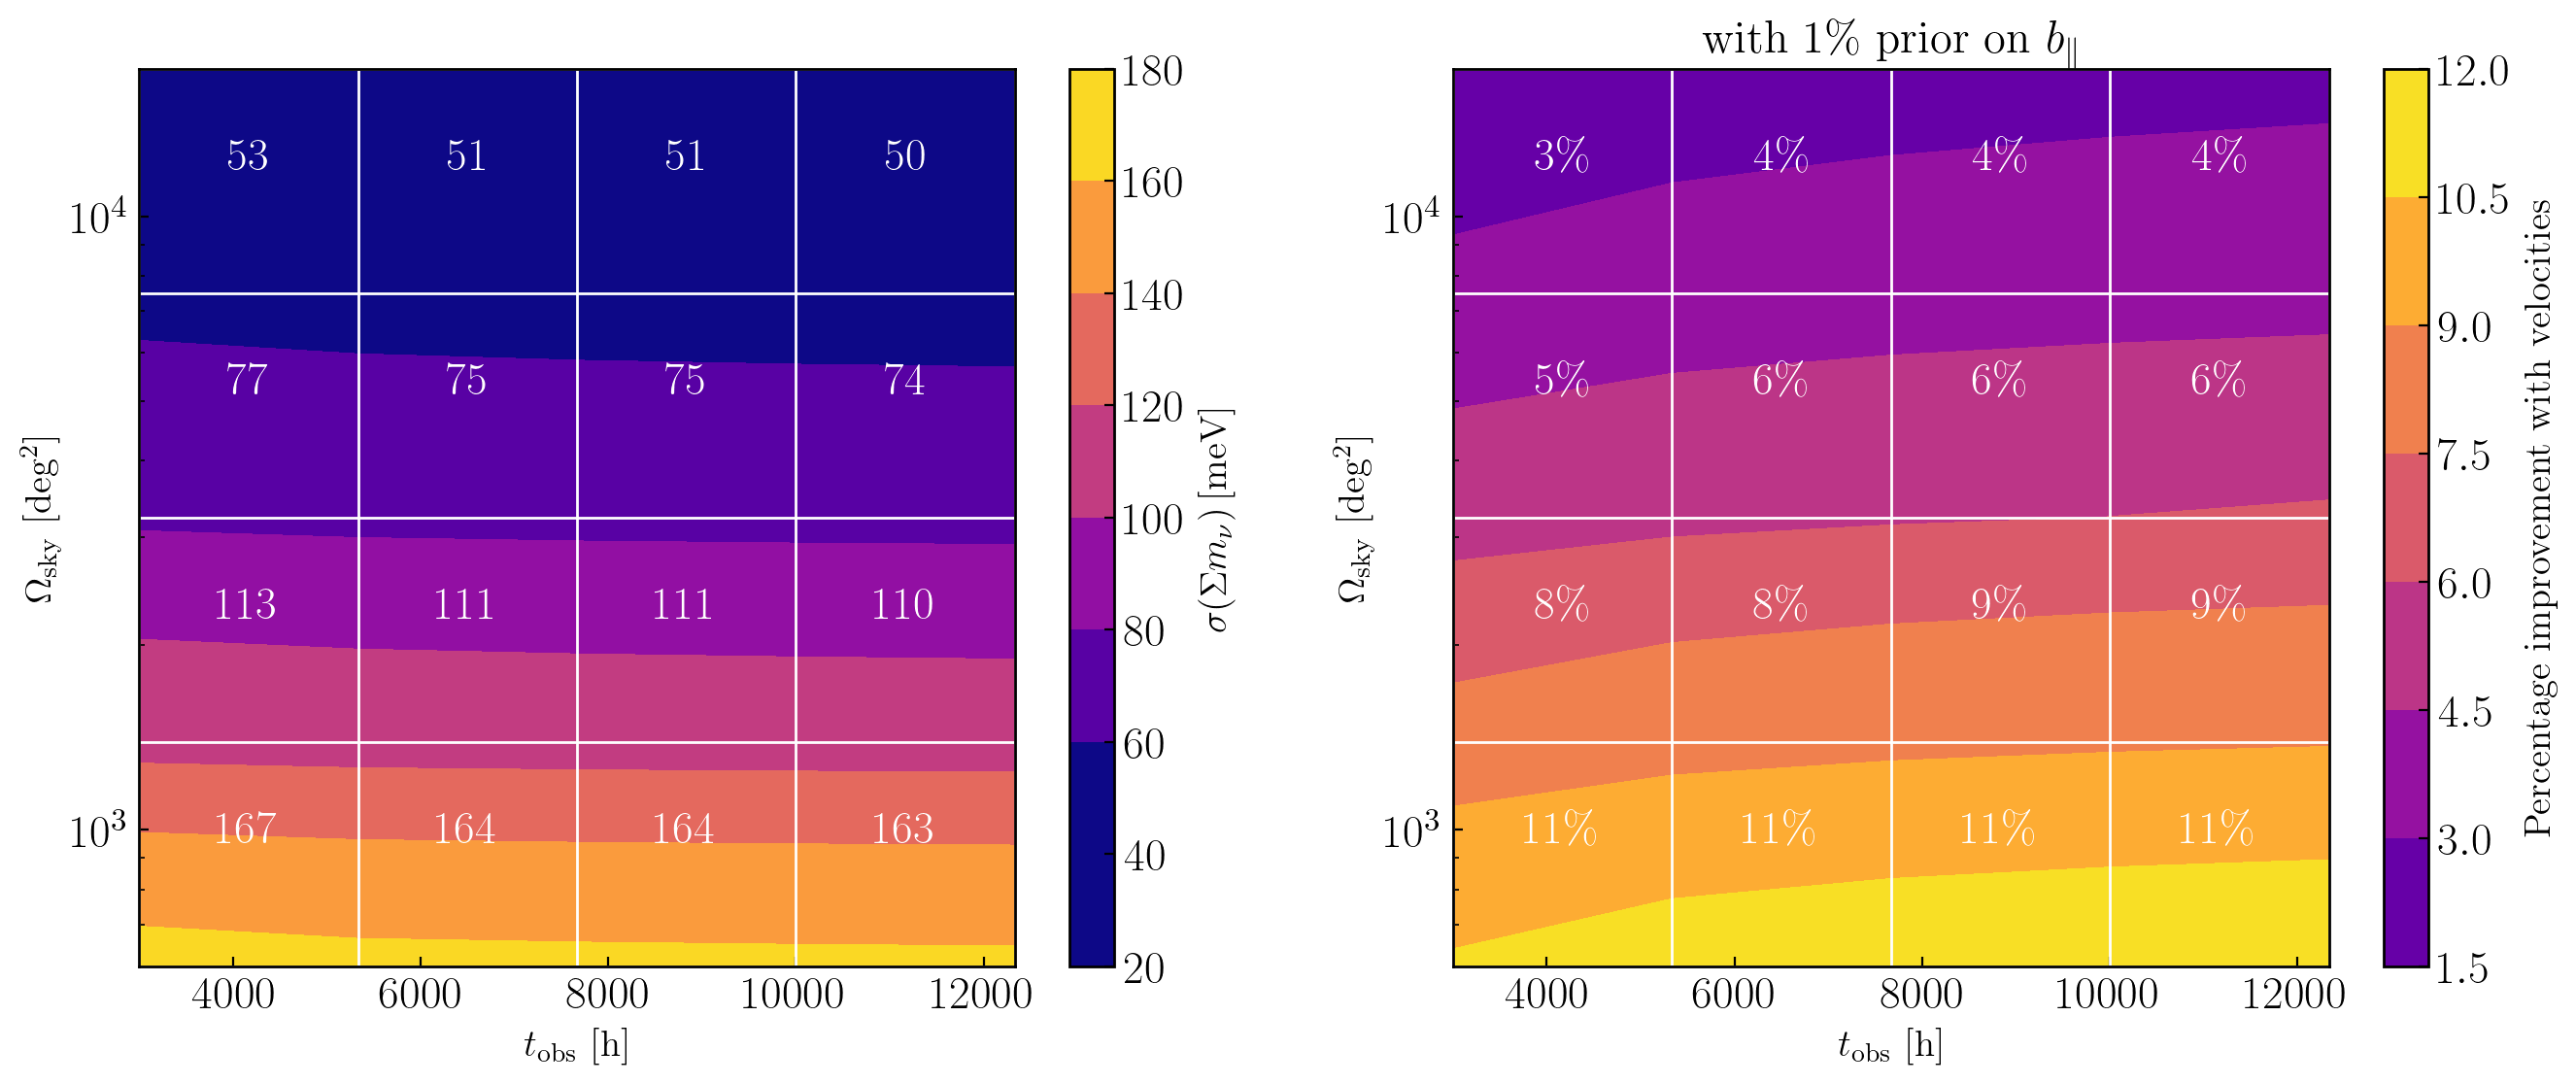

In [64]:
free_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'bv_par', 'bv_perp', 'bT']
fixed_params = ['bv_par', 'bv_perp']

sig_mnu_grid = np.zeros((len(Omegas), len(tobss)))
sig_mnu_vel_grid = np.zeros((len(Omegas), len(tobss)))
sig_mnu_vel_pr_grid = np.zeros((len(Omegas), len(tobss)))

mnu_ind = free_params.index('mnu')

for o in range(len(Omegas)):
    for t in range(len(tobss)):
        F_XX = F_XX_om_tob[o,t]
        F_vX = F_vX_om_tob[o,t]
        
        covmat_lim, cov_params = covariance_mat(F_XX, all_params, fixed_params, {})
        sig_mnu_grid[o,t] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
        covmat_lim_vel, cov_params = covariance_mat(F_vX, all_params, [], {'bv_par':0.01})
        sig_mnu_vel_grid[o,t] = np.sqrt(covmat_lim_vel[mnu_ind,mnu_ind])


xx = sig_mnu_grid*1e3
vx = sig_mnu_vel_grid*1e3


plt.figure(figsize=(16,6))
plt.subplot(1,2,1)

plt.contourf(tobss, Omegas, xx, cmap='plasma', vmin=50, vmax=180)
plt.colorbar(label=r'$\sigma(\Sigma m_\nu) \, \textrm{[meV]}$')#, ticks=np.linspace(50, 400, 5))

# Calculate the positions for the grid lines
tobs_midpoints = (tobss[:-1] + tobss[1:]) / 2
omega_midpoints = (Omegas[:-1] + Omegas[1:]) / 2

# Add horizontal and vertical lines manually
for t in tobss:
    plt.axvline(t, color='white', linestyle='-', linewidth=1)
for o in Omegas:
    plt.axhline(o, color='white', linestyle='-', linewidth=1)

# Add text labels with condition to exclude the first and last rows and columns
for i, tobs in enumerate(tobs_midpoints):
    for j, omega in enumerate(omega_midpoints):
        plt.text(tobs, omega, f'{xx[j, i]:.0f}', ha='center', va='center', color='white', fontsize=17)

plt.xlabel(r'$t_\mathrm{obs}$ [h]')
plt.ylabel(r'$\Omega_\mathrm{sky}$ [deg$^2$]')
plt.yscale('log')
plt.xlim(tobss[0], tobss[-1])
plt.ylim(Omegas[0], Omegas[-1])



plt.subplot(1,2,2)

plt.contourf(tobss, Omegas, (xx-vx)/xx*100, cmap='plasma', vmin=0, vmax=12)
plt.colorbar(label='Percentage improvement with velocities')

# Calculate the positions for the grid lines
tobs_midpoints = (tobss[:-1] + tobss[1:]) / 2
omega_midpoints = (Omegas[:-1] + Omegas[1:]) / 2

# Add horizontal and vertical lines manually
for t in tobss:
    plt.axvline(t, color='white', linestyle='-', linewidth=1)
for o in Omegas:
    plt.axhline(o, color='white', linestyle='-', linewidth=1)

# Add text labels with condition to exclude the first and last rows and columns
for i, tobs in enumerate(tobs_midpoints):
    for j, omega in enumerate(omega_midpoints):
        plt.text(tobs, omega, f'{((xx-vx)/xx*100)[j, i]:.0f}\%', ha='center', va='center', color='white', fontsize=17)

plt.xlabel(r'$t_\mathrm{obs}$ [h]')
plt.ylabel(r'$\Omega_\mathrm{sky}$ [deg$^2$]')
plt.title(r'with 1\% prior on $b_\parallel$')
plt.yscale('log')
plt.xlim(tobss[0], tobss[-1])
plt.ylim(Omegas[0], Omegas[-1])

Test how cconstraints change when increasing $\sigma_\mathrm{pix}$ and $\theta_\mathrm{FWHM}$

In [65]:
cosmo_model_params['cosmo_input_camb'] = cosmo_params
m = update_Pkline(obs_params,cosmo_model_params)[0]

zs = np.arange(1.5, 4.51, 1)

deltas= [1e-2,1e-2,-1e-2,1e-2,1e-2,3e-1,3e-1,1e-2,1e-2,1e-2,1e-2]
free_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'bv_par', 'bv_perp', 'bT']
fixed_params = ['bv_par', 'bv_perp']

Fz_XX_sigpix=np.zeros((len(zs),len(free_params),len(free_params)))
Fz_vX_sigpix=np.zeros((len(zs),len(free_params),len(free_params)))
for i in range(len(zs)):
    cosmo_model_params, obs_params = lim_params('CII', downgrade=False)
    nu, Dnu = Dnu_from_Dz(m.nu, zs[i], 1)
    cosmo_model_params['nuObs'] = nu
    obs_params['Delta_nu'] = Dnu
    obs_params['dnu'] = (nu/R).to(u.MHz)
    obs_params['beam_FWHM'] = beam[i]
    obs_params['sigma_pix'] = sigpix[i]*10
    m = update_Pkline(obs_params,cosmo_model_params)[0]
    bias_params['bT'] = (m.bavg[0]*m.Tmean).value
    print(m.z, m.nuObs, m.Delta_nu, m.beam_FWHM, m.sigma_N)
    
    vol = m.Vfield
    k_large = (k_fid[(k_fid >= np.pi/vol**(1/3))&(k_fid.value <= 0.1)])
    xx,vx = Fisher_mat(m, cosmo_params, bias_params, free_params, deltas, k_large, vol, Delta_T_S4)
    Fz_XX_sigpix[i,:,:]=xx
    Fz_vX_sigpix[i,:,:]=vx


Note: redshifts have been re-sorted (earliest first)
1.5 760.2156 GHz 316.75649999999996 GHz 2.0 arcsec 3897100.0 Jy / sr
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this i



Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt

In [66]:
lcdm_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'bv_par', 'bv_perp']
bT_params = ['bT0', 'bT1', 'bT2', 'bT3']
all_params = lcdm_params + bT_params
Nparams = len(all_params)

# Function to map parameter names to indices in the combined Fisher matrix
def get_param_indices(all_params):
    return {param: idx for idx, param in enumerate(all_params)}

F_XX_sigpix = np.zeros((Nparams, Nparams))
F_vX_sigpix = np.zeros((Nparams, Nparams))
# Get the parameter indices for the combined Fisher matrix
param_indices = get_param_indices(all_params)

bT_ind = free_params.index('bT')

# Add each individual Fisher matrix to the combined Fisher matrix
for i, F in enumerate(Fz_XX_sigpix):
    # Indices for the LCDM parameters
    for j, param1 in enumerate(lcdm_params):
        for k, param2 in enumerate(lcdm_params):
            F_XX_sigpix[param_indices[param1], param_indices[param2]] += F[j, k]

    # Indices for the LCDM parameters and bg parameter for this redshift bin
    bT_param = f'bT{i}'
    for j, param1 in enumerate(lcdm_params):
        F_XX_sigpix[param_indices[param1], param_indices[bT_param]] += F[j, bT_ind]
        F_XX_sigpix[param_indices[bT_param], param_indices[param1]] += F[bT_ind, j]

    # Index for the bg parameter for this redshift bin
    F_XX_sigpix[param_indices[bT_param], param_indices[bT_param]] += F[bT_ind, bT_ind]

# Add each individual Fisher matrix to the combined Fisher matrix
for i, F in enumerate(Fz_vX_sigpix):
    # Indices for the LCDM parameters
    for j, param1 in enumerate(lcdm_params):
        for k, param2 in enumerate(lcdm_params):
            F_vX_sigpix[param_indices[param1], param_indices[param2]] += F[j, k]

    # Indices for the LCDM parameters and bg parameter for this redshift bin
    bT_param = f'bT{i}'
    for j, param1 in enumerate(lcdm_params):
        F_vX_sigpix[param_indices[param1], param_indices[bT_param]] += F[j, bT_ind]
        F_vX_sigpix[param_indices[bT_param], param_indices[param1]] += F[bT_ind, j]

    # Index for the bg parameter for this redshift bin
    F_vX_sigpix[param_indices[bT_param], param_indices[bT_param]] += F[bT_ind, bT_ind]

    
    
print('LIM:')
covmat_lim, cov_params = covariance_mat(F_XX_sigpix, all_params, fixed_params, {})
print_1_sigmas(covmat_lim,cov_params)
print('\n LIM+kSZ:')
covmat_lim_kSZ, cov_params = covariance_mat(F_vX_sigpix, all_params, [], {'bv_par':0.01})
print_1_sigmas(covmat_lim_kSZ,cov_params)



LIM:


1-sigma of H0 is 6.3847102947724155
1-sigma of ombh2 is 0.00033323951164347795
1-sigma of omch2 is 0.0011500488622655262
1-sigma of ns is 0.010297202918223954
1-sigma of As is 2.5940846569404183e-10
1-sigma of tau is 59.35490880409692
1-sigma of mnu is 0.10556116135804014
1-sigma of bT0 is 49.33024380430508
1-sigma of bT1 is 82.33642121936094
1-sigma of bT2 is 181.3128534296718
1-sigma of bT3 is 380.57561210220723

 LIM+kSZ:


1-sigma of H0 is 6.363646802239764
1-sigma of ombh2 is 0.00033266502201690506
1-sigma of omch2 is 0.0011323969061961437
1-sigma of ns is 0.009969636286150019
1-sigma of As is 2.3774593651151227e-10
1-sigma of tau is 54.14363253884276
1-sigma of mnu is 0.10400469745988826
1-sigma of bv_par is 0.009100763485110037
1-sigma of bv_perp is 0.26337527866907195
1-sigma of bT0 is 49.09008538514834
1-sigma of bT1 is 78.85055570639841
1-sigma of bT2 is 170.99071002866194
1-sigma of bT3 is 355.213306100879


In [43]:
cosmo_model_params['cosmo_input_camb'] = cosmo_params
m = update_Pkline(obs_params,cosmo_model_params)[0]

zs = np.arange(1.5, 4.51, 1)

deltas= [1e-2,1e-2,-1e-2,1e-2,1e-2,3e-1,3e-1,1e-2,1e-2,1e-2,1e-2]
free_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'bv_par', 'bv_perp', 'bT']
fixed_params = ['bv_par', 'bv_perp']

Fz_XX_beam=np.zeros((len(zs),len(free_params),len(free_params)))
Fz_vX_beam=np.zeros((len(zs),len(free_params),len(free_params)))
for i in range(len(zs)):
    cosmo_model_params, obs_params = lim_params('CII', downgrade=False)
    nu, Dnu = Dnu_from_Dz(m.nu, zs[i], 1)
    cosmo_model_params['nuObs'] = nu
    obs_params['Delta_nu'] = Dnu
    obs_params['dnu'] = (nu/R).to(u.MHz)
    obs_params['beam_FWHM'] = beam[i]*10
    obs_params['sigma_pix'] = sigpix[i]
    m = update_Pkline(obs_params,cosmo_model_params)[0]
    bias_params['bT'] = (m.bavg[0]*m.Tmean).value
    print(m.z, m.nuObs, m.Delta_nu, m.beam_FWHM, m.sigma_N)
    
    vol = m.Vfield
    k_large = (k_fid[(k_fid >= np.pi/vol**(1/3))&(k_fid.value <= 0.1)])
    xx,vx = Fisher_mat(m, cosmo_params, bias_params, free_params, deltas, k_large, vol, Delta_T_S4)
    Fz_XX_beam[i,:,:]=xx
    Fz_vX_beam[i,:,:]=vx


Note: redshifts have been re-sorted (earliest first)
1.5 760.2156 GHz 316.75649999999996 GHz 20.0 arcsec 38970.0 Jy / sr
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is



Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt

In [45]:
lcdm_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'bv_par', 'bv_perp']
bT_params = ['bT0', 'bT1', 'bT2', 'bT3']
all_params = lcdm_params + bT_params
Nparams = len(all_params)

# Function to map parameter names to indices in the combined Fisher matrix
def get_param_indices(all_params):
    return {param: idx for idx, param in enumerate(all_params)}

F_XX_beam = np.zeros((Nparams, Nparams))
F_vX_beam = np.zeros((Nparams, Nparams))
# Get the parameter indices for the combined Fisher matrix
param_indices = get_param_indices(all_params)

bT_ind = free_params.index('bT')

# Add each individual Fisher matrix to the combined Fisher matrix
for i, F in enumerate(Fz_XX_beam):
    # Indices for the LCDM parameters
    for j, param1 in enumerate(lcdm_params):
        for k, param2 in enumerate(lcdm_params):
            F_XX_beam[param_indices[param1], param_indices[param2]] += F[j, k]

    # Indices for the LCDM parameters and bg parameter for this redshift bin
    bT_param = f'bT{i}'
    for j, param1 in enumerate(lcdm_params):
        F_XX_beam[param_indices[param1], param_indices[bT_param]] += F[j, bT_ind]
        F_XX_beam[param_indices[bT_param], param_indices[param1]] += F[bT_ind, j]

    # Index for the bg parameter for this redshift bin
    F_XX_beam[param_indices[bT_param], param_indices[bT_param]] += F[bT_ind, bT_ind]

# Add each individual Fisher matrix to the combined Fisher matrix
for i, F in enumerate(Fz_vX_beam):
    # Indices for the LCDM parameters
    for j, param1 in enumerate(lcdm_params):
        for k, param2 in enumerate(lcdm_params):
            F_vX_beam[param_indices[param1], param_indices[param2]] += F[j, k]

    # Indices for the LCDM parameters and bg parameter for this redshift bin
    bT_param = f'bT{i}'
    for j, param1 in enumerate(lcdm_params):
        F_vX_beam[param_indices[param1], param_indices[bT_param]] += F[j, bT_ind]
        F_vX_beam[param_indices[bT_param], param_indices[param1]] += F[bT_ind, j]

    # Index for the bg parameter for this redshift bin
    F_vX_beam[param_indices[bT_param], param_indices[bT_param]] += F[bT_ind, bT_ind]

    
    
print('LIM:')
covmat_lim, cov_params = covariance_mat(F_XX_beam, all_params, fixed_params, {})
print_1_sigmas(covmat_lim,cov_params)
print('\n LIM+kSZ:')
covmat_lim_kSZ, cov_params = covariance_mat(F_vX_beam, all_params, [], {'bv_par':0.01})
print_1_sigmas(covmat_lim_kSZ,cov_params)



LIM:


1-sigma of H0 is 1.71284061876597
1-sigma of ombh2 is 0.0001686117601824087
1-sigma of omch2 is 0.00056338495221903
1-sigma of ns is 0.00542749928084028
1-sigma of As is 4.8443919943103995e-11
1-sigma of tau is 3.082106028209511
1-sigma of mnu is 0.05113215545918635
1-sigma of bT0 is 12.396597406321673
1-sigma of bT1 is 20.805367035578488
1-sigma of bT2 is 36.364757993290205
1-sigma of bT3 is 61.92918986222779

 LIM+kSZ:


1-sigma of H0 is 1.6737527800534415
1-sigma of ombh2 is 0.00016838799258678453
1-sigma of omch2 is 0.0005541079725673733
1-sigma of ns is 0.00520644385556174
1-sigma of As is 4.7670877443732475e-11
1-sigma of tau is 3.0671828810362602
1-sigma of mnu is 0.04948558004762952
1-sigma of bv_par is 0.004826237283554035
1-sigma of bv_perp is 0.03261421757428154
1-sigma of bT0 is 12.169081451991351
1-sigma of bT1 is 20.142927051166954
1-sigma of bT2 is 35.70383558378826
1-sigma of bT3 is 61.302543423701046


## Downgrade AtLAST experiment
The tests to determine which specs to use are below. We chose to use these specs so that the results are comparable with the ones for galaxy survey VRO10. This will give us an early-AtLAST experiment since the results will be available sooner (not necessarily less instrumental noise since we observe smaller sky area).

In [41]:

down = True
cosmo_model_params, obs_params = lim_params('CII',down)
m = update_Pkline(obs_params,cosmo_model_params)[0]

nu, Dnu = Dnu_from_Dz(m.nu, zs[0], 1)
cosmo_model_params['nuObs'] = nu
obs_params['Delta_nu'] = Dnu
obs_params['dnu'] = (nu/R).to(u.MHz)
obs_params['beam_FWHM'] = beam[0]
obs_params['sigma_pix'] = sigpix[0]
m = update_Pkline(obs_params,cosmo_model_params)[0]

k_large = (m.k[(m.k.value <= 0.1)])

print(m.Omega_field, m.tobs)
print(m.sigma_N, m.Pnoise)

600.0 deg2 3000.0 h
Note: redshifts have been re-sorted (earliest first)
201242.3963366898 Jy / sr 359702675.5013925 Jy2 Mpc3 / sr2


Note: redshifts have been re-sorted (earliest first)


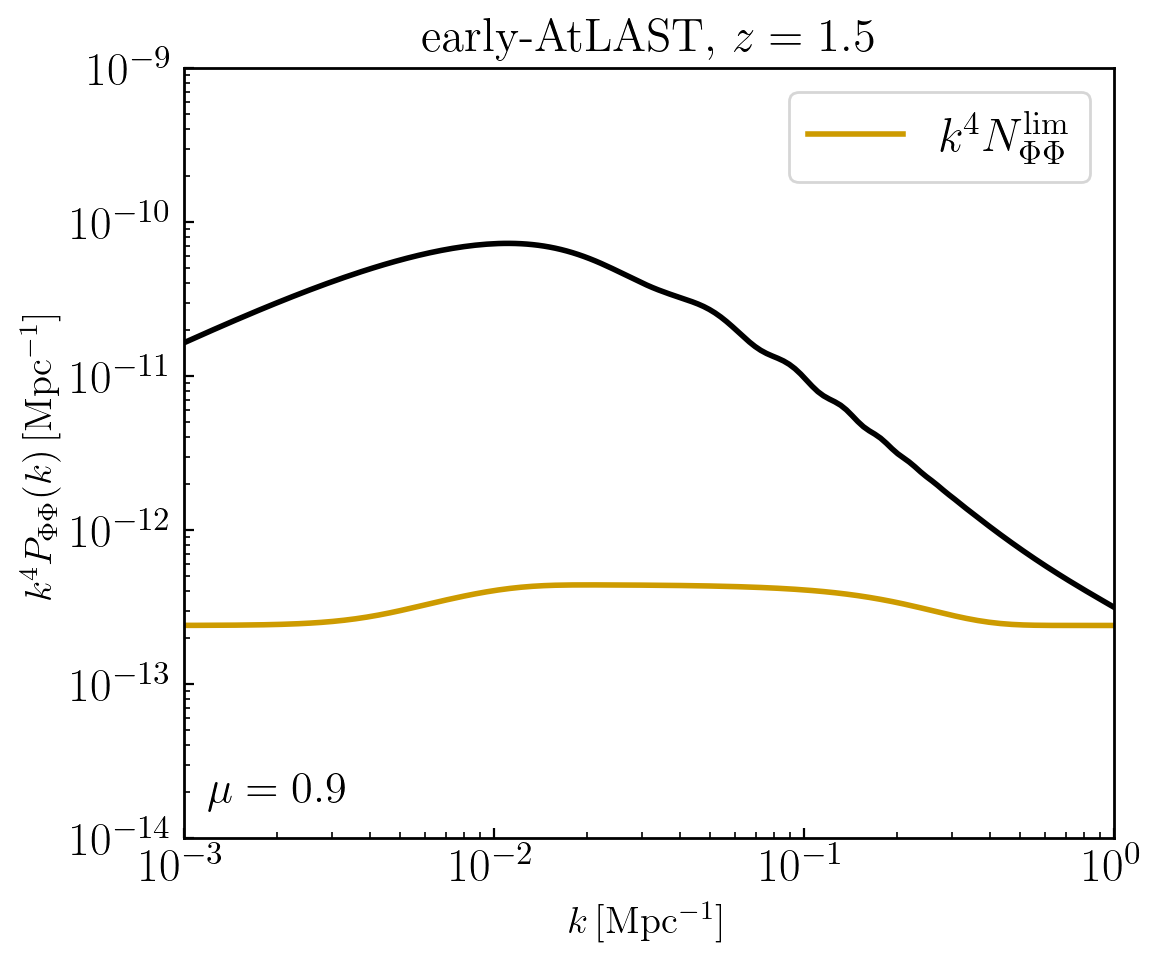

In [39]:
N_xx = m.Pshot*m.Wk + m.Pnoise

zcosmo = np.linspace(0.,15.,101)
cosmo1 = (m.cosmo_input_camb).copy()
cosmo1.pop('f_NL')
camb_pars = camb.set_params(**cosmo1)
camb_pars.set_matter_power(redshifts=list(zcosmo))
cosmo = camb.get_results(camb_pars)
H = lambda z: cosmo.hubble_parameter(z)/(cu.c.to(u.km/u.s)).value  # 1/Mpc    
omegam = (camb_pars.ombh2 + camb_pars.omch2 + camb_pars.omnuh2) / (camb_pars.H0 / 100) ** 2
rhoM0 = 3*omegam*H(0.)**2 # Mpc^-2

noise_pot = ((1+m.z)*rhoM0/2)**2/((m.k)**4 * (m.bavg[0]*m.Tmean)**2)*N_xx # Mpc^3

interp_Pphiphi = camb.get_matter_power_interpolator(camb_pars, zmin=0, zmax=zcosmo[-1], nz_step=150, zs=None, kmax=max(m.k.value), nonlinear=True,var1=camb.model.Transfer_Weyl, var2=camb.model.Transfer_Weyl, hubble_units=False, 
                                                    k_hunit=False, return_z_k=False, k_per_logint=None, log_interp=False,  extrap_kmax=True).P  # Mpc^-1


plt.loglog(m.k, interp_Pphiphi(m.z, m.k.value), 'k')
plt.loglog(m.k, m.k**4*noise_pot[190,:], label=r'$k^4 N_{\Phi\Phi}^{\mathrm{lim}}$', color=palette[1])
plt.xlim(1e-3,1e0)
plt.ylim(1e-14,1e-9)
#plt.ylim(1e-14,1e2)
plt.title(r'early-AtLAST, $z=%g$'%m.z)
plt.xlabel(r'$k\,[{\rm Mpc^{-1}}]$')
plt.ylabel(r'$k^4 P_{\Phi \Phi}(k)\,[{\rm Mpc^{-1}}]$')
plt.text(1.2e-3, 1.5e-14, r'$\mu=%g$'%np.round(m.mu[190],1), fontsize=16, ha='left', va='bottom', color='black', alpha=1)
plt.legend()

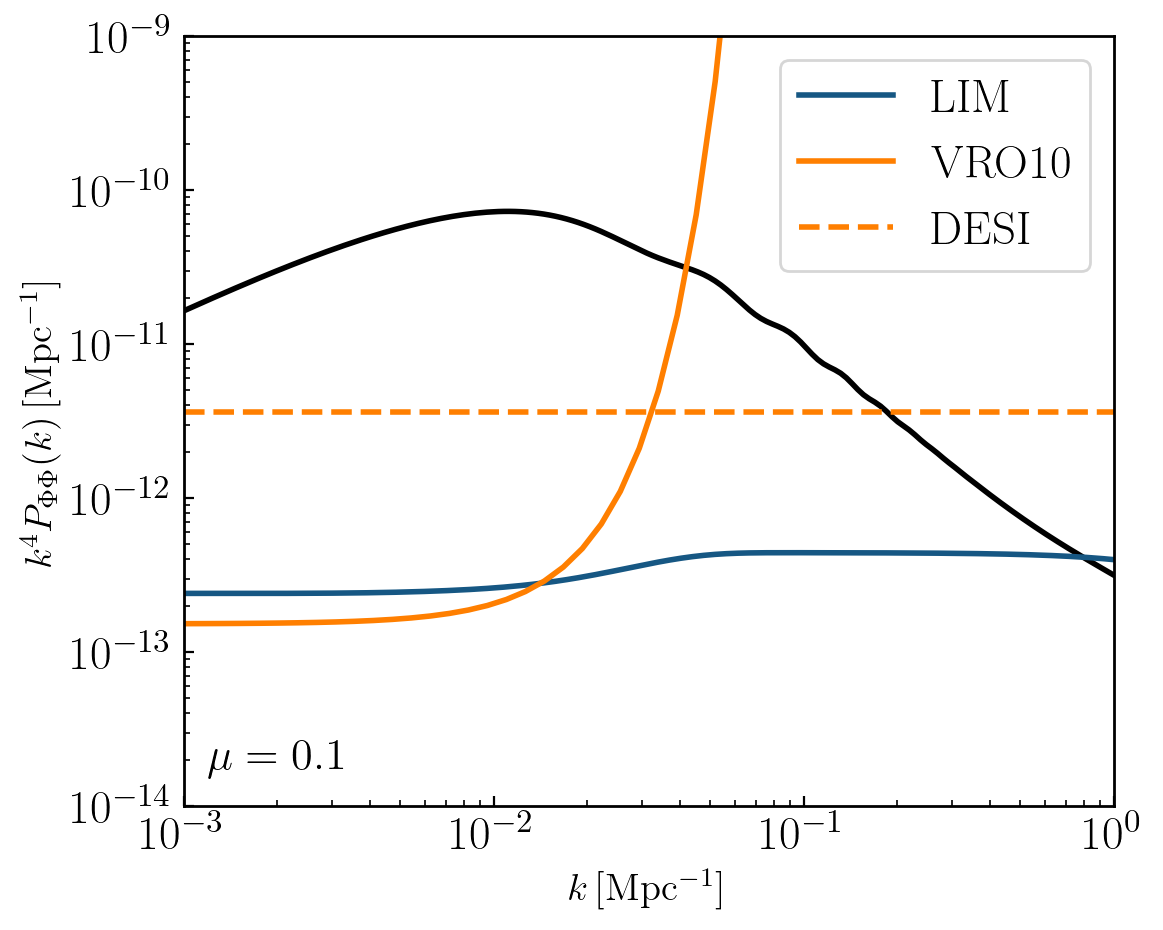

In [40]:
vm_root = '/media/HostShared/galaxies/'

noise_pot_VRO10 = np.loadtxt(vm_root+'noise_pot_VRO10_01.txt')
noise_pot_DESI = np.loadtxt(vm_root+'noise_pot_DESI_01.txt')
k_vec_VRO10 = np.loadtxt(vm_root+'kvec_noise_pot.txt')

plt.loglog(m.k, interp_Pphiphi(m.z, m.k.value), 'k')
plt.loglog(m.k, m.k**4*noise_pot[110,:], label=r'LIM', color=palette[0])
plt.loglog(k_vec_VRO10, noise_pot_VRO10, label=r'VRO10', color=palette[6])
plt.loglog(k_vec_VRO10, noise_pot_DESI, ls='--', label=r'DESI', color=palette[6])


plt.xlim(1e-3,1e0)
plt.ylim(1e-14,1e-9)
plt.xlabel(r'$k\,[{\rm Mpc^{-1}}]$')
plt.ylabel(r'$k^4 P_{\Phi \Phi}(k)\,[{\rm Mpc^{-1}}]$')
plt.text(1.2e-3, 1.5e-14, r'$\mu=%g$'%np.round(m.mu[110],1), fontsize=16, ha='left', va='bottom', color='black', alpha=1)
plt.legend()

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Text(0.0019, 0.05, '$\\mu=0.9$')

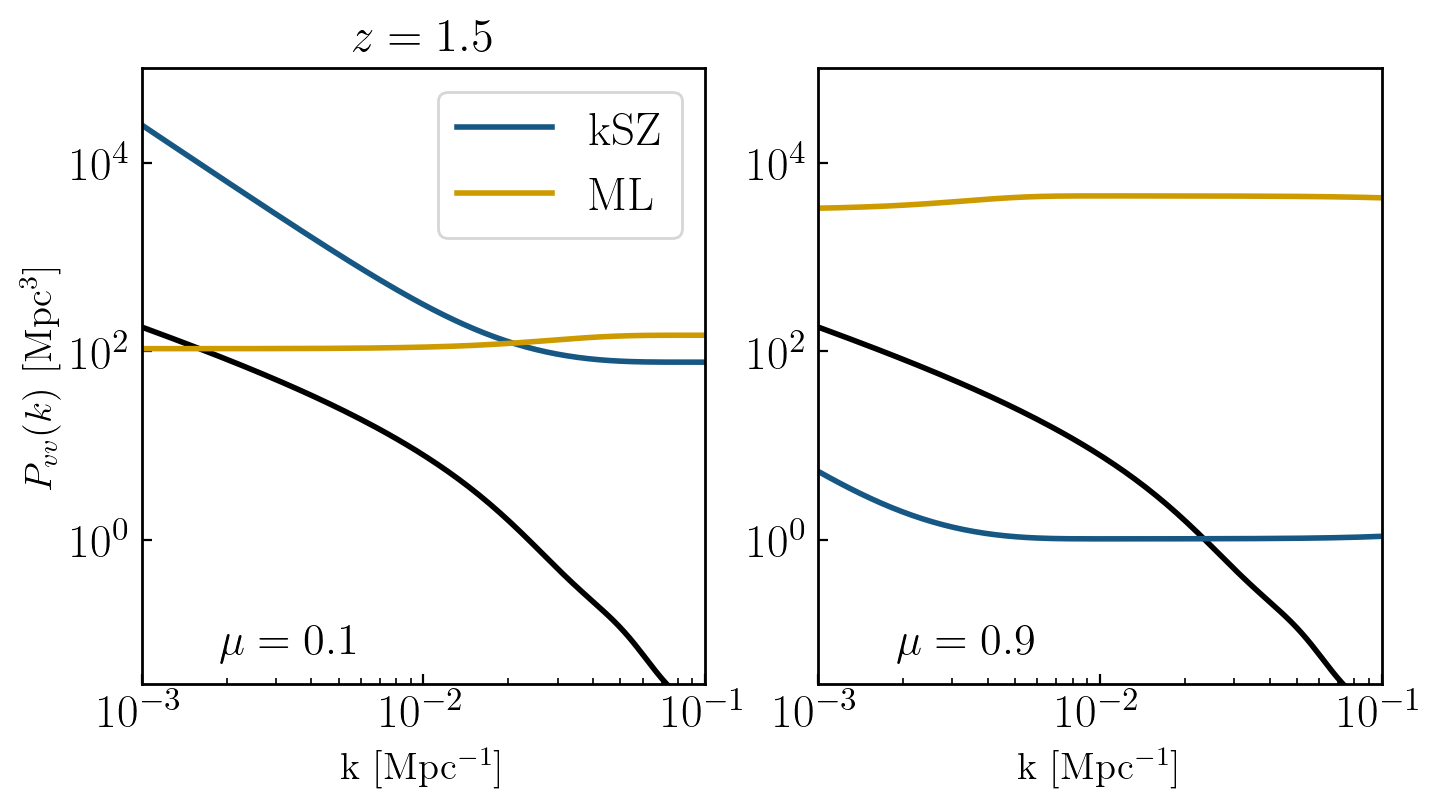

In [42]:
_,_,_,Pvpar,Pvperp,_ = get_powers(m, k_large)
Pvv = Pvpar+Pvperp

# Need to turn on the 1-halo flag for the noise calulation (for others we leave it off)
cosmo_model_params['do_onehalo'] = True
m = update_Pkline(obs_params,cosmo_model_params)[0]
_,Nvv_par,Nvv_perp = get_noises(m, k_large, Delta_T_S4)
cosmo_model_params['do_onehalo'] = False
m = update_Pkline(obs_params,cosmo_model_params)[0]

Nvv_kSZ = mu_L**-2 * Nvv_par
Nvv_ML = (np.sqrt(1-mu_L**2))**-2 * Nvv_perp



plt.figure(figsize=(8,4))
plt.subplot(1,2,1)

plt.loglog(k_large, Pvv[:,0], 'k')
plt.loglog(k_large, Nvv_kSZ[:,110], color=palette[0], label='kSZ')
plt.loglog(k_large, Nvv_ML[:,110], color=palette[1], label='ML')
plt.title(r'$z=%g$'%m.z)
plt.xlim(1e-3, 1e-1)
plt.ylim(3e-2,1e5)
#plt.legend(ncol=1, handlelength=1, labelspacing=0,handletextpad=0.3, mode='expand')
plt.legend(loc='upper right')
plt.xlabel('k [Mpc$^{-1}$]')
plt.ylabel(r'$P_{vv}(k)$ [Mpc$^3$]')
plt.text(1.9e-3, 5e-2, r'$\mu=%g$'%np.round(mu_L[110],1), fontsize=16, ha='left', va='bottom', color='black', alpha=1)
#plt.grid(linestyle='dotted')

plt.subplot(1,2,2)
plt.loglog(k_large, Pvv[:,0], 'k')
plt.loglog(k_large, Nvv_kSZ[:,190], color=palette[0])
plt.loglog(k_large, Nvv_ML[:,190], color=palette[1])
#plt.title(r'$\mu=0.9$')
plt.xlim(1e-3, 1e-1)
plt.ylim(3e-2,1e5)
plt.xlabel('k [Mpc$^{-1}$]')
plt.text(1.9e-3, 5e-2, r'$\mu=%g$'%np.round(mu_L[190],1), fontsize=16, ha='left', va='bottom', color='black', alpha=1)
#plt.grid(linestyle='dotted')

In [43]:
vm_root = '/media/HostShared/galaxies/'

Nvv_VRO10_kSZ = np.loadtxt(vm_root+'Nvv_VRO10_kSZ.txt')
Nvv_DESI_kSZ = np.loadtxt(vm_root+'Nvv_DESI_kSZ.txt')
k_large_VRO10 = np.loadtxt(vm_root+'k_large_VRO10.txt')
mu_L_VRO10 = np.loadtxt(vm_root+'mu_L_VRO10.txt')

Text(0.0019, 0.02, '$\\mu=0.9$')

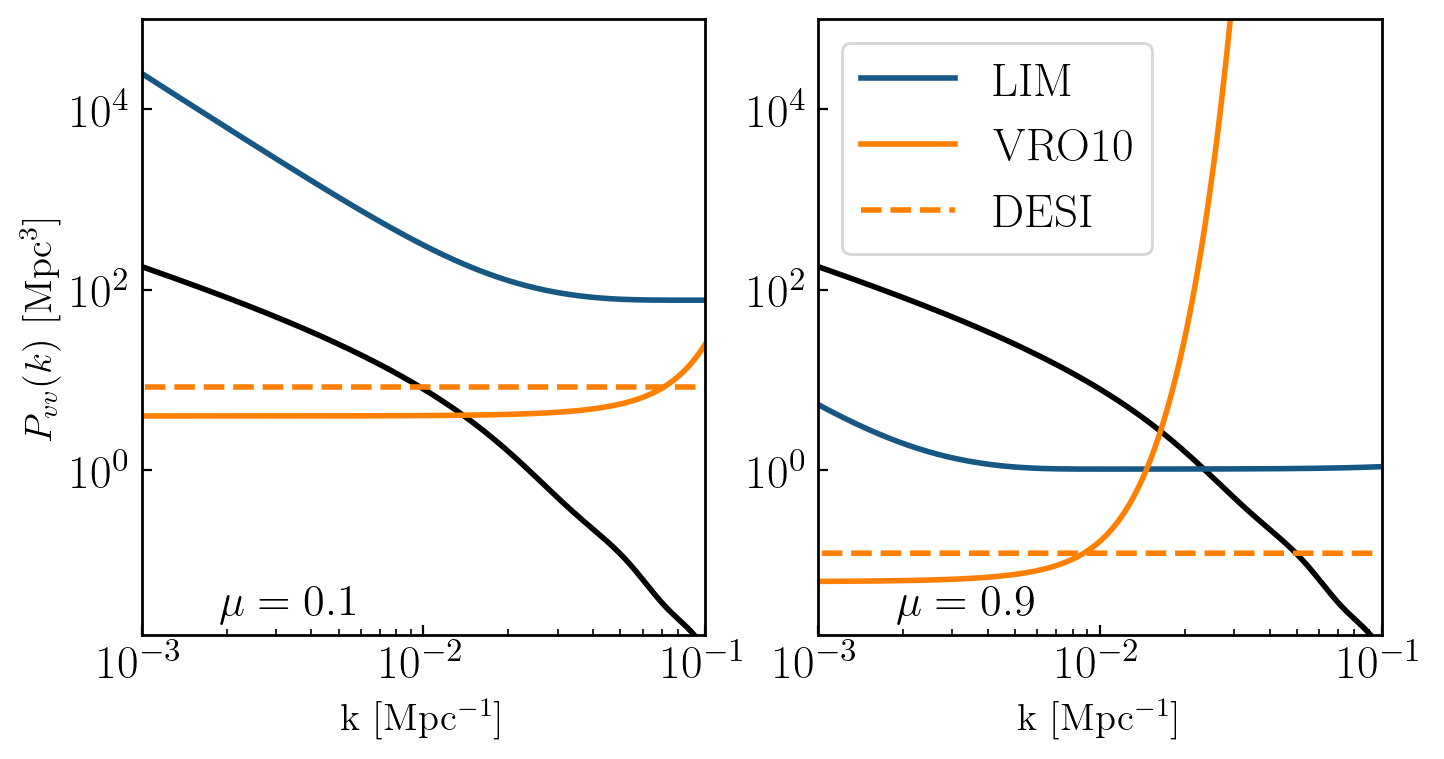

In [44]:


plt.figure(figsize=(8,4))
plt.subplot(1,2,1)

plt.loglog(k_large, Pvv[:,0], 'k')
plt.loglog(k_large, Nvv_kSZ[:,110], color=palette[0], label='LIM')
plt.loglog(k_large_VRO10, Nvv_VRO10_kSZ[:,55], color=palette[6], label='VRO10')
plt.loglog(k_large_VRO10, Nvv_DESI_kSZ[:,55], color=palette[6], ls='--', label='DESI')
#plt.title(r'$z=%g$'%m.z)
plt.xlim(1e-3, 1e-1)
plt.ylim(1.5e-2,1e5)
plt.xlabel('k [Mpc$^{-1}$]')
plt.ylabel(r'$P_{vv}(k)$ [Mpc$^3$]')
plt.text(1.9e-3, 2e-2, r'$\mu=%g$'%np.round(mu_L[110],1), fontsize=16, ha='left', va='bottom', color='black', alpha=1)
#plt.grid(linestyle='dotted')
plt.subplot(1,2,2)
plt.loglog(k_large, Pvv[:,0], 'k')
plt.loglog(k_large, Nvv_kSZ[:,190], color=palette[0], label='LIM')
plt.loglog(k_large_VRO10, Nvv_VRO10_kSZ[:,95], color=palette[6], label='VRO10')
plt.loglog(k_large_VRO10, Nvv_DESI_kSZ[:,95], color=palette[6], ls='--', label='DESI')
plt.legend(loc='upper left')

plt.xlim(1e-3, 1e-1)
plt.ylim(1.5e-2,1e5)
plt.xlabel('k [Mpc$^{-1}$]')
plt.text(1.9e-3, 2e-2, r'$\mu=%g$'%np.round(mu_L[190],1), fontsize=16, ha='left', va='bottom', color='black', alpha=1)


Text(0.0019, 0.02, '$\\mu=0.9$')

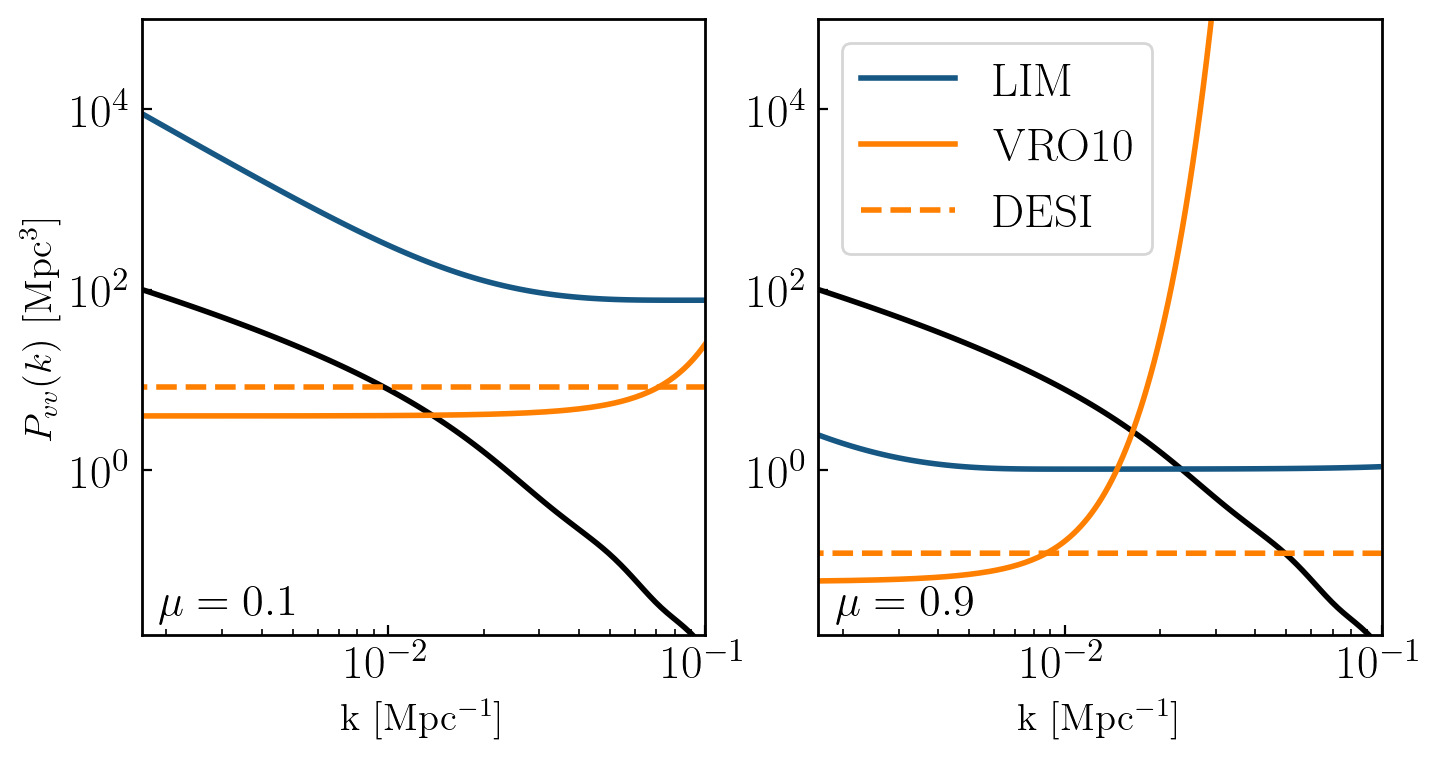

In [54]:


plt.figure(figsize=(8,4))
plt.subplot(1,2,1)

plt.loglog(k_large, Pvv[:,0], 'k')
plt.loglog(k_large, Nvv_kSZ[:,110], color=palette[0], label='LIM')
plt.loglog(k_large_VRO10, Nvv_VRO10_kSZ[:,55], color=palette[6], label='VRO10')
plt.loglog(k_large_VRO10, Nvv_DESI_kSZ[:,55], color=palette[6], ls='--', label='DESI')
#plt.title(r'$z=%g$'%m.z)
#plt.xlim(1e-3, 5e-2)
plt.xlim(k_large[0].value, 1e-1)
plt.ylim(1.5e-2,1e5)
#plt.legend(ncol=1, handlelength=1, labelspacing=0,handletextpad=0.3, mode='expand')
plt.xlabel('k [Mpc$^{-1}$]')
plt.ylabel(r'$P_{vv}(k)$ [Mpc$^3$]')
plt.text(1.9e-3, 2e-2, r'$\mu=%g$'%np.round(mu_L[110],1), fontsize=16, ha='left', va='bottom', color='black', alpha=1)
#plt.grid(linestyle='dotted')

plt.subplot(1,2,2)
plt.loglog(k_large, Pvv[:,0], 'k')
plt.loglog(k_large, Nvv_kSZ[:,190], color=palette[0], label='LIM')
plt.loglog(k_large_VRO10, Nvv_VRO10_kSZ[:,95], color=palette[6], label='VRO10')
plt.loglog(k_large_VRO10, Nvv_DESI_kSZ[:,95], color=palette[6], ls='--', label='DESI')
plt.legend(loc='upper left')

#plt.title(r'$\mu=0.9$')
#plt.xlim(1e-3, 5e-2)
plt.xlim(k_large[0].value, 1e-1)
plt.ylim(1.5e-2,1e5)
plt.xlabel('k [Mpc$^{-1}$]')
plt.text(1.9e-3, 2e-2, r'$\mu=%g$'%np.round(mu_L[190],1), fontsize=16, ha='left', va='bottom', color='black', alpha=1)
#plt.grid(linestyle='dotted')

Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Text(0.0004, 0.05, '$\\mu=0.9$')

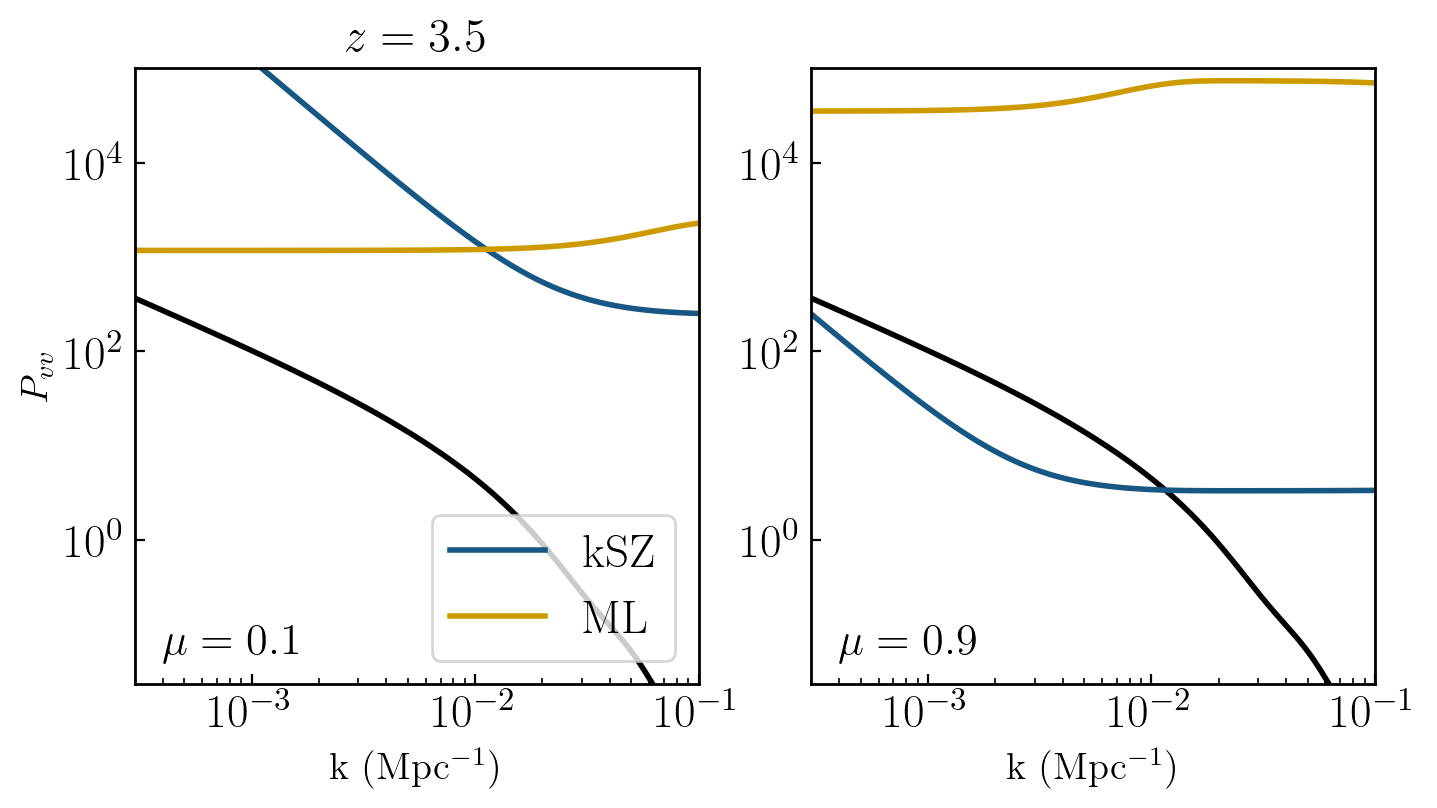

In [339]:
_,_,_,Pvpar,Pvperp,_ = get_powers(m, k_large)
Pvv = Pvpar+Pvperp

# Need to turn on the 1-halo flag for the noise calulation (for others we leave it off)
cosmo_model_params['do_onehalo'] = True
m = update_Pkline(obs_params,cosmo_model_params)[0]
_,Nvv_par,Nvv_perp = get_noises(m, k_large, Delta_T_S4)
cosmo_model_params['do_onehalo'] = False
m = update_Pkline(obs_params,cosmo_model_params)[0]

Nvv_kSZ = mu_L**-2 * Nvv_par
Nvv_ML = (np.sqrt(1-mu_L**2))**-2 * Nvv_perp



plt.figure(figsize=(8,4))
plt.subplot(1,2,1)

plt.loglog(k_large, Pvv[:,0], 'k')
plt.loglog(k_large, Nvv_kSZ[:,110], color=palette[0], label='kSZ')
plt.loglog(k_large, Nvv_ML[:,110], color=palette[1], label='ML')
plt.title(r'$z=%g$'%m.z)
#plt.xlim(1e-3, 5e-2)
plt.xlim(3e-4, 1e-1)
plt.ylim(3e-2,1e5)
#plt.legend(ncol=1, handlelength=1, labelspacing=0,handletextpad=0.3, mode='expand')
plt.legend(loc='lower right')
plt.xlabel('k (Mpc$^{-1}$)')
plt.ylabel(r'$P_{vv}$')
plt.text(4e-4, 5e-2, r'$\mu=%g$'%np.round(mu_L[110],1), fontsize=16, ha='left', va='bottom', color='black', alpha=1)
#plt.grid(linestyle='dotted')

plt.subplot(1,2,2)
plt.loglog(k_large, Pvv[:,0], 'k')
plt.loglog(k_large, Nvv_kSZ[:,190], color=palette[0])
plt.loglog(k_large, Nvv_ML[:,190], color=palette[1])
#plt.title(r'$\mu=0.9$')
#plt.xlim(1e-3, 5e-2)
plt.xlim(3e-4, 1e-1)
plt.ylim(3e-2,1e5)
plt.xlabel('k (Mpc$^{-1}$)')
plt.text(4e-4, 5e-2, r'$\mu=%g$'%np.round(mu_L[190],1), fontsize=16, ha='left', va='bottom', color='black', alpha=1)
#plt.grid(linestyle='dotted')

With redshift bins

In [49]:
cosmo_model_params['cosmo_input_camb'] = cosmo_params
cosmo_model_params, obs_params = lim_params('CII', downgrade=True)
m = update_Pkline(obs_params,cosmo_model_params)[0]

zs = np.arange(1.5, 4.51, 1)

deltas= [1e-2,1e-2,-1e-2,1e-2,1e-2,3e-1,3e-1,1e-2,1e-2,1e-2,1e-2]
free_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'bv_par', 'bv_perp', 'bT']
fixed_params = ['bv_par', 'bv_perp']

Fz_XX_LIM_down = np.zeros((len(zs),len(free_params),len(free_params)))
Fz_vX_LIM_down = np.zeros((len(zs),len(free_params),len(free_params)))
for i in range(len(zs)):
    nu, Dnu = Dnu_from_Dz(m.nu, zs[i], 1)
    cosmo_model_params['nuObs'] = nu
    obs_params['Delta_nu'] = Dnu
    obs_params['dnu'] = (nu/R).to(u.MHz)
    obs_params['beam_FWHM'] = beam[i]
    obs_params['sigma_pix'] = sigpix[i]
    m = update_Pkline(obs_params,cosmo_model_params)[0]
    bias_params['bT'] = (m.bavg[0]*m.Tmean).value
    print(m.z, m.nuObs, m.Delta_nu, m.beam_FWHM, m.sigma_N)
    
    vol = m.Vfield
    k_large = (k_fid[(k_fid.value <= 0.1)])
    xx,vx = Fisher_mat(m, cosmo_params, bias_params, free_params, deltas, k_large, vol, Delta_T_S4)

    Fz_XX_LIM_down[i,:,:] = xx
    Fz_vX_LIM_down[i,:,:] = vx


Note: redshifts have been re-sorted (earliest first)
1.5 760.2156 GHz 316.75649999999996 GHz 2.0 arcsec 201242.3963366898 Jy / sr
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns

Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re

In [50]:
lcdm_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'bv_par', 'bv_perp']
bT_params = ['bT0', 'bT1', 'bT2', 'bT3']
all_params = lcdm_params + bT_params
Nparams = len(all_params)

# Function to map parameter names to indices in the combined Fisher matrix
def get_param_indices(all_params):
    return {param: idx for idx, param in enumerate(all_params)}

F_XX_early_AtLAST = np.zeros((Nparams, Nparams))
F_vX_early_AtLAST = np.zeros((Nparams, Nparams))
# Get the parameter indices for the combined Fisher matrix
param_indices = get_param_indices(all_params)

bT_ind = free_params.index('bT')

# Add each individual Fisher matrix to the combined Fisher matrix
for i, F in enumerate(Fz_XX_LIM_down):
    # Indices for the LCDM parameters
    for j, param1 in enumerate(lcdm_params):
        for k, param2 in enumerate(lcdm_params):
            F_XX_early_AtLAST[param_indices[param1], param_indices[param2]] += F[j, k]

    # Indices for the LCDM parameters and bg parameter for this redshift bin
    bT_param = f'bT{i}'
    for j, param1 in enumerate(lcdm_params):
        F_XX_early_AtLAST[param_indices[param1], param_indices[bT_param]] += F[j, bT_ind]
        F_XX_early_AtLAST[param_indices[bT_param], param_indices[param1]] += F[bT_ind, j]

    # Index for the bg parameter for this redshift bin
    F_XX_early_AtLAST[param_indices[bT_param], param_indices[bT_param]] += F[bT_ind, bT_ind]

# Add each individual Fisher matrix to the combined Fisher matrix
for i, F in enumerate(Fz_vX_LIM_down):
    # Indices for the LCDM parameters
    for j, param1 in enumerate(lcdm_params):
        for k, param2 in enumerate(lcdm_params):
            F_vX_early_AtLAST[param_indices[param1], param_indices[param2]] += F[j, k]

    # Indices for the LCDM parameters and bg parameter for this redshift bin
    bT_param = f'bT{i}'
    for j, param1 in enumerate(lcdm_params):
        F_vX_early_AtLAST[param_indices[param1], param_indices[bT_param]] += F[j, bT_ind]
        F_vX_early_AtLAST[param_indices[bT_param], param_indices[param1]] += F[bT_ind, j]

    # Index for the bg parameter for this redshift bin
    F_vX_early_AtLAST[param_indices[bT_param], param_indices[bT_param]] += F[bT_ind, bT_ind]


In [53]:
print('LIM:')
covmat_lim, cov_params = covariance_mat(F_XX_early_AtLAST, all_params, fixed_params, {})
print_1_sigmas(covmat_lim,cov_params)
print('\n LIM+kSZ:')
covmat_lim_kSZ, cov_params = covariance_mat(F_vX_early_AtLAST, all_params, [], {'bv_par':0.01})
print_1_sigmas(covmat_lim_kSZ,cov_params)



LIM:


1-sigma of H0 is 4.705207952413131
1-sigma of ombh2 is 0.0005749976877993534
1-sigma of omch2 is 0.0019327426752183054
1-sigma of ns is 0.018459908266064782
1-sigma of As is 4.561994317778479e-10
1-sigma of tau is 102.62592406046
1-sigma of mnu is 0.16658181682864703
1-sigma of bT0 is 39.8922212409736
1-sigma of bT1 is 128.31447813790288
1-sigma of bT2 is 292.86415524943317
1-sigma of bT3 is 626.6973594564805

 LIM+kSZ:


1-sigma of H0 is 3.8531156545238443
1-sigma of ombh2 is 0.0005721413689114894
1-sigma of omch2 is 0.0017911379757891866
1-sigma of ns is 0.01569135816778302
1-sigma of As is 3.009759451649829e-10
1-sigma of tau is 62.62322268498874
1-sigma of mnu is 0.1488736134440562
1-sigma of bv_par is 0.008674239801939468
1-sigma of bv_perp is 0.0951594837444373
1-sigma of bT0 is 33.02893689352687
1-sigma of bT1 is 96.98279333479346
1-sigma of bT2 is 207.62042901743106
1-sigma of bT3 is 424.0118993472398


(0.001, 0.3)

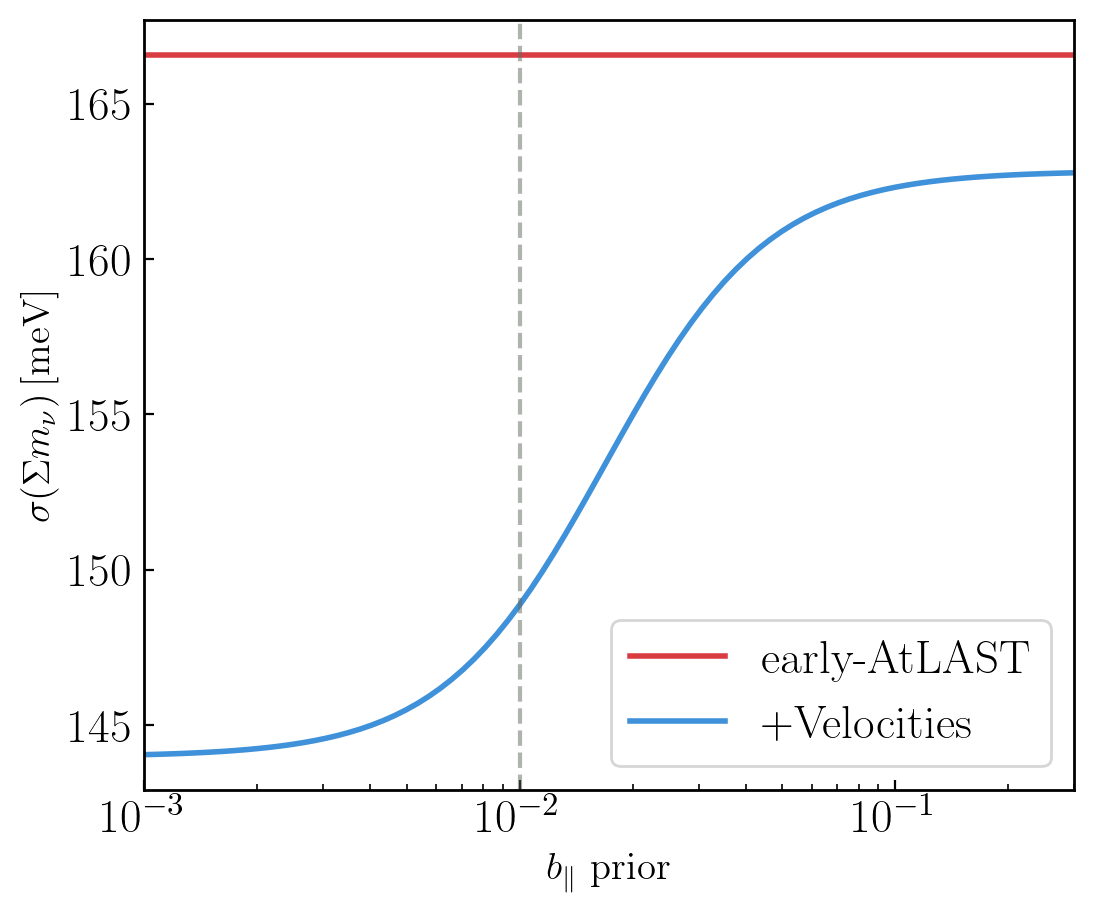

In [54]:
bpar_pr = np.logspace(-3,0,100)

mnu_ind = free_params.index('mnu')
sig_mnu_lim = np.zeros(len(bpar_pr))
sig_mnu_lim_vel = np.zeros(len(bpar_pr))

for i in range(len(bpar_pr)):
    covmat_lim, cov_params = covariance_mat(F_XX_early_AtLAST, all_params, fixed_params, {})
    sig_mnu_lim[i] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_kSZ, cov_params = covariance_mat(F_vX_early_AtLAST, all_params, [], {'bv_par':bpar_pr[i]})
    sig_mnu_lim_vel[i] = np.sqrt(covmat_lim_kSZ[mnu_ind,mnu_ind])

plt.plot(bpar_pr, sig_mnu_lim*1e3, label='early-AtLAST', color=palette[15])
plt.plot(bpar_pr, sig_mnu_lim_vel*1e3, label='+Velocities', color=palette[14])
plt.axvline(x = 1e-2, color = palette[4], alpha=0.5, ls='--', lw=1.5)
plt.xscale('log')
plt.legend()
plt.xlabel(r'$b_\parallel$ prior')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[meV]}$')
plt.xlim(1e-3, 3e-1)

(0.001, 0.2)

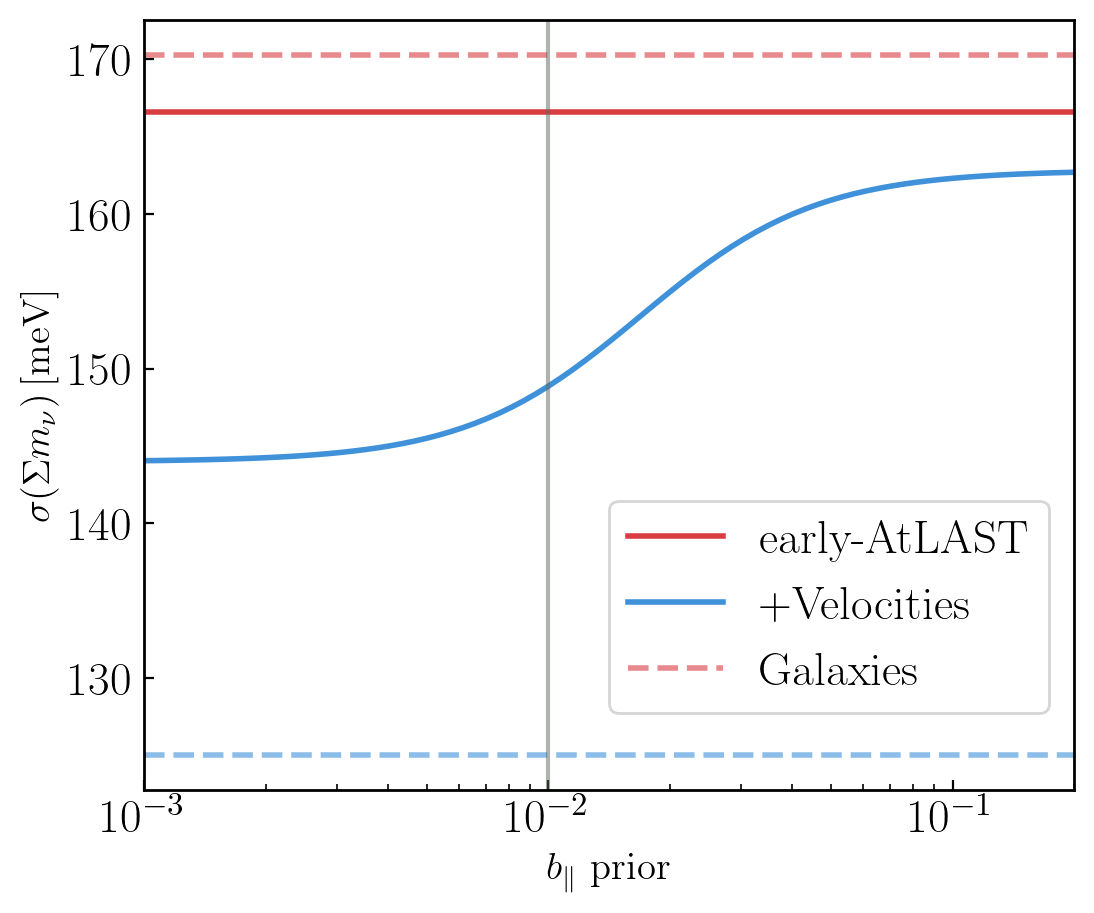

In [55]:
vm_root = '/media/HostShared/galaxies/'
sig_mnu_VRO10 = np.loadtxt(vm_root+'sig_mnu_bpar_gal.txt')
sig_mnu_VRO10_vel = np.loadtxt(vm_root+'sig_mnu_bpar_gal_vel.txt')

bpar_pr = np.logspace(-3,0,100)

mnu_ind = free_params.index('mnu')
sig_mnu_lim = np.zeros(len(bpar_pr))
sig_mnu_lim_vel = np.zeros(len(bpar_pr))

for i in range(len(bpar_pr)):
    covmat_lim, cov_params = covariance_mat(F_XX_early_AtLAST, all_params, fixed_params, {})
    sig_mnu_lim[i] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_kSZ, cov_params = covariance_mat(F_vX_early_AtLAST, all_params, [], {'bv_par':bpar_pr[i]})
    sig_mnu_lim_vel[i] = np.sqrt(covmat_lim_kSZ[mnu_ind,mnu_ind])

plt.plot(bpar_pr, sig_mnu_lim*1e3, label='early-AtLAST', color=palette[15])
plt.plot(bpar_pr, sig_mnu_lim_vel*1e3, label='+Velocities', color=palette[14])
plt.plot(bpar_pr, sig_mnu_VRO10*1e3, label='Galaxies', ls='--', color=palette[15], alpha=0.6)
plt.plot(bpar_pr, sig_mnu_VRO10_vel*1e3, ls='--', color=palette[14], alpha=0.6)
plt.axvline(x = 1e-2, color = palette[4], alpha=0.5, lw=1.5)
plt.xscale('log')
plt.legend(loc=(0.5,0.1))
plt.xlabel(r'$b_\parallel$ prior')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[meV]}$')
plt.xlim(1e-3, 2e-1)

Text(0, 0.5, '$\\sigma(\\Sigma m_\\nu) \\, \\textrm{[meV]}$')

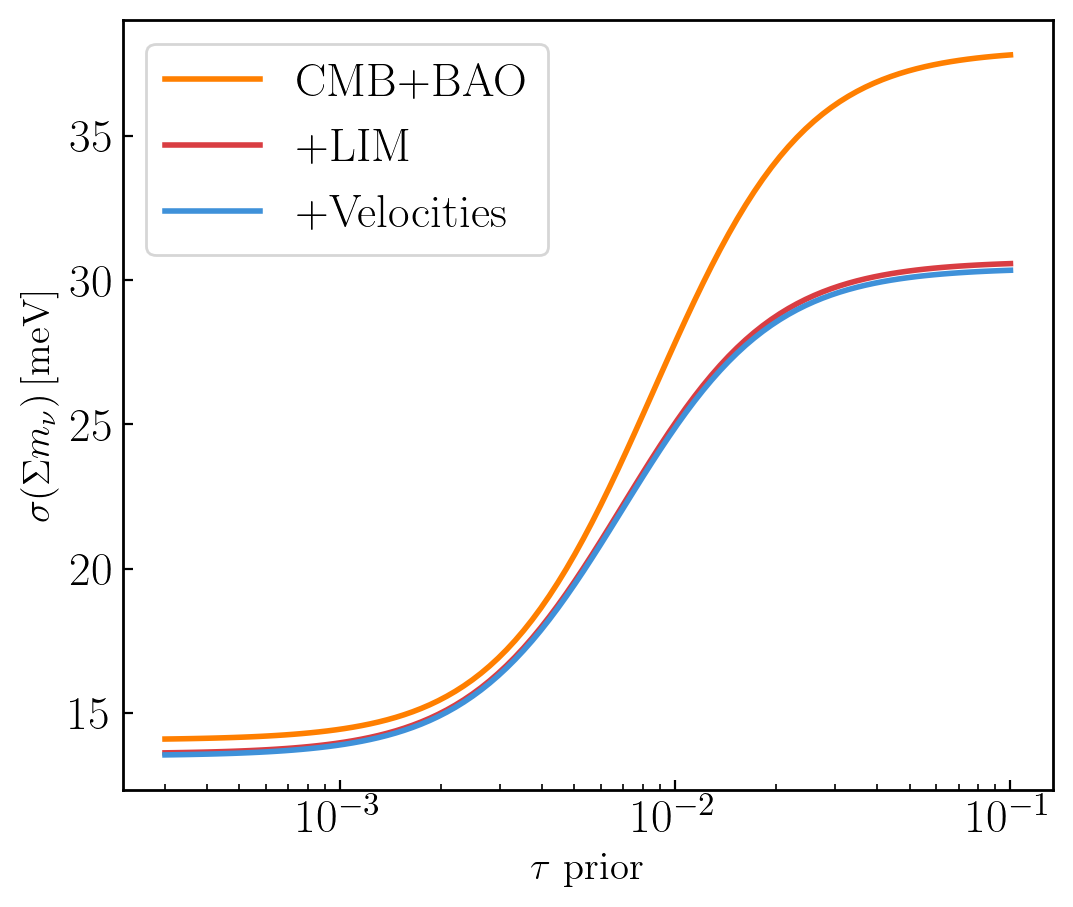

In [56]:

#bpar_pr = np.linspace(1e-4,1e-1,100)
tau_pr = np.logspace(np.log10(3e-4),-1,100)

mnu_ind = free_params.index('mnu')
sig_mnu = np.zeros(len(tau_pr))
sig_mnu_lim = np.zeros(len(tau_pr))
sig_mnu_lim_vel = np.zeros(len(tau_pr))

F_bao_CMB_lim = np.zeros((len(F_XX_early_AtLAST), len(F_XX_early_AtLAST)))
F_bao_CMB_lim[:len(F_bao_CMB), :len(F_bao_CMB)] = F_bao_CMB

F_bao_CMB_lim_vel = np.zeros((len(F_vX_early_AtLAST), len(F_vX_early_AtLAST)))
F_bao_CMB_lim_vel[:len(F_bao_CMB), :len(F_bao_CMB)] = F_bao_CMB

for i in range(len(tau_pr)):
    covmat, cov_params = covariance_mat(F_bao_CMB, free_params2, [], {'tau':tau_pr[i]})
    sig_mnu[i] = np.sqrt(covmat[mnu_ind,mnu_ind])
    covmat_lim, cov_params = covariance_mat(F_bao_CMB_lim+F_XX_early_AtLAST, all_params, fixed_params, {'tau':tau_pr[i]})
    sig_mnu_lim[i] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_kSZ, cov_params = covariance_mat(F_bao_CMB_lim_vel+F_vX_early_AtLAST, all_params, [], {'tau':tau_pr[i], 'bv_par':0.01})
    sig_mnu_lim_vel[i] = np.sqrt(covmat_lim_kSZ[mnu_ind,mnu_ind])

plt.plot(tau_pr, sig_mnu*1e3, label='CMB+BAO', color=palette[6])
plt.plot(tau_pr, sig_mnu_lim*1e3, label='+LIM', color=palette[15])
plt.plot(tau_pr, sig_mnu_lim_vel*1e3, label='+Velocities', color=palette[14])
plt.xscale('log')
plt.legend()
plt.xlabel(r'$\tau$ prior')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[meV]}$')
#plt.title(r'low+high $z$ with 0.5\% prior on $b_\parallel$')
#plt.ylim(60,75)

# Seperate kSZ and ML

In [53]:
#%% Calculate the reconstructed noise N_vv
def Rec_noise2(M, k_large, mu_L, Delta_T):
    Z = M.z
    nkS = 200
    nkL = len(k_large)
    nz = 101
    k_small = np.logspace(-1,np.log10(5),nkS)/u.Mpc # Mpc^-1
    mu_S = -(k_large[np.newaxis,:,np.newaxis]*np.ones((nkS,nkL,nmu))/k_small[:,np.newaxis,np.newaxis]*np.ones((nkS,nkL,nmu))) * mu_L[np.newaxis,np.newaxis,:]*np.ones((nkS,nkL,nmu))
    Mh = np.logspace(8,15,200) # Msun
    zcosmo = np.linspace(0.,15.,nz)
    cosmo1 = (M.cosmo_input_camb).copy()
    cosmo1.pop('f_NL')
    camb_pars = camb.set_params(**cosmo1)
    camb_pars.set_matter_power(redshifts=list(zcosmo))
    cosmo = camb.get_results(camb_pars)
    H = lambda z: cosmo.hubble_parameter(z)/(cu.c.to(u.km/u.s)).value /u.Mpc # 1/Mpc    
    a = lambda z: 1/(1+z)
    T_CMB = ((camb_pars.TCMB* u.K).to(u.uK))#.value # muK
    chi_star = lambda z: cosmo.comoving_radial_distance(z)*u.Mpc # Mpc
    ell = lambda z,kS: chi_star(z) * kS
    
#     TT_total_for_S4 = np.loadtxt('/home/gali/Codes/kSZ coding/C_ells_kSZ_noise_Gabi.txt')
#     lvec = TT_total_for_S4[:,0]
#     Cl_TT = interp1d(lvec,TT_total_for_S4[:,1],bounds_error=False,fill_value=0.) # muK^2
    # kSZ
    xe = 1 # ionization fraction
    gasfrac = 0.9 # fraction of baryons in gas form, use default
    Yp = camb_pars.YHe # primordial He abundance
    ne0 = ksz.ne0_shaw(ombh2=cosmo_params['ombh2'],gasfrac=gasfrac,Yp=Yp) # m^-3 # mean free electron density at z = 0
    Kstar = lambda z: -ksz.ksz_radial_function(z, camb_pars.ombh2, Yp) * u.uK/u.Mpc # muK / Mpc
    
    pxx = (M.Pk_onehalo + M.Pk_twohalo)[0] #Mpc^3 uK^2
    pxe = (M.Pke_onehalo + M.Pke_twohalo)[0] #Mpc^3 uK
    pxx_unit = pxx.unit
    pxe_unit = pxe.unit
    pxx_interp = interp1d(k_fid,pxx,bounds_error=False,fill_value='extrapolate')
    pxx_ksmall = pxx_interp(k_small)*pxx_unit #Mpc^3 uK^2 or Mpc^3 Jy^2/sr^2
    pxe_interp = interp1d(k_fid,pxe,bounds_error=False,fill_value='extrapolate')
    pxe_ksmall = pxe_interp(k_small)*pxe_unit #Mpc^3 uK or Mpc^3 Jy/sr
    kS_ind = np.argmin(np.abs(M.k - k_small[0]))
    fgrowth = M.f_eff[0,kS_ind]
    b_lim = (M.bavg)[0]
    T_lim = M.CLT
    T_mean = M.Tmean
    pshot_ksmall = (M.Pshot) * np.ones(pxx_ksmall.shape)
    pnoise_ksmall = (M.Pnoise) * np.ones(pxx_ksmall.shape)
    resize_ksmall = k_small[:,np.newaxis,np.newaxis]* np.ones((nkS,nkL,nmu))
    resize_pxx = pxx_ksmall[:,np.newaxis,np.newaxis]* np.ones((nkS,nkL,nmu))
    resize_ell_ksmall = chi_star(Z) * k_small[:,np.newaxis,np.newaxis]* np.ones((nkS,nkL,nmu))
    resize_pxe = pxe_ksmall[:,np.newaxis,np.newaxis]* np.ones((nkS,nkL,nmu))
    resize_pshot = pshot_ksmall[:,np.newaxis,np.newaxis]* np.ones((nkS,nkL,nmu))
    resize_pnoise = pnoise_ksmall[:,np.newaxis,np.newaxis]* np.ones((nkS,nkL,nmu))
    sig_par = M.sigma_par
    sig_perp = M.sigma_perp
    W_res = np.exp(-resize_ksmall**2*(sig_par**2*mu_S**2 + sig_perp**2*(1-mu_S**2)))
    kmin_par = 2*np.pi/M.Lfield
    kmin_perp = 2*np.pi/(M.Sfield)**0.5
    W_vol = (1.-np.exp(-(resize_ksmall/kmin_par)**2*mu_S**2))*(1.-np.exp(-(resize_ksmall/kmin_perp)**2*(1-mu_S**2)))
    W_ksmall = W_res * W_vol
    P_xx_ksmall = (1 + mu_S**2*fgrowth/b_lim)**2 * (resize_pxx) # Mpc^3
    P_xx_obs_ksmall = W_ksmall * (P_xx_ksmall + resize_pshot) + resize_pnoise # Mpc^3
    P_xe_ksmall = W_ksmall**0.5 * (1 + mu_S**2*fgrowth/b_lim) * (resize_pxe) # Mpc^3 -> with W(k)
    s = Delta_T *u.arcmin.to(u.radian)
    fwhm = 1.4 *u.arcmin.to(u.radian)
    N_ell=CMB_noise(resize_ell_ksmall, s, fwhm)
    Cltot_noise=(Cl_tot(resize_ell_ksmall)+N_ell)*u.uK**2
    itgrnd = resize_ksmall * (P_xe_ksmall**2 / P_xx_obs_ksmall) / Cltot_noise # Mpc^-1 muK^-2
    mask = np.isinf(itgrnd)
    itgrnd[mask] = 0.
    integral = np.trapz(itgrnd, x=k_small, axis=0) # Mpc / muK^2
    Nvv_par = (chi_star(Z)/ Kstar(Z))**2 * 2*np.pi / integral # Mpc^3
    N_vv = (mu_L[np.newaxis,:]*np.ones((nkL,nmu)))**-2 * Nvv_par
    
    #Nmm = k_large**2/(fgrowth*a(Z)*H(Z))**2 * N_vv[:,-1]
    
    # get potential Pk (non linearities included) - CAMB results is already multiplied by k^4
    interp_Pphiphi = camb.get_matter_power_interpolator(camb_pars, zmin=0, zmax=zcosmo[-1], nz_step=150, zs=None, kmax=max(k_small.value), nonlinear=True,var1=camb.model.Transfer_Weyl, var2=camb.model.Transfer_Weyl, hubble_units=False, 
                                                        k_hunit=False, return_z_k=False, k_per_logint=None, log_interp=False,  extrap_kmax=True).P  # Mpc^-1
    omegam = (camb_pars.ombh2 + camb_pars.omch2 + camb_pars.omnuh2) / (camb_pars.H0 / 100) ** 2
    rhoM0 = 3*omegam*H(0.)**2 # Mpc^-2
    # potential Pk , change of units
    use_Pphiphi_ksmall = (interp_Pphiphi(Z,k_small.value)/u.Mpc/k_small**4)[:,np.newaxis,np.newaxis]*np.ones((nkS,nkL,nmu)) # Mpc^3
    # noise on the potential
    noise_pot = ((1+Z)*rhoM0/2)**2/((resize_ksmall)**4 * (b_lim*T_mean)**2)*(pnoise_ksmall+pshot_ksmall*W_ksmall)  # Mpc^3
    # observed potential
    use_Ppot_ob = use_Pphiphi_ksmall + noise_pot # Mpc^3
    itgrnd_ML = (resize_ksmall)**3 * (use_Pphiphi_ksmall**2 / use_Ppot_ob) / Cltot_noise # muK^-2
    mask = np.isinf(itgrnd_ML)
    itgrnd_ML[mask] = 0
    integral_ML = np.trapz(itgrnd_ML, x=k_small, axis=0) # 1 / Mpc / muK^2
    new_resize_muL = mu_L[np.newaxis,:]*np.ones((nkL,nmu))
    new_resize_kL = k_large[:,np.newaxis]*np.ones((nkL,nmu))
    # noise on the transverse velocity potential (T_CMB factor to cancel the uK units from Cls)
    N_perp_Vpot = (chi_star(Z) / (T_CMB_uK*new_resize_kL*np.sqrt(1-new_resize_muL**2)))**2 * 2*np.pi / 2 / integral_ML # Mpc
    Nvv_perp = (new_resize_kL)**2 * N_perp_Vpot # v = grad pot so in Fourier you get v = k*pot
    N_vv_ML = (np.sqrt(1-new_resize_muL**2))**-2 * Nvv_perp # Mpc^3
    
    return N_vv#_ML
    

#%% Calculate power spectra
def get_powers2(M, k_large):
    
    k = M.k
    pk_line = M.Pk.T
    pk_line_velocity = M.Pkv.T
    pk_velocity = M.Pvv.T
    
    P_XX = pk_line[np.abs(k - k_large[0]).argmin():np.abs(k - k_large[-1]).argmin()+1,]
    P_Xv = pk_line_velocity[np.abs(k - k_large[0]).argmin():np.abs(k - k_large[-1]).argmin()+1,]
    P_vv = pk_velocity[np.abs(k - k_large[0]).argmin():np.abs(k - k_large[-1]).argmin()+1,]


    return P_XX, P_Xv, P_vv

#%% Calculate noise power spectra
def get_noises2(M, k_large, Delta_T):
    nkS = 300
    nkL = len(k_large)
    nz = 101    
    nmu = M.nmu
    N_XX = (M.Pnoise) * np.ones((nkL,nmu))
    N_vv = Rec_noise2(M, k_large, M.mu, Delta_T)
    #N_vv = np.zeros(N_XX.shape)
    
    return N_XX, N_vv



#%% Calculate derivatives of power spectra
def derivs2(M, cosmo0, bias0, free_params, deltas, k):
    nmu = M.nmu
    nk = len(k)
    d_PXX = np.zeros((len(free_params), nk, nmu))
    d_PXv = np.zeros((len(free_params), nk, nmu))
    d_Pvv = np.zeros((len(free_params), nk, nmu))
    param_values = np.zeros(len(free_params))
    for free_param_ind, free_param in enumerate(free_params):
        if free_param in cosmo0:
            param_values[free_param_ind] = cosmo0[free_param]
        elif free_param in bias0:
            param_values[free_param_ind] = bias0[free_param]
        #elif free_param == 'bT':
        #    param_values[free_param_ind] = (M.bavg[0]*M.Tmean).value
        else:
            raise KeyError(f"{free_param} is not a valid parameters for this code!")
    for i, param in enumerate(free_params):
        delta = deltas[i]
        param_value = param_values[i]
        cosmo_model_params['bv_par'] = bias0['bv_par']
        cosmo_model_params['bv_perp'] = bias0['bv_perp']
        cosmo_model_params['bT_up'] = False
        cosmo_model_params['bT_down'] = False
#         cosmo_model_params['model_par']['a'] = bias0['a']
#         cosmo_model_params['model_par']['b'] = bias0['b']
        if param in cosmo0:
            cosmo_p = cosmo0.copy()
            cosmo_n = cosmo0.copy()
            if not cosmo0[param] == 0.:
                cosmo_p[param] = cosmo0[param]*(1.+delta)
                cosmo_n[param] = cosmo0[param]*(1.-delta)
            else:
                cosmo_p[param] = delta
                cosmo_n[param] = -delta
            print('\n\nNow simulating for (1+delta)'+param+
                  f', this is parameter #{i+1} (out of {len(free_params)})')
            cosmo_model_params['cosmo_input_camb'] = cosmo_p
            M = update_Pkline(obs_params,cosmo_model_params)[0]
            PXX_p, PXv_p, Pvv_p = get_powers2(M, k_large)
            print('\n\nNow simulating for (1-delta)'+param+
                  f', this is parameter #{i+1} (out of {len(free_params)})')
            cosmo_model_params['cosmo_input_camb'] = cosmo_n
            M = update_Pkline(obs_params,cosmo_model_params)[0]
            PXX_n, PXv_n, Pvv_n = get_powers2(M, k_large)
        else:
            bias_p = bias0.copy()
            bias_n = bias0.copy()
            if not bias0[param] == 0.:
                bias_p[param] = bias0[param]*(1.+delta)
                bias_n[param] = bias0[param]*(1.-delta)
            else:
                bias_p[param] = delta
                bias_n[param] = -delta
            print('\n\nNow simulating for (1+delta)'+param+
                  f', this is parameter #{i+1} (out of {len(free_params)})')
            cosmo_model_params['cosmo_input_camb'] = cosmo0
            if param=='bT':
                cosmo_model_params['bT_up'] = True
            else:
                cosmo_model_params[param] = bias_p[param]
            M = update_Pkline(obs_params,cosmo_model_params)[0]
            PXX_p, PXv_p, Pvv_p = get_powers2(M, k_large)
            print('\n\nNow simulating for (1-delta)'+param+
                  f', this is parameter #{i+1} (out of {len(free_params)})')
            cosmo_model_params['cosmo_input_camb'] = cosmo0
            if param=='bT':
                cosmo_model_params['bT_up'] = False
                cosmo_model_params['bT_down'] = True
            else:
                cosmo_model_params[param] = bias_n[param]
            M = update_Pkline(obs_params,cosmo_model_params)[0]
            PXX_n, PXv_n, Pvv_n = get_powers2(M, k_large)
        if not param_value == 0.:
            d_PXX[i] = (PXX_p - PXX_n)/(2*param_value*delta)
            d_PXv[i] = (PXv_p - PXv_n)/(2*param_value*delta)
            d_Pvv[i] = (Pvv_p - Pvv_n)/(2*param_value*delta)
        else:
            d_PXX[i] = (PXX_p - PXX_n)/(2*delta)
            d_PXv[i] = (PXv_p - PXv_n)/(2*delta)
            d_Pvv[i] = (Pvv_p - Pvv_n)/(2*delta)
    return d_PXX, d_PXv, d_Pvv
             
    
    
def Fisher_mat2(M, cosmo0, bias0, free_params, deltas, k, vol, Delta_T):
    mu = M.mu
    k_grid=np.meshgrid(mu, k)[1]
    PXX, PXv, Pvv = get_powers2(M, k_large)
    cosmo_model_params['do_onehalo'] = True
    M = update_Pkline(obs_params,cosmo_model_params)[0]
    NXX, Nvv = get_noises2(M, k, Delta_T)
    cosmo_model_params['do_onehalo'] = False
    M = update_Pkline(obs_params,cosmo_model_params)[0]
    d_PXX, d_PXv, d_Pvv = derivs2(M, cosmo0, bias0, free_params, deltas, k)
    S=np.zeros((len(k),len(mu),2,2))
    S[:,:,0,0]=Pvv; S[:,:,0,1]=PXv; S[:,:,1,0]=PXv; S[:,:,1,1]=PXX;
    N=np.zeros((len(k),len(mu),2,2))
    N[:,:,0,0]=Nvv; N[:,:,1,1]=NXX;
    C = S+N
    C_inv = np.linalg.inv(C)
    F_XX=np.zeros((len(free_params), len(free_params)))
    F_Xv=np.zeros((len(free_params), len(free_params)))
    F_vv=np.zeros((len(free_params), len(free_params)))
    for a in range(len(free_params)):
        d_PXX_a=d_PXX[a,:,:]; d_PXv_a=d_PXv[a,:,:]; d_Pvv_a=d_Pvv[a,:,:]
        for b in range(len(free_params)):
            d_PXX_b=d_PXX[b,:,:]; d_PXv_b=d_PXv[b,:,:]; d_Pvv_b=d_Pvv[b,:,:]
            
            dC_a=np.zeros((len(k),len(mu),2,2))
            dC_a[:,:,0,0]=d_Pvv_a; dC_a[:,:,0,1]=d_PXv_a; dC_a[:,:,1,0]=d_PXv_a; dC_a[:,:,1,1]=d_PXX_a;
            dC_b=np.zeros((len(k),len(mu),2,2))
            dC_b[:,:,0,0]=d_Pvv_b; dC_b[:,:,0,1]=d_PXv_b; dC_b[:,:,1,0]=d_PXv_b; dC_b[:,:,1,1]=d_PXX_b;
         
            int_F_Xv=vol.value*((k_grid**2)/(8.*(np.pi**2)))*(np.trace(np.matmul(dC_a, np.matmul(C_inv, np.matmul(dC_b, C_inv))), axis1=2, axis2=3))
            #int_F_hv=vol.value*((k_grid**2)/(8.*(np.pi**2)))*(np.trace(np.matmul(C_inv, np.matmul(dC_a, np.matmul(C_inv, dC_b))), axis1=2, axis2=3))
            F_Xv[a,b]=integrate.simps(integrate.simps(int_F_Xv, mu, axis=1), k)
            F_Xv[b,a]=F_Xv[a,b]
            
            int_F_XX=vol.value*((k_grid**2)/(8.*(np.pi**2)))*(d_PXX_a*d_PXX_b)*((1./(PXX+NXX))**2)
            F_XX[a,b]=integrate.simps(integrate.simps(int_F_XX, mu, axis=1), k)
            F_XX[b,a]=F_XX[a,b]
            
            int_F_vv=vol.value*((k_grid**2)/(8.*(np.pi**2)))*(d_Pvv_a*d_Pvv_b)*((1./(Pvv+Nvv))**2)
            F_vv[a,b]=integrate.simps(integrate.simps(int_F_vv, mu, axis=1), k)
            F_vv[b,a]=F_vv[a,b]
    
    return F_XX, F_Xv, F_vv

In [48]:
cosmo = dict(
         f_NL=0, H0=67.67, cosmomc_theta=None,
         ombh2=0.0224, omch2=0.1193, omk=0.0, neutrino_hierarchy='degenerate',
         num_massive_neutrinos=3, mnu=0.06, nnu=3.046,
         YHe=None, meffsterile=0.0, standard_neutrino_neff=3.046,
         TCMB=2.7255, tau=0.056, deltazrei=None, bbn_predictor=None,
         theta_H0_range=[10, 100], w=-1.0, wa=0., cs2=1.0,
         dark_energy_model='ppf',As=2.105e-09,
         # !!! Planck 2018 eq. 16/17/18 arXiv:1807.06211
         ns=0.967, nrun=0.0, nrunrun=0.0,
         r=0.0, nt=None, ntrun=0.0,
         pivot_scalar=0.05, pivot_tensor=0.05,
         parameterization=2,halofit_version='mead')

down = True
cosmo_model_params, obs_params = lim_params('CII',down)
m = update_Pkline(obs_params,cosmo_model_params)[0]

nu, Dnu = Dnu_from_Dz(m.nu, zs[0], 1)
cosmo_model_params['nuObs'] = nu
obs_params['Delta_nu'] = Dnu
obs_params['dnu'] = (nu/R).to(u.MHz)
obs_params['beam_FWHM'] = beam[0]
obs_params['sigma_pix'] = sigpix[0]
m = update_Pkline(obs_params,cosmo_model_params)[0]

print(m.Omega_field, m.tobs)
print(m.sigma_N, m.Pnoise)

1000.0 deg2 3000.0 h
Note: redshifts have been re-sorted (earliest first)
259803.06644328378 Jy / sr 599504459.1689875 Jy2 Mpc3 / sr2


In [49]:
bias_params['bv'] = 1.
bias_params

{'bv_par': 1.0, 'bv_perp': 1.0, 'bT': 4589.852433176416, 'bv': 1.0}

In [54]:
cosmo_model_params['cosmo_input_camb'] = cosmo_params
cosmo_model_params, obs_params = lim_params('CII', downgrade=False)

m = update_Pkline(obs_params,cosmo_model_params)[0]

zs = np.arange(1.5, 4.51, 1)

deltas= [1e-2,1e-2,-1e-2,1e-2,1e-2,3e-1,3e-1,1e-2,1e-2,1e-2]
free_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'bv', 'bT']
fixed_params = ['bv']

Fz_XX_kSZ = np.zeros((len(zs),len(free_params),len(free_params)))
Fz_vX_kSZ = np.zeros((len(zs),len(free_params),len(free_params)))
Fz_vv_kSZ = np.zeros((len(zs),len(free_params),len(free_params)))
for i in range(len(zs)):
    nu, Dnu = Dnu_from_Dz(m.nu, zs[i], 1)
    cosmo_model_params['nuObs'] = nu
    obs_params['Delta_nu'] = Dnu
    obs_params['dnu'] = (nu/R).to(u.MHz)
    obs_params['beam_FWHM'] = beam[i]
    obs_params['sigma_pix'] = sigpix[i]
    m = update_Pkline(obs_params,cosmo_model_params)[0]
    bias_params['bT'] = (m.bavg[0]*m.Tmean).value
    print(m.z, m.nuObs, m.Delta_nu, m.beam_FWHM, m.sigma_N)
    
    vol = m.Vfield
    k_large = (k_fid[(k_fid >= np.pi/vol**(1/3))&(k_fid.value <= 0.1)])
    xx,vx,vv = Fisher_mat2(m, cosmo_params, bias_params, free_params, deltas, k_large, vol, Delta_T_S4)
    
    Fz_XX_kSZ[i,:,:] = xx
    Fz_vX_kSZ[i,:,:] = vx
    Fz_vv_kSZ[i,:,:] = vv


Note: redshifts have been re-sorted (earliest first)
1.5 760.2156 GHz 316.75649999999996 GHz 2.0 arcsec 389710.0 Jy / sr
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 9)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 9)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 9)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 9)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 9)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 9)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 9)
Note: redshifts have been re-sorte



Now simulating for (1-delta)As, this is parameter #5 (out of 9)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 9)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 9)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 9)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 9)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv, this is parameter #8 (out of 9)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv, this is parameter #8 (out of 9)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #9 (out of 9)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is pa

In [55]:
lcdm_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'bv']
bT_params = ['bT0', 'bT1', 'bT2', 'bT3']
all_params = lcdm_params + bT_params
Nparams = len(all_params)

# Function to map parameter names to indices in the combined Fisher matrix
def get_param_indices(all_params):
    return {param: idx for idx, param in enumerate(all_params)}

F_XX_kSZ = np.zeros((Nparams, Nparams))
F_vX_kSZ = np.zeros((Nparams, Nparams))
F_vv_kSZ = np.zeros((Nparams, Nparams))
# Get the parameter indices for the combined Fisher matrix
param_indices = get_param_indices(all_params)

bT_ind = free_params.index('bT')

# Add each individual Fisher matrix to the combined Fisher matrix
for i, F in enumerate(Fz_XX_kSZ):
    # Indices for the LCDM parameters
    for j, param1 in enumerate(lcdm_params):
        for k, param2 in enumerate(lcdm_params):
            F_XX_kSZ[param_indices[param1], param_indices[param2]] += F[j, k]

    # Indices for the LCDM parameters and bg parameter for this redshift bin
    bT_param = f'bT{i}'
    for j, param1 in enumerate(lcdm_params):
        F_XX_kSZ[param_indices[param1], param_indices[bT_param]] += F[j, bT_ind]
        F_XX_kSZ[param_indices[bT_param], param_indices[param1]] += F[bT_ind, j]

    # Index for the bg parameter for this redshift bin
    F_XX_kSZ[param_indices[bT_param], param_indices[bT_param]] += F[bT_ind, bT_ind]

# Add each individual Fisher matrix to the combined Fisher matrix
for i, F in enumerate(Fz_vX_kSZ):
    # Indices for the LCDM parameters
    for j, param1 in enumerate(lcdm_params):
        for k, param2 in enumerate(lcdm_params):
            F_vX_kSZ[param_indices[param1], param_indices[param2]] += F[j, k]

    # Indices for the LCDM parameters and bg parameter for this redshift bin
    bT_param = f'bT{i}'
    for j, param1 in enumerate(lcdm_params):
        F_vX_kSZ[param_indices[param1], param_indices[bT_param]] += F[j, bT_ind]
        F_vX_kSZ[param_indices[bT_param], param_indices[param1]] += F[bT_ind, j]

    # Index for the bg parameter for this redshift bin
    F_vX_kSZ[param_indices[bT_param], param_indices[bT_param]] += F[bT_ind, bT_ind]
    
# Add each individual Fisher matrix to the combined Fisher matrix
for i, F in enumerate(Fz_vv_kSZ):
    # Indices for the LCDM parameters
    for j, param1 in enumerate(lcdm_params):
        for k, param2 in enumerate(lcdm_params):
            F_vv_kSZ[param_indices[param1], param_indices[param2]] += F[j, k]

    # Indices for the LCDM parameters and bg parameter for this redshift bin
    bT_param = f'bT{i}'
    for j, param1 in enumerate(lcdm_params):
        F_vv_kSZ[param_indices[param1], param_indices[bT_param]] += F[j, bT_ind]
        F_vv_kSZ[param_indices[bT_param], param_indices[param1]] += F[bT_ind, j]

    # Index for the bg parameter for this redshift bin
    F_vv_kSZ[param_indices[bT_param], param_indices[bT_param]] += F[bT_ind, bT_ind]


In [52]:

print('LIM:')
covmat_lim, cov_params = covariance_mat(F_XX_kSZ, all_params, fixed_params, {})
print_1_sigmas(covmat_lim,cov_params)
print('\n LIM+kSZ:')
covmat_lim_kSZ, cov_params = covariance_mat(F_vX_kSZ, all_params, [], {})
print_1_sigmas(covmat_lim_kSZ,cov_params)
print('\n Velocity:')
covmat_kSZ, cov_params = covariance_mat(F_vv_kSZ, all_params, bT_params, {})
print_1_sigmas(covmat_kSZ,cov_params)

LIM:


1-sigma of H0 is 1.6810902813325954
1-sigma of ombh2 is 0.0001674186863320034
1-sigma of omch2 is 0.0005563543170826596
1-sigma of ns is 0.00534467438492428
1-sigma of As is 4.792588094329084e-11
1-sigma of tau is 3.04967808983584
1-sigma of mnu is 0.05033826451558401
1-sigma of bT0 is 12.41510853513363
1-sigma of bT1 is 20.59410019607753
1-sigma of bT2 is 35.26998888740906
1-sigma of bT3 is 60.07687589409144

 LIM+kSZ:


1-sigma of H0 is 1.6420355245759808
1-sigma of ombh2 is 0.000167314780110656
1-sigma of omch2 is 0.000552924806058129
1-sigma of ns is 0.00530490290777928
1-sigma of As is 4.723210709312539e-11
1-sigma of tau is 3.02898689199048
1-sigma of mnu is 0.04939974387012854
1-sigma of bv is 0.004933475597632491
1-sigma of bT0 is 12.100825115923847
1-sigma of bT1 is 20.43633775973864
1-sigma of bT2 is 35.07016352923579
1-sigma of bT3 is 59.73342127710373

 Velocity:


1-sigma of H0 is 75.21975305778878
1-sigma of ombh2 is 0.005856222120372348
1-sigma of omch2 is 0.02096

Setting $N_{vv} = 0$ (for tests)

In [56]:

print('LIM:')
covmat_lim, cov_params = covariance_mat(F_XX_kSZ, all_params, fixed_params, {})
print_1_sigmas(covmat_lim,cov_params)
print('\n LIM+kSZ:')
covmat_lim_kSZ, cov_params = covariance_mat(F_vX_kSZ, all_params, [], {})
print_1_sigmas(covmat_lim_kSZ,cov_params)
print('\n Velocity:')
covmat_kSZ, cov_params = covariance_mat(F_vv_kSZ, all_params, bT_params, {})
print_1_sigmas(covmat_kSZ,cov_params)

LIM:


1-sigma of H0 is 1.6810902813325954
1-sigma of ombh2 is 0.0001674186863320034
1-sigma of omch2 is 0.0005563543170826596
1-sigma of ns is 0.00534467438492428
1-sigma of As is 4.792588094329084e-11
1-sigma of tau is 3.04967808983584
1-sigma of mnu is 0.05033826451558401
1-sigma of bT0 is 12.41510853513363
1-sigma of bT1 is 20.59410019607753
1-sigma of bT2 is 35.26998888740906
1-sigma of bT3 is 60.07687589409144

 LIM+kSZ:


1-sigma of H0 is 0.37419934821202067
1-sigma of ombh2 is 0.00015092868378945343
1-sigma of omch2 is 0.00017648350832706708
1-sigma of ns is 0.0008446883985351222
1-sigma of As is 1.2734993917759141e-11
1-sigma of tau is 0.8400757866386693
1-sigma of mnu is 0.009204656809913895
1-sigma of bv is 0.0006042617181323106
1-sigma of bT0 is 2.3960275503311217
1-sigma of bT1 is 3.5477769920783473
1-sigma of bT2 is 4.756644286768722
1-sigma of bT3 is 7.6398650739485

 Velocity:


1-sigma of H0 is 3.5847807542580905
1-sigma of ombh2 is 0.00017462089094600418
1-sigma of om

Cells are not updated from here on now

### Vary $\Delta_T$ for AtLAST

In [14]:
ARCMIN_TO_RAD = 1./60.*np.pi/180.
Delta_Ts = np.logspace(-1,1, 8)

fsky=0.4

deltas= [1e-2,1e-2,-1e-2,1e-2,1e-2,3e-1,3e-1,1e-2,1e-2,1e-2,1e-2]
free_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'bv_par', 'bv_perp', 'bT']
fixed_params = ['bv_par', 'bv_perp']

F_XX_t = []
F_vX_t = []

mnu_ind = free_params.index('mnu')
sig_mnu_DT = np.zeros(len(Delta_Ts))
sig_mnu_lim_DT = np.zeros(len(Delta_Ts))
sig_mnu_lim_vel_DT = np.zeros(len(Delta_Ts))
sig_mnu_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_lim_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_lim_vel_DT_pr = np.zeros(len(Delta_Ts))


for t in range(len(Delta_Ts)):
    
    Fz_XX_LIM = np.zeros((len(zs),len(free_params)-len(fixed_params)-1,len(free_params)-len(fixed_params)-1))
    Fz_vX_LIM = np.zeros((len(zs),len(free_params)-1,len(free_params)-1))
    for i in range(len(zs)):
        cosmo_model_params, obs_params = lim_params('CII', downgrade=False)
        nu, Dnu = Dnu_from_Dz(m.nu, zs[i], 1)
        cosmo_model_params['nuObs'] = nu
        obs_params['Delta_nu'] = Dnu
        obs_params['dnu'] = (nu/R).to(u.MHz)
        obs_params['beam_FWHM'] = beam[i]
        obs_params['sigma_pix'] = sigpix[i]
        m = update_Pkline(obs_params,cosmo_model_params)[0]
        bias_params['bT'] = (m.bavg[0]*m.Tmean).value
        sigN = m.sigma_N / m.tpix.to(u.s)**0.5
        print(m.z, m.nuObs, m.Delta_nu, m.beam_FWHM, sigN)

        vol = m.Vfield
        k_large = (k_fid[(k_fid >= np.pi/vol**(1/3))&(k_fid.value <= 0.1)])
        xx,vx = Fisher_mat(m, cosmo_params, bias_params, free_params, deltas, k_large, vol, Delta_Ts[t])
        
        cov_xx, cov_params2 = covariance_mat(xx, free_params, fixed_params, {})
        cov_xx = np.delete(cov_xx, -1, axis=0)
        cov_xx = np.delete(cov_xx, -1, axis=1)
        Fz_XX_LIM[i,:,:] = np.linalg.inv(cov_xx)

        cov_vx, cov_params3 = covariance_mat(vx, free_params, [], {})
        cov_vx = np.delete(cov_vx, -1, axis=0)
        cov_vx = np.delete(cov_vx, -1, axis=1)
        Fz_vX_LIM[i,:,:] = np.linalg.inv(cov_vx)

    F_vX_t.append(np.sum(Fz_vX_LIM, axis=0))
    F_XX_t.append(np.sum(Fz_XX_LIM, axis=0))
    

cov_params2.remove('bT')
cov_params3.remove('bT')

# with open(fisher_root+'F_vX_DeltaT_AtLAST.pkl', 'wb') as file: 
#     pickle.dump(F_vX_t, file)
    
# with open(fisher_root+'F_XX_DeltaT_AtLAST.pkl', 'wb') as file: 
#     pickle.dump(F_XX_t, file)

Note: redshifts have been re-sorted (earliest first)
1.5 760.2156 GHz 316.75649999999996 GHz 2.0 arcsec 10124925.606666666 Jy / (s(1/2) sr)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (

Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re



Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delt



Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)



Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu,



Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv



Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1



Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating f



Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
2.5 543.0111428571429 GHz 158.37825000000004 GHz 2.8 arcsec 2596677.920517778 Jy / (s(



Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
1.5 760.2156 GHz 316.75649999999996 GHz 2.0 arcsec 10124925.606666666 Jy / (s(1/2) sr)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating f



Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
4.5 345.55254545454545 GHz 63.35129999999998 GHz 4.4 arcsec 472770.5993066667 Jy / (s(1/2) sr)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating

In [18]:
mnu_ind = free_params.index('mnu')
free_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'bv_par', 'bv_perp', 'bT']
fixed_params = ['bv_par', 'bv_perp']

cov_params2 = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu']
cov_params3 = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'bv_par', 'bv_perp']

with open(fisher_root+'F_vX_DeltaT_AtLAST.pkl', "rb") as f:
    F_vX_t = pickle.load(f)
    
with open(fisher_root+'F_XX_DeltaT_AtLAST.pkl', "rb") as f:
    F_XX_t = pickle.load(f)

Text(0, 0.5, '$\\sigma(\\Sigma m_\\nu) \\, \\textrm{[meV]}$')

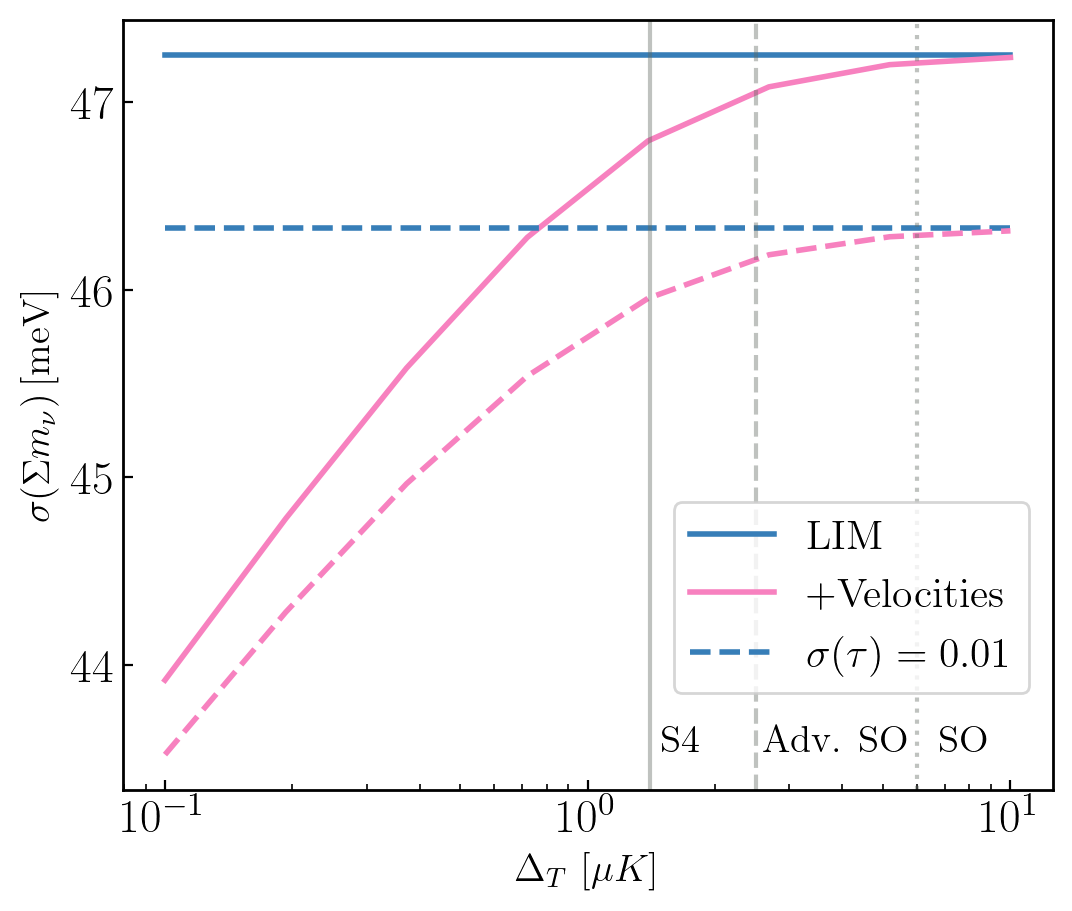

In [16]:
Delta_Ts = np.logspace(-1,1, 8)

sig_mnu_DT = np.zeros(len(Delta_Ts))
sig_mnu_lim_DT = np.zeros(len(Delta_Ts))
sig_mnu_lim_vel_DT = np.zeros(len(Delta_Ts))
sig_mnu_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_lim_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_lim_vel_DT_pr = np.zeros(len(Delta_Ts))

for t in range(len(Delta_Ts)):
                
    F_vX = F_vX_t[t]
    F_XX = F_XX_t[t]
    
    covmat_lim, cov_params = covariance_mat(F_XX, cov_params2, fixed_params, {})
    sig_mnu_lim_DT[t] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_vel, cov_params = covariance_mat(F_vX, cov_params3, [], {})
    sig_mnu_lim_vel_DT[t] = np.sqrt(covmat_lim_vel[mnu_ind,mnu_ind])
    
    covmat_lim, cov_params = covariance_mat(F_XX, cov_params2, fixed_params, {'tau':0.01})
    sig_mnu_lim_DT_pr[t] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_vel, cov_params = covariance_mat(F_vX, cov_params3, [], {'tau':0.01})
    sig_mnu_lim_vel_DT_pr[t] = np.sqrt(covmat_lim_vel[mnu_ind,mnu_ind])

    
#plt.figure(figsize=(11,6))

plt.plot(Delta_Ts, sig_mnu_lim_DT*1e3, label='LIM', color=palette[5])
plt.plot(Delta_Ts, sig_mnu_lim_vel_DT*1e3, label='+Velocities', color=palette[8])
plt.plot(Delta_Ts, sig_mnu_lim_DT_pr*1e3, label=r'$\sigma(\tau)=0.01$', color=palette[5], ls='--')
plt.plot(Delta_Ts, sig_mnu_lim_vel_DT_pr*1e3, color=palette[8], ls='--')
plt.axvline(x = 1.4, color = palette[4], alpha=0.4, lw=1.5)
plt.axvline(x = 2.5, color = palette[4], alpha=0.4, ls='--', lw=1.5)
plt.axvline(x = 6., color = palette[4], alpha=0.4, ls=':', lw=1.5)
plt.text(1.5, 43.5, 'S4', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(2.6, 43.5, 'Adv. SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(6.8, 43.5, 'SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.xscale('log')
plt.legend(loc='upper left', fontsize=15, bbox_to_anchor=(0.57,0.4))
plt.xlabel(r'$\Delta_T \,\, [\mu K]$')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[meV]}$')
#plt.title(r'low+high $z$')
#plt.ylim(0.1,0.7)



Text(0.5, 1.0, 'low $z$ plot')

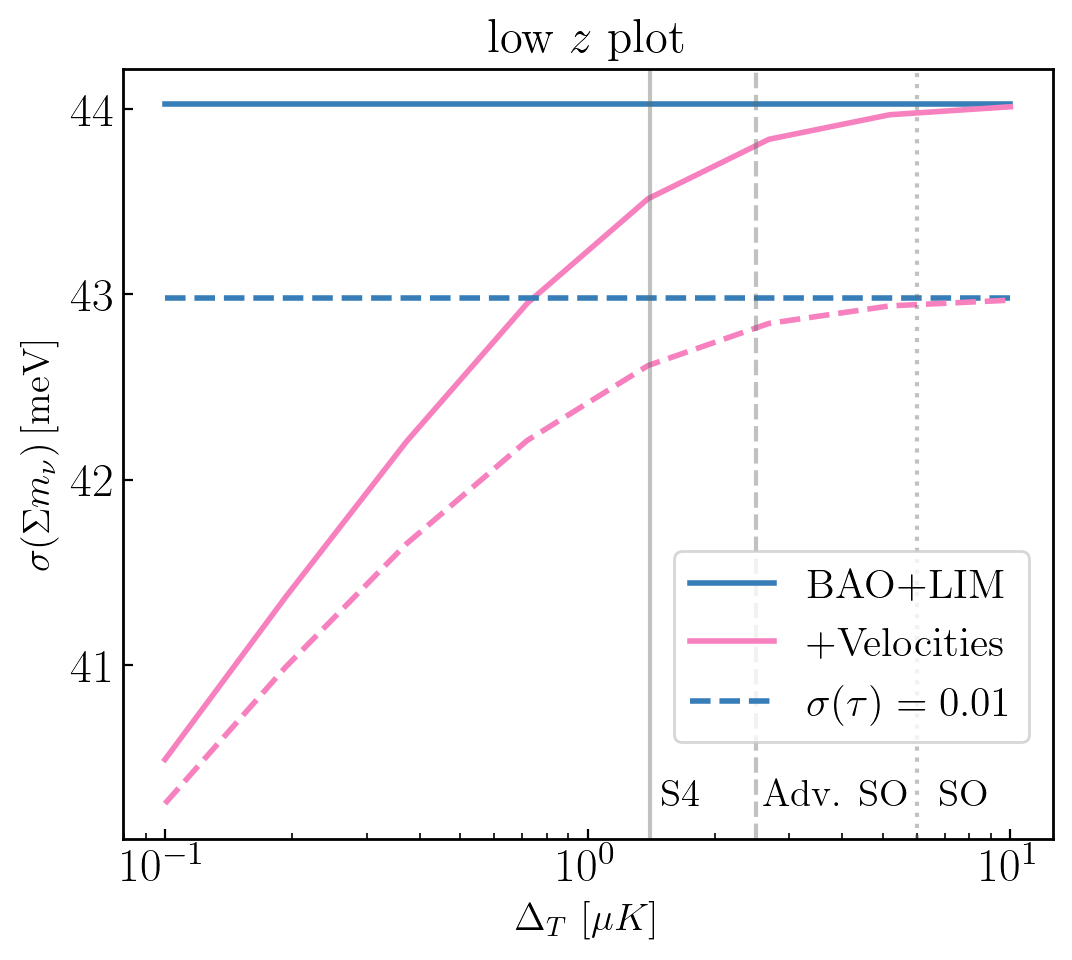

In [20]:
Delta_Ts = np.logspace(-1,1, 8)

sig_mnu_DT = np.zeros(len(Delta_Ts))
sig_mnu_lim_DT = np.zeros(len(Delta_Ts))
sig_mnu_lim_vel_DT = np.zeros(len(Delta_Ts))
sig_mnu_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_lim_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_lim_vel_DT_pr = np.zeros(len(Delta_Ts))

for t in range(len(Delta_Ts)):
                
    F_vX = F_vX_t[t]
    F_XX = F_XX_t[t]
    
    F_bao_L1 = np.zeros((len(F_XX), len(F_XX)))
    F_bao_L1[:7,:7] = F_bao
    F_bao_L2 = np.zeros((len(F_vX), len(F_vX)))
    F_bao_L2[:7,:7] = F_bao
    
    covmat_lim, cov_params = covariance_mat(F_bao_L1+F_XX, cov_params2, fixed_params, {})
    sig_mnu_lim_DT[t] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_vel, cov_params = covariance_mat(F_bao_L2+F_vX, cov_params3, [], {})
    sig_mnu_lim_vel_DT[t] = np.sqrt(covmat_lim_vel[mnu_ind,mnu_ind])
    
    covmat_lim, cov_params = covariance_mat(F_bao_L1+F_XX, cov_params2, fixed_params, {'tau':0.005})
    sig_mnu_lim_DT_pr[t] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_vel, cov_params = covariance_mat(F_bao_L2+F_vX, cov_params3, [], {'tau':0.005})
    sig_mnu_lim_vel_DT_pr[t] = np.sqrt(covmat_lim_vel[mnu_ind,mnu_ind])

    
#plt.figure(figsize=(11,6))

plt.plot(Delta_Ts, sig_mnu_lim_DT*1e3, label='BAO+LIM', color=palette[5])
plt.plot(Delta_Ts, sig_mnu_lim_vel_DT*1e3, label='+Velocities', color=palette[8])
plt.plot(Delta_Ts, sig_mnu_lim_DT_pr*1e3, label=r'$\sigma(\tau)=0.01$', color=palette[5], ls='--')
plt.plot(Delta_Ts, sig_mnu_lim_vel_DT_pr*1e3, color=palette[8], ls='--')
plt.axvline(x = 1.4, color = palette[4], alpha=0.4, lw=1.5)
plt.axvline(x = 2.5, color = palette[4], alpha=0.4, ls='--', lw=1.5)
plt.axvline(x = 6., color = palette[4], alpha=0.4, ls=':', lw=1.5)
plt.text(1.5, 40.2, 'S4', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(2.6, 40.2, 'Adv. SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(6.8, 40.2, 'SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.xscale('log')
plt.legend(loc='upper left', fontsize=15, bbox_to_anchor=(0.57,0.4))
plt.xlabel(r'$\Delta_T \,\, [\mu K]$')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[meV]}$')
plt.title(r'low $z$ plot')
#plt.ylim(0.1,0.7)



Text(0.5, 1.0, 'high+low $z$ plot')

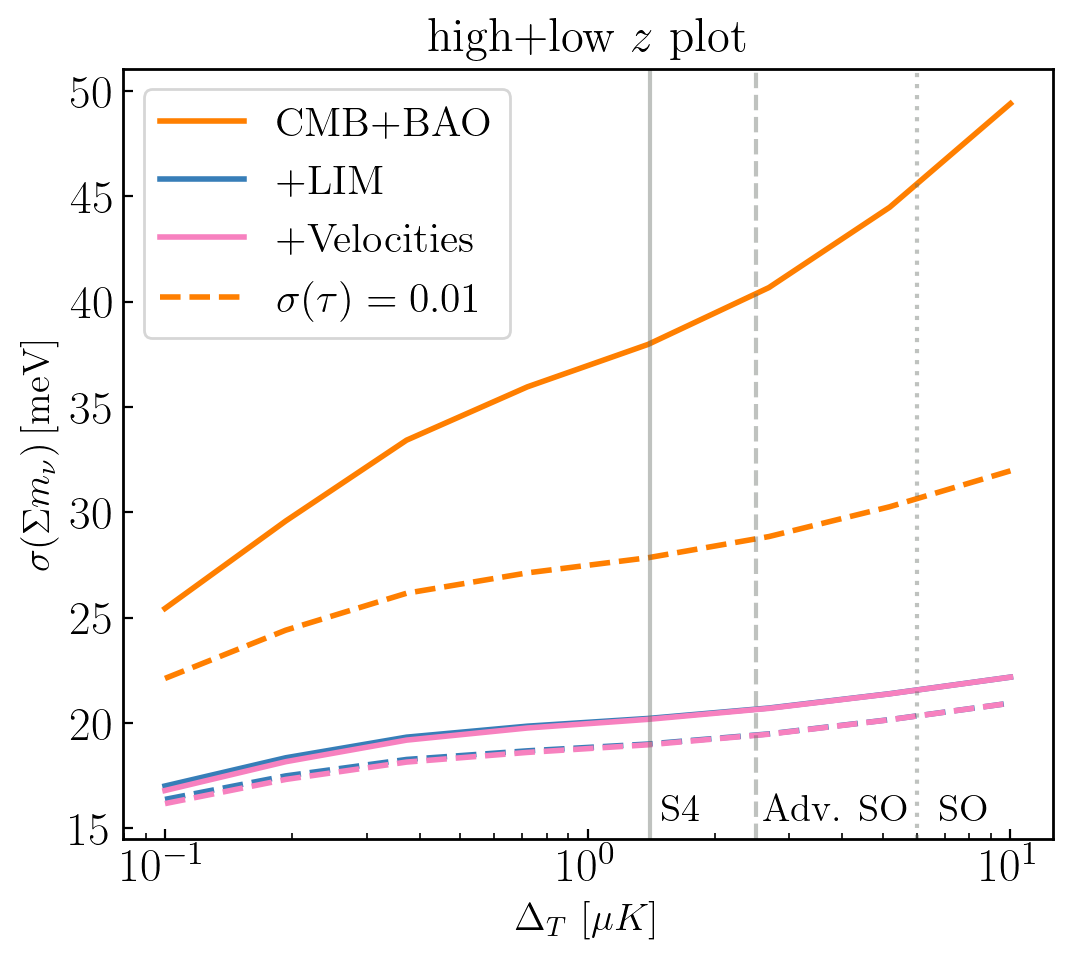

In [22]:
sig_mnu_DT = np.zeros(len(Delta_Ts))
sig_mnu_lim_DT = np.zeros(len(Delta_Ts))
sig_mnu_lim_vel_DT = np.zeros(len(Delta_Ts))
sig_mnu_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_lim_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_lim_vel_DT_pr = np.zeros(len(Delta_Ts))

for t in range(len(Delta_Ts)):
                
    F_vX = F_vX_t[t]
    F_XX = F_XX_t[t]
    
    F_CMB_L1 = np.zeros((len(F_XX), len(F_XX)))
    F_CMB_L2 = np.zeros((len(F_vX), len(F_vX)))
    #F_S4_t = data['fisherNonGaussian_delensed'][t]*fsky
    F_S4_t = F_CMB_DT['fisherGaussian'][t]['lensed']*fsky
    F_S4_t = np.delete(F_S4_t, -1, axis=0)
    F_S4_t = np.delete(F_S4_t, -1, axis=1)
    F_CMB_L1[:7,:7] = F_S4_t
    F_CMB_L2[:7,:7] = F_S4_t
    F_bao_L1 = np.zeros((len(F_XX), len(F_XX)))
    F_bao_L2 = np.zeros((len(F_vX), len(F_vX)))
    F_bao_L1[:7,:7] = F_bao
    F_bao_L2[:7,:7] = F_bao
    F_planck_lowell_L1 = np.zeros((len(F_XX), len(F_XX)))
    F_planck_lowell_L2 = np.zeros((len(F_vX), len(F_vX)))
    F_planck_lowell_L1[:7,:7] = F_planck_lowell
    F_planck_lowell_L2[:7,:7] = F_planck_lowell
    F_bao_CMB_DT1 = F_CMB_L1 + F_bao_L1 + F_planck_lowell_L1
    F_bao_CMB_DT2 = F_CMB_L2 + F_bao_L2 + F_planck_lowell_L2
    cov, covp = covariance_mat(F_bao_CMB_DT1, cov_params2, [], {})
    sig_mnu_DT[t] = np.sqrt(cov[mnu_ind,mnu_ind])
    cov, covp = covariance_mat(F_bao_CMB_DT1, cov_params2, [], {'tau':0.01})
    sig_mnu_DT_pr[t] = np.sqrt(cov[mnu_ind,mnu_ind])
    
    covmat_lim, cov_params = covariance_mat(F_bao_CMB_DT1+F_XX, cov_params2, fixed_params, {})
    sig_mnu_lim_DT[t] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_vel, cov_params = covariance_mat(F_bao_CMB_DT2+F_vX, cov_params3, [], {})
    sig_mnu_lim_vel_DT[t] = np.sqrt(covmat_lim_vel[mnu_ind,mnu_ind])
    
    covmat_lim, cov_params = covariance_mat(F_bao_CMB_DT1+F_XX, cov_params2, fixed_params, {'tau':0.01})
    sig_mnu_lim_DT_pr[t] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_vel, cov_params = covariance_mat(F_bao_CMB_DT2+F_vX, cov_params3, [], {'tau':0.01})
    sig_mnu_lim_vel_DT_pr[t] = np.sqrt(covmat_lim_vel[mnu_ind,mnu_ind])

    
#plt.figure(figsize=(11,6))


plt.plot(Delta_Ts, sig_mnu_DT*1e3, label='CMB+BAO', color=palette[6])
plt.plot(Delta_Ts, sig_mnu_lim_DT*1e3, label='+LIM', color=palette[5])
plt.plot(Delta_Ts, sig_mnu_lim_vel_DT*1e3, label='+Velocities', color=palette[8])
plt.plot(Delta_Ts, sig_mnu_DT_pr*1e3, label=r'$\sigma(\tau)=0.01$', color=palette[6], ls='--')
plt.plot(Delta_Ts, sig_mnu_lim_DT_pr*1e3, color=palette[5], ls='--')
plt.plot(Delta_Ts, sig_mnu_lim_vel_DT_pr*1e3, color=palette[8], ls='--')
plt.axvline(x = 1.4, color = palette[4], alpha=0.4, lw=1.5)
plt.axvline(x = 2.5, color = palette[4], alpha=0.4, ls='--', lw=1.5)
plt.axvline(x = 6., color = palette[4], alpha=0.4, ls=':', lw=1.5)
plt.text(1.5, 15, 'S4', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(2.6, 15, 'Adv. SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(6.8, 15, 'SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.xscale('log')
plt.legend(loc='upper left', fontsize=15)#, bbox_to_anchor=(0.52,0.4))
plt.xlabel(r'$\Delta_T \,\, [\mu K]$')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[meV]}$')
plt.title(r'high+low $z$ plot')
#plt.ylim(0.1,0.7)



Text(0.5, 1.0, 'high+low $z$ plot with $0.5\\%$ prior on $b_\\parallel$')

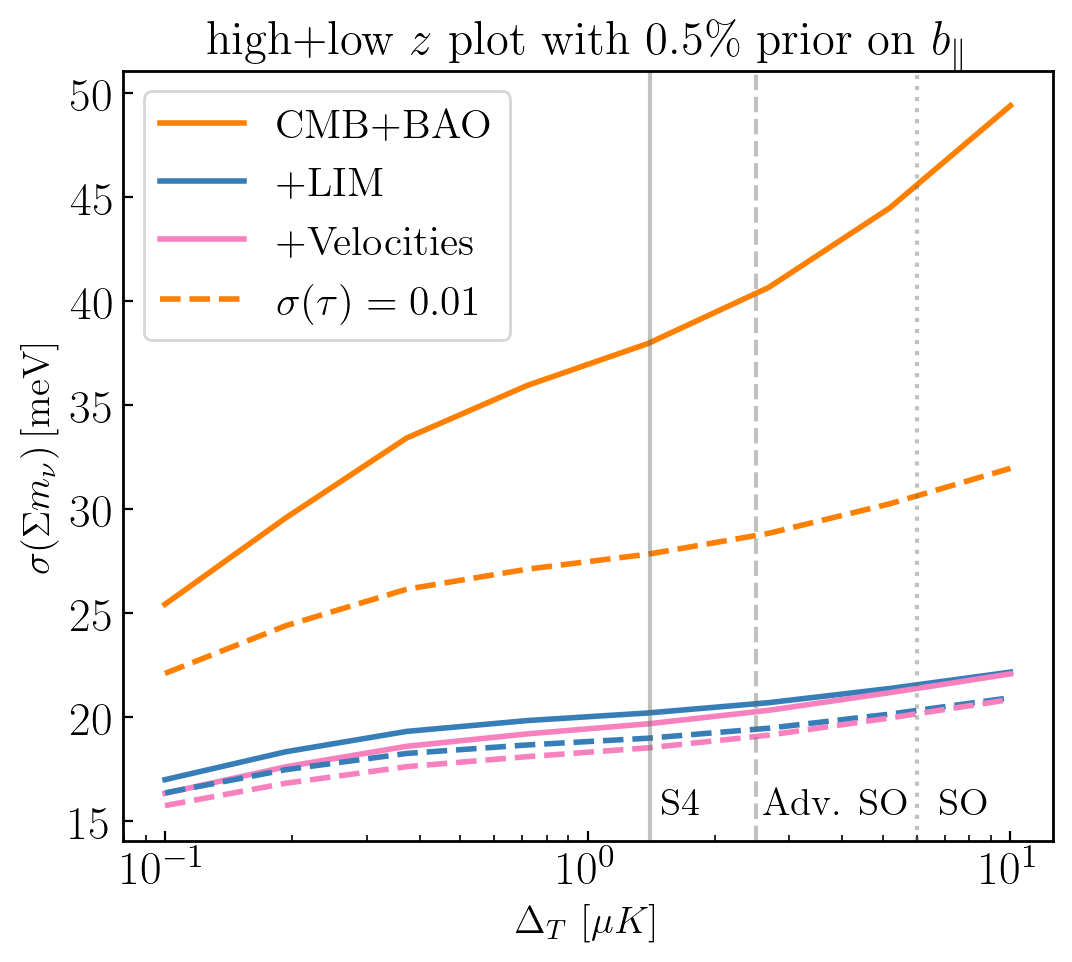

In [23]:
sig_mnu_DT = np.zeros(len(Delta_Ts))
sig_mnu_lim_DT = np.zeros(len(Delta_Ts))
sig_mnu_lim_vel_DT = np.zeros(len(Delta_Ts))
sig_mnu_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_lim_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_lim_vel_DT_pr = np.zeros(len(Delta_Ts))

for t in range(len(Delta_Ts)):
                
    F_vX = F_vX_t[t]
    F_XX = F_XX_t[t]
    
    F_CMB_L1 = np.zeros((len(F_XX), len(F_XX)))
    F_CMB_L2 = np.zeros((len(F_vX), len(F_vX)))
    #F_S4_t = data['fisherNonGaussian_delensed'][t]*fsky
    F_S4_t = F_CMB_DT['fisherGaussian'][t]['lensed']*fsky
    F_S4_t = np.delete(F_S4_t, -1, axis=0)
    F_S4_t = np.delete(F_S4_t, -1, axis=1)
    F_CMB_L1[:7,:7] = F_S4_t
    F_CMB_L2[:7,:7] = F_S4_t
    F_bao_L1 = np.zeros((len(F_XX), len(F_XX)))
    F_bao_L2 = np.zeros((len(F_vX), len(F_vX)))
    F_bao_L1[:7,:7] = F_bao
    F_bao_L2[:7,:7] = F_bao
    F_planck_lowell_L1 = np.zeros((len(F_XX), len(F_XX)))
    F_planck_lowell_L2 = np.zeros((len(F_vX), len(F_vX)))
    F_planck_lowell_L1[:7,:7] = F_planck_lowell
    F_planck_lowell_L2[:7,:7] = F_planck_lowell
    F_bao_CMB_DT1 = F_CMB_L1 + F_bao_L1 + F_planck_lowell_L1
    F_bao_CMB_DT2 = F_CMB_L2 + F_bao_L2 + F_planck_lowell_L2
    cov, covp = covariance_mat(F_bao_CMB_DT1, cov_params2, [], {})
    sig_mnu_DT[t] = np.sqrt(cov[mnu_ind,mnu_ind])
    cov, covp = covariance_mat(F_bao_CMB_DT1, cov_params2, [], {'tau':0.01})
    sig_mnu_DT_pr[t] = np.sqrt(cov[mnu_ind,mnu_ind])
    
    covmat_lim, cov_params = covariance_mat(F_bao_CMB_DT1+F_XX, cov_params2, fixed_params, {})
    sig_mnu_lim_DT[t] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_vel, cov_params = covariance_mat(F_bao_CMB_DT2+F_vX, cov_params3, [], {'bv_par':0.005})
    sig_mnu_lim_vel_DT[t] = np.sqrt(covmat_lim_vel[mnu_ind,mnu_ind])
    
    covmat_lim, cov_params = covariance_mat(F_bao_CMB_DT1+F_XX, cov_params2, fixed_params, {'tau':0.01})
    sig_mnu_lim_DT_pr[t] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_vel, cov_params = covariance_mat(F_bao_CMB_DT2+F_vX, cov_params3, [], {'tau':0.01,'bv_par':0.005})
    sig_mnu_lim_vel_DT_pr[t] = np.sqrt(covmat_lim_vel[mnu_ind,mnu_ind])

    
#plt.figure(figsize=(11,6))


plt.plot(Delta_Ts, sig_mnu_DT*1e3, label='CMB+BAO', color=palette[6])
plt.plot(Delta_Ts, sig_mnu_lim_DT*1e3, label='+LIM', color=palette[5])
plt.plot(Delta_Ts, sig_mnu_lim_vel_DT*1e3, label='+Velocities', color=palette[8])
plt.plot(Delta_Ts, sig_mnu_DT_pr*1e3, label=r'$\sigma(\tau)=0.01$', color=palette[6], ls='--')
plt.plot(Delta_Ts, sig_mnu_lim_DT_pr*1e3, color=palette[5], ls='--')
plt.plot(Delta_Ts, sig_mnu_lim_vel_DT_pr*1e3, color=palette[8], ls='--')
plt.axvline(x = 1.4, color = palette[4], alpha=0.4, lw=1.5)
plt.axvline(x = 2.5, color = palette[4], alpha=0.4, ls='--', lw=1.5)
plt.axvline(x = 6., color = palette[4], alpha=0.4, ls=':', lw=1.5)
plt.text(1.5, 15, 'S4', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(2.6, 15, 'Adv. SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(6.8, 15, 'SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.xscale('log')
plt.legend(loc='upper left', fontsize=15)#, bbox_to_anchor=(0.52,0.4))
plt.xlabel(r'$\Delta_T \,\, [\mu K]$')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[meV]}$')
plt.title(r'high+low $z$ plot with $0.5\%$ prior on $b_\parallel$')
#plt.ylim(0.1,0.7)



### Vary $\Delta_T$ for early-AtLAST

In [340]:
ARCMIN_TO_RAD = 1./60.*np.pi/180.
Delta_Ts = np.logspace(-1,1, 8)

fsky=0.4

deltas= [1e-2,1e-2,-1e-2,1e-2,1e-2,3e-1,3e-1,1e-2,1e-2,1e-2,1e-2]
free_params = ['H0', 'ombh2', 'omch2', 'ns', 'As', 'tau', 'mnu', 'bv_par', 'bv_perp', 'bT']
fixed_params = ['bv_par', 'bv_perp']

F_XX_ear_t = []
F_vX_ear_t = []

mnu_ind = free_params.index('mnu')
sig_mnu_DT = np.zeros(len(Delta_Ts))
sig_mnu_lim_DT = np.zeros(len(Delta_Ts))
sig_mnu_lim_vel_DT = np.zeros(len(Delta_Ts))
sig_mnu_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_lim_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_lim_vel_DT_pr = np.zeros(len(Delta_Ts))

cosmo_model_params, obs_params = lim_params('CII', downgrade=True)
m = update_Pkline(obs_params,cosmo_model_params)[0]

for t in range(len(Delta_Ts)):
    
    Fz_XX_LIM = np.zeros((len(zs),len(free_params)-len(fixed_params)-1,len(free_params)-len(fixed_params)-1))
    Fz_vX_LIM = np.zeros((len(zs),len(free_params)-1,len(free_params)-1))
    for i in range(len(zs)):
        
        nu, Dnu = Dnu_from_Dz(m.nu, zs[i], 1)
        cosmo_model_params['nuObs'] = nu
        obs_params['Delta_nu'] = Dnu
        obs_params['dnu'] = (nu/R).to(u.MHz)
        obs_params['beam_FWHM'] = beam[i]
        obs_params['sigma_pix'] = sigpix[i]
        m = update_Pkline(obs_params,cosmo_model_params)[0]
        bias_params['bT'] = (m.bavg[0]*m.Tmean).value
        print(m.z, m.nuObs, m.Delta_nu, m.beam_FWHM, m.sigma_N)

        vol = m.Vfield
        k_large = (k_fid[(k_fid >= np.pi/vol**(1/3))&(k_fid.value <= 0.1)])
        xx,vx = Fisher_mat(m, cosmo_params, bias_params, free_params, deltas, k_large, vol, Delta_Ts[t])
        
        cov_xx, cov_params2 = covariance_mat(xx, free_params, fixed_params, {})
        cov_xx = np.delete(cov_xx, -1, axis=0)
        cov_xx = np.delete(cov_xx, -1, axis=1)
        Fz_XX_LIM[i,:,:] = np.linalg.inv(cov_xx)

        cov_vx, cov_params3 = covariance_mat(vx, free_params, [], {})
        cov_vx = np.delete(cov_vx, -1, axis=0)
        cov_vx = np.delete(cov_vx, -1, axis=1)
        Fz_vX_LIM[i,:,:] = np.linalg.inv(cov_vx)

    F_vX_ear_t.append(np.sum(Fz_vX_LIM, axis=0))
    F_XX_ear_t.append(np.sum(Fz_XX_LIM, axis=0))
    

cov_params2.remove('bT')
cov_params3.remove('bT')

Note: redshifts have been re-sorted (earliest first)
1.5 760.2156 GHz 316.75649999999996 GHz 2.0 arcsec 201239.44459896523 Jy / sr
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)n

Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re



Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt



Now simulating for (1+delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)omch2, this is parameter #3 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mn



Now simulating for (1+delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ns, this is parameter #4 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par



Now simulating for (1+delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)As, this is parameter #5 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delt



Now simulating for (1+delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)tau, this is parameter #6 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating f



Now simulating for (1+delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)mnu, this is parameter #7 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts ha



Now simulating for (1+delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_par, this is parameter #8 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
2.5 543.0111428571429 GHz 158.37825000000004 GHz 2.8 arcsec 72253.97573759138 Jy / sr
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulatin



Now simulating for (1+delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bv_perp, this is parameter #9 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
1.5 760.2156 GHz 316.75649999999996 GHz 2.0 arcsec 201239.44459896523 Jy / sr
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)o



Now simulating for (1+delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)bT, this is parameter #10 (out of 10)
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)
4.5 345.55254545454545 GHz 63.35129999999998 GHz 4.4 arcsec 20671.967178403702 Jy / sr
Note: redshifts have been re-sorted (earliest first)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)H0, this is parameter #1 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1-delta)ombh2, this is parameter #2 (out of 10)
Note: redshifts have been re-sorted (earliest first)


Now simulating for (1+de

Text(0, 0.5, '$\\sigma(\\Sigma m_\\nu) \\, \\textrm{[meV]}$')

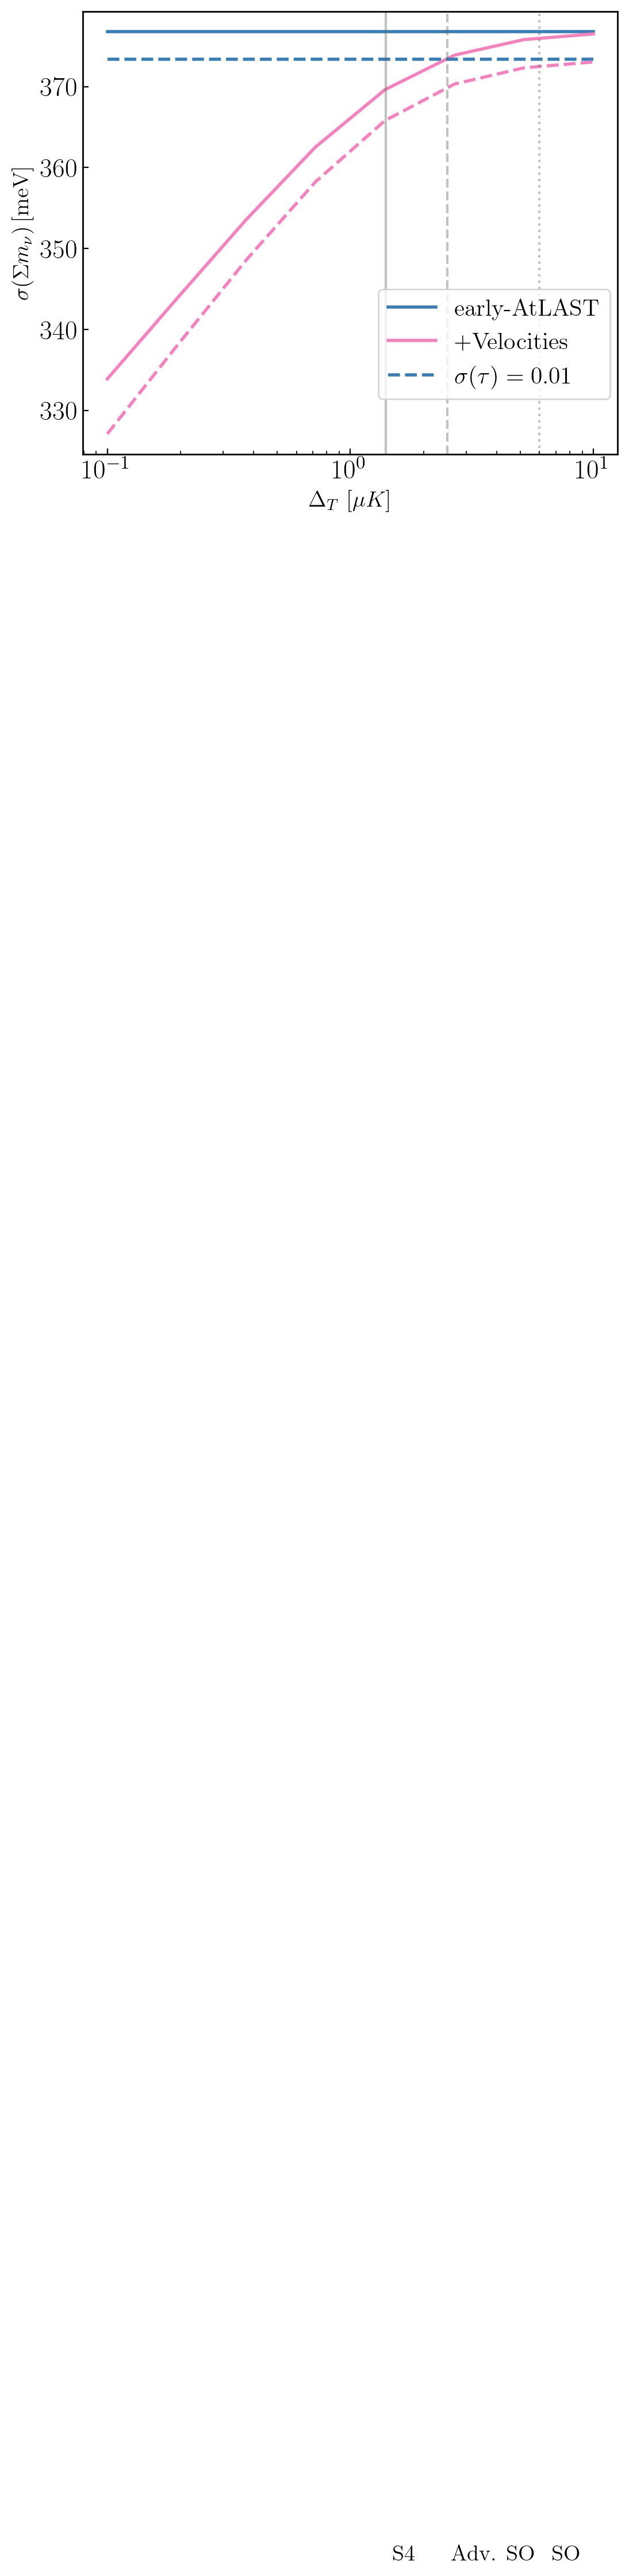

In [349]:
Delta_Ts = np.logspace(-1,1, 8)

sig_mnu_DT = np.zeros(len(Delta_Ts))
sig_mnu_lim_DT = np.zeros(len(Delta_Ts))
sig_mnu_lim_vel_DT = np.zeros(len(Delta_Ts))
sig_mnu_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_lim_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_lim_vel_DT_pr = np.zeros(len(Delta_Ts))

for t in range(len(Delta_Ts)):
                
    F_vX = F_vX_ear_t[t]
    F_XX = F_XX_ear_t[t]
    
    covmat_lim, cov_params = covariance_mat(F_XX, cov_params2, fixed_params, {})
    sig_mnu_lim_DT[t] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_vel, cov_params = covariance_mat(F_vX, cov_params3, [], {})
    sig_mnu_lim_vel_DT[t] = np.sqrt(covmat_lim_vel[mnu_ind,mnu_ind])
    
    covmat_lim, cov_params = covariance_mat(F_XX, cov_params2, fixed_params, {'tau':0.01})
    sig_mnu_lim_DT_pr[t] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_vel, cov_params = covariance_mat(F_vX, cov_params3, [], {'tau':0.01})
    sig_mnu_lim_vel_DT_pr[t] = np.sqrt(covmat_lim_vel[mnu_ind,mnu_ind])

    

plt.plot(Delta_Ts, sig_mnu_lim_DT*1e3, label='early-AtLAST', color=palette[5])
plt.plot(Delta_Ts, sig_mnu_lim_vel_DT*1e3, label='+Velocities', color=palette[8])
plt.plot(Delta_Ts, sig_mnu_lim_DT_pr*1e3, label=r'$\sigma(\tau)=0.01$', color=palette[5], ls='--')
plt.plot(Delta_Ts, sig_mnu_lim_vel_DT_pr*1e3, color=palette[8], ls='--')
plt.axvline(x = 1.4, color = palette[4], alpha=0.4, lw=1.5)
plt.axvline(x = 2.5, color = palette[4], alpha=0.4, ls='--', lw=1.5)
plt.axvline(x = 6., color = palette[4], alpha=0.4, ls=':', lw=1.5)
plt.text(1.5, 63.9, 'S4', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(2.6, 63.9, 'Adv. SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(6.8, 63.9, 'SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.xscale('log')
plt.legend(loc='upper left', fontsize=15, bbox_to_anchor=(0.53,0.4))
plt.xlabel(r'$\Delta_T \,\, [\mu K]$')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[meV]}$')



Text(0, 0.5, '$\\sigma(\\Sigma m_\\nu) \\, \\textrm{[meV]}$')

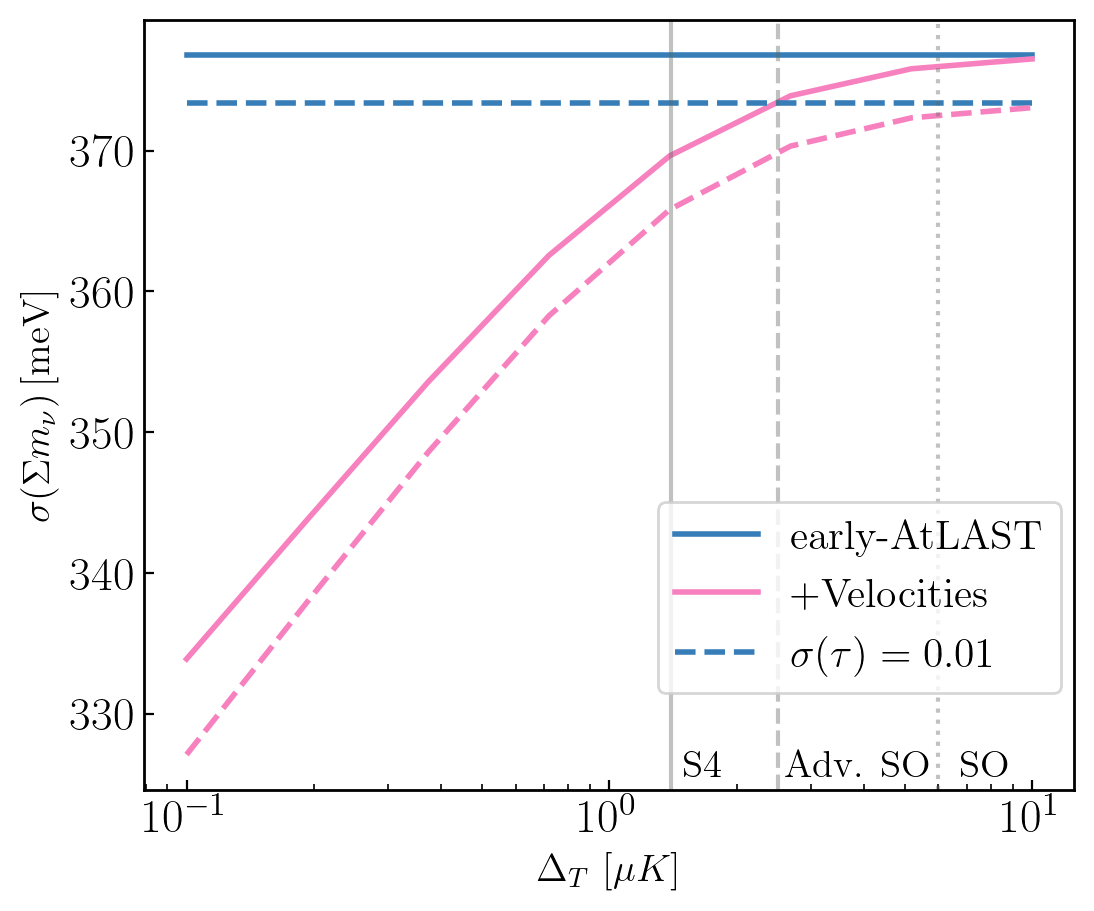

In [406]:
Delta_Ts = np.logspace(-1,1, 8)

sig_mnu_DT = np.zeros(len(Delta_Ts))
sig_mnu_lim_DT = np.zeros(len(Delta_Ts))
sig_mnu_lim_vel_DT = np.zeros(len(Delta_Ts))
sig_mnu_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_lim_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_lim_vel_DT_pr = np.zeros(len(Delta_Ts))

for t in range(len(Delta_Ts)):
                
    F_vX = F_vX_ear_t[t]
    F_XX = F_XX_ear_t[t]
    
    covmat_lim, cov_params = covariance_mat(F_XX, cov_params2, fixed_params, {})
    sig_mnu_lim_DT[t] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_vel, cov_params = covariance_mat(F_vX, cov_params3, [], {})
    sig_mnu_lim_vel_DT[t] = np.sqrt(covmat_lim_vel[mnu_ind,mnu_ind])
    
    covmat_lim, cov_params = covariance_mat(F_XX, cov_params2, fixed_params, {'tau':0.01})
    sig_mnu_lim_DT_pr[t] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_vel, cov_params = covariance_mat(F_vX, cov_params3, [], {'tau':0.01})
    sig_mnu_lim_vel_DT_pr[t] = np.sqrt(covmat_lim_vel[mnu_ind,mnu_ind])

    

plt.plot(Delta_Ts, sig_mnu_lim_DT*1e3, label='early-AtLAST', color=palette[5])
plt.plot(Delta_Ts, sig_mnu_lim_vel_DT*1e3, label='+Velocities', color=palette[8])
plt.plot(Delta_Ts, sig_mnu_lim_DT_pr*1e3, label=r'$\sigma(\tau)=0.01$', color=palette[5], ls='--')
plt.plot(Delta_Ts, sig_mnu_lim_vel_DT_pr*1e3, color=palette[8], ls='--')
plt.axvline(x = 1.4, color = palette[4], alpha=0.4, lw=1.5)
plt.axvline(x = 2.5, color = palette[4], alpha=0.4, ls='--', lw=1.5)
plt.axvline(x = 6., color = palette[4], alpha=0.4, ls=':', lw=1.5)
plt.text(1.5, 325, 'S4', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(2.6, 325, 'Adv. SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(6.8, 325, 'SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.xscale('log')
plt.legend(loc='upper left', fontsize=15, bbox_to_anchor=(0.53,0.4))
plt.xlabel(r'$\Delta_T \,\, [\mu K]$')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[meV]}$')



Text(0.5, 1.0, 'low $z$ plot')

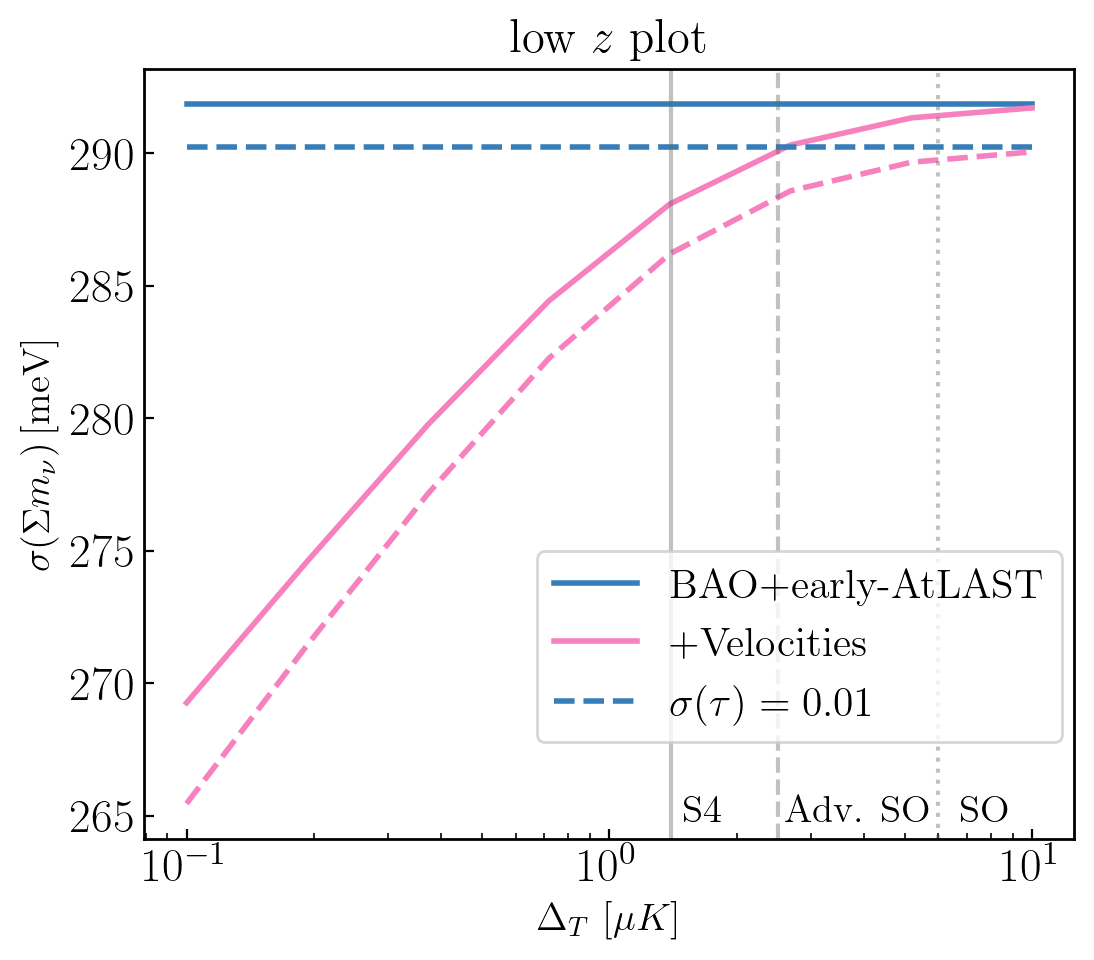

In [402]:
Delta_Ts = np.logspace(-1,1, 8)

sig_mnu_DT = np.zeros(len(Delta_Ts))
sig_mnu_lim_DT = np.zeros(len(Delta_Ts))
sig_mnu_lim_vel_DT = np.zeros(len(Delta_Ts))
sig_mnu_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_lim_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_lim_vel_DT_pr = np.zeros(len(Delta_Ts))

for t in range(len(Delta_Ts)):
                
    F_vX = F_vX_ear_t[t]
    F_XX = F_XX_ear_t[t]
    
    F_bao_L1 = np.zeros((len(F_XX), len(F_XX)))
    F_bao_L1[:7,:7] = F_bao
    F_bao_L2 = np.zeros((len(F_vX), len(F_vX)))
    F_bao_L2[:7,:7] = F_bao
    
    covmat_lim, cov_params = covariance_mat(F_bao_L1+F_XX, cov_params2, fixed_params, {})
    sig_mnu_lim_DT[t] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_vel, cov_params = covariance_mat(F_bao_L2+F_vX, cov_params3, [], {})
    sig_mnu_lim_vel_DT[t] = np.sqrt(covmat_lim_vel[mnu_ind,mnu_ind])
    
    covmat_lim, cov_params = covariance_mat(F_bao_L1+F_XX, cov_params2, fixed_params, {'tau':0.005})
    sig_mnu_lim_DT_pr[t] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_vel, cov_params = covariance_mat(F_bao_L2+F_vX, cov_params3, [], {'tau':0.005})
    sig_mnu_lim_vel_DT_pr[t] = np.sqrt(covmat_lim_vel[mnu_ind,mnu_ind])

    
plt.plot(Delta_Ts, sig_mnu_lim_DT*1e3, label='BAO+early-AtLAST', color=palette[5])
plt.plot(Delta_Ts, sig_mnu_lim_vel_DT*1e3, label='+Velocities', color=palette[8])
plt.plot(Delta_Ts, sig_mnu_lim_DT_pr*1e3, label=r'$\sigma(\tau)=0.01$', color=palette[5], ls='--')
plt.plot(Delta_Ts, sig_mnu_lim_vel_DT_pr*1e3, color=palette[8], ls='--')
plt.axvline(x = 1.4, color = palette[4], alpha=0.4, lw=1.5)
plt.axvline(x = 2.5, color = palette[4], alpha=0.4, ls='--', lw=1.5)
plt.axvline(x = 6., color = palette[4], alpha=0.4, ls=':', lw=1.5)
plt.text(1.5, 264.5, 'S4', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(2.6, 264.5, 'Adv. SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(6.8, 264.5, 'SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.xscale('log')
plt.legend(loc='upper left', fontsize=15, bbox_to_anchor=(0.4,0.4))
plt.xlabel(r'$\Delta_T \,\, [\mu K]$')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[meV]}$')
plt.title(r'low $z$ plot')



Text(0.5, 1.0, 'high+low $z$ plot')

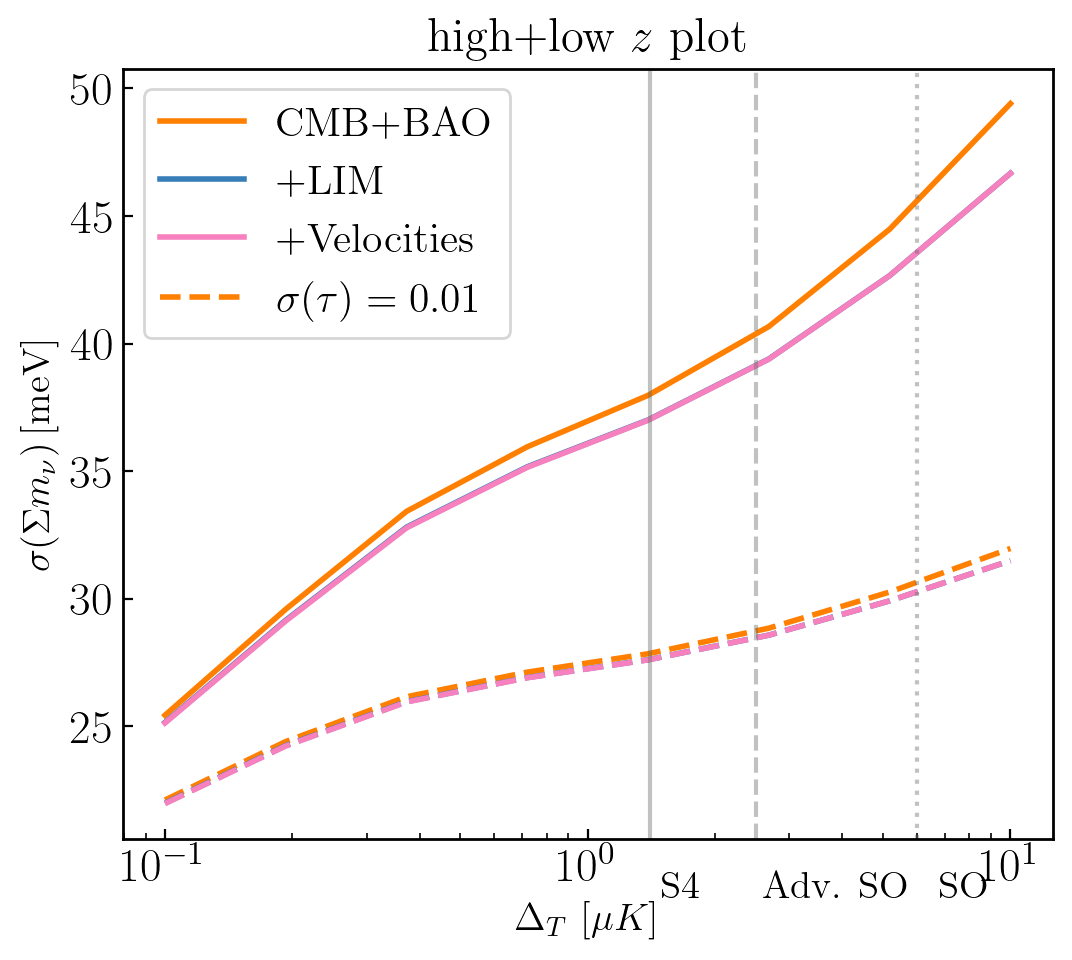

In [355]:
sig_mnu_DT = np.zeros(len(Delta_Ts))
sig_mnu_lim_DT = np.zeros(len(Delta_Ts))
sig_mnu_lim_vel_DT = np.zeros(len(Delta_Ts))
sig_mnu_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_lim_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_lim_vel_DT_pr = np.zeros(len(Delta_Ts))

for t in range(len(Delta_Ts)):
                
    F_vX = F_vX_ear_t[t]
    F_XX = F_XX_ear_t[t]
    
    F_CMB_L1 = np.zeros((len(F_XX), len(F_XX)))
    F_CMB_L2 = np.zeros((len(F_vX), len(F_vX)))
    #F_S4_t = data['fisherNonGaussian_delensed'][t]*fsky
    F_S4_t = F_CMB_DT['fisherGaussian'][t]['lensed']*fsky
    F_S4_t = np.delete(F_S4_t, -1, axis=0)
    F_S4_t = np.delete(F_S4_t, -1, axis=1)
    F_CMB_L1[:7,:7] = F_S4_t
    F_CMB_L2[:7,:7] = F_S4_t
    F_bao_L1 = np.zeros((len(F_XX), len(F_XX)))
    F_bao_L2 = np.zeros((len(F_vX), len(F_vX)))
    F_bao_L1[:7,:7] = F_bao
    F_bao_L2[:7,:7] = F_bao
    F_planck_lowell_L1 = np.zeros((len(F_XX), len(F_XX)))
    F_planck_lowell_L2 = np.zeros((len(F_vX), len(F_vX)))
    F_planck_lowell_L1[:7,:7] = F_planck_lowell
    F_planck_lowell_L2[:7,:7] = F_planck_lowell
    F_bao_CMB_DT1 = F_CMB_L1 + F_bao_L1 + F_planck_lowell_L1
    F_bao_CMB_DT2 = F_CMB_L2 + F_bao_L2 + F_planck_lowell_L2
    cov, covp = covariance_mat(F_bao_CMB_DT1, cov_params2, [], {})
    sig_mnu_DT[t] = np.sqrt(cov[mnu_ind,mnu_ind])
    cov, covp = covariance_mat(F_bao_CMB_DT1, cov_params2, [], {'tau':0.01})
    sig_mnu_DT_pr[t] = np.sqrt(cov[mnu_ind,mnu_ind])
    
    covmat_lim, cov_params = covariance_mat(F_bao_CMB_DT1+F_XX, cov_params2, fixed_params, {})
    sig_mnu_lim_DT[t] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_vel, cov_params = covariance_mat(F_bao_CMB_DT2+F_vX, cov_params3, [], {})
    sig_mnu_lim_vel_DT[t] = np.sqrt(covmat_lim_vel[mnu_ind,mnu_ind])
    
    covmat_lim, cov_params = covariance_mat(F_bao_CMB_DT1+F_XX, cov_params2, fixed_params, {'tau':0.01})
    sig_mnu_lim_DT_pr[t] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_vel, cov_params = covariance_mat(F_bao_CMB_DT2+F_vX, cov_params3, [], {'tau':0.01})
    sig_mnu_lim_vel_DT_pr[t] = np.sqrt(covmat_lim_vel[mnu_ind,mnu_ind])

    
#plt.figure(figsize=(11,6))


plt.plot(Delta_Ts, sig_mnu_DT*1e3, label='CMB+BAO', color=palette[6])
plt.plot(Delta_Ts, sig_mnu_lim_DT*1e3, label='+LIM', color=palette[5])
plt.plot(Delta_Ts, sig_mnu_lim_vel_DT*1e3, label='+Velocities', color=palette[8])
plt.plot(Delta_Ts, sig_mnu_DT_pr*1e3, label=r'$\sigma(\tau)=0.01$', color=palette[6], ls='--')
plt.plot(Delta_Ts, sig_mnu_lim_DT_pr*1e3, color=palette[5], ls='--')
plt.plot(Delta_Ts, sig_mnu_lim_vel_DT_pr*1e3, color=palette[8], ls='--')
plt.axvline(x = 1.4, color = palette[4], alpha=0.4, lw=1.5)
plt.axvline(x = 2.5, color = palette[4], alpha=0.4, ls='--', lw=1.5)
plt.axvline(x = 6., color = palette[4], alpha=0.4, ls=':', lw=1.5)
plt.text(1.5, 18, 'S4', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(2.6, 18, 'Adv. SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(6.8, 18, 'SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.xscale('log')
plt.legend(loc='upper left', fontsize=15)#, bbox_to_anchor=(0.52,0.4))
plt.xlabel(r'$\Delta_T \,\, [\mu K]$')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[meV]}$')
plt.title(r'high+low $z$ plot')
#plt.ylim(0.1,0.7)



Text(0.5, 1.0, 'high+low $z$ plot with $0.5\\%$ prior on $b_\\parallel$')

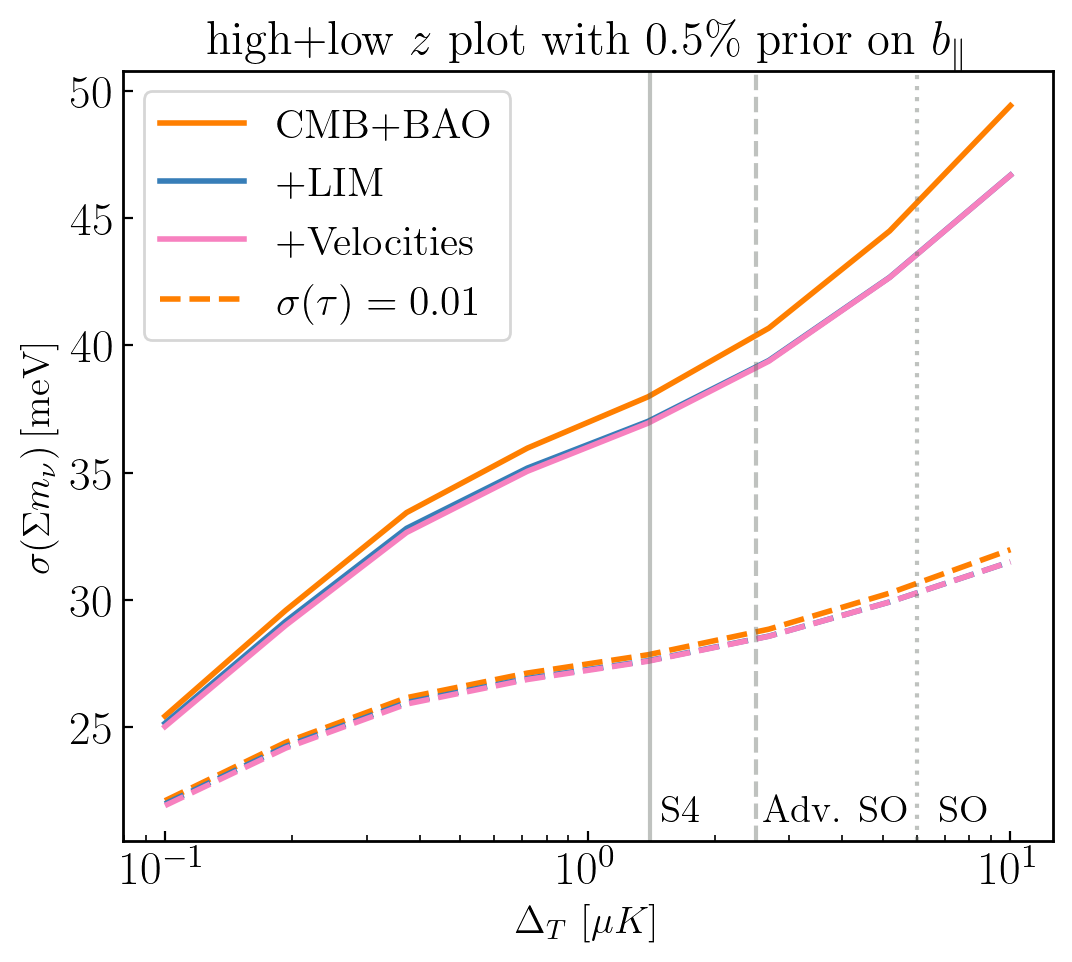

In [407]:
sig_mnu_DT = np.zeros(len(Delta_Ts))
sig_mnu_lim_DT = np.zeros(len(Delta_Ts))
sig_mnu_lim_vel_DT = np.zeros(len(Delta_Ts))
sig_mnu_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_lim_DT_pr = np.zeros(len(Delta_Ts))
sig_mnu_lim_vel_DT_pr = np.zeros(len(Delta_Ts))

for t in range(len(Delta_Ts)):
                
    F_vX = F_vX_ear_t[t]
    F_XX = F_XX_ear_t[t]
    
    F_CMB_L1 = np.zeros((len(F_XX), len(F_XX)))
    F_CMB_L2 = np.zeros((len(F_vX), len(F_vX)))
    #F_S4_t = data['fisherNonGaussian_delensed'][t]*fsky
    F_S4_t = F_CMB_DT['fisherGaussian'][t]['lensed']*fsky
    F_S4_t = np.delete(F_S4_t, -1, axis=0)
    F_S4_t = np.delete(F_S4_t, -1, axis=1)
    F_CMB_L1[:7,:7] = F_S4_t
    F_CMB_L2[:7,:7] = F_S4_t
    F_bao_L1 = np.zeros((len(F_XX), len(F_XX)))
    F_bao_L2 = np.zeros((len(F_vX), len(F_vX)))
    F_bao_L1[:7,:7] = F_bao
    F_bao_L2[:7,:7] = F_bao
    F_planck_lowell_L1 = np.zeros((len(F_XX), len(F_XX)))
    F_planck_lowell_L2 = np.zeros((len(F_vX), len(F_vX)))
    F_planck_lowell_L1[:7,:7] = F_planck_lowell
    F_planck_lowell_L2[:7,:7] = F_planck_lowell
    F_bao_CMB_DT1 = F_CMB_L1 + F_bao_L1 + F_planck_lowell_L1
    F_bao_CMB_DT2 = F_CMB_L2 + F_bao_L2 + F_planck_lowell_L2
    cov, covp = covariance_mat(F_bao_CMB_DT1, cov_params2, [], {})
    sig_mnu_DT[t] = np.sqrt(cov[mnu_ind,mnu_ind])
    cov, covp = covariance_mat(F_bao_CMB_DT1, cov_params2, [], {'tau':0.01})
    sig_mnu_DT_pr[t] = np.sqrt(cov[mnu_ind,mnu_ind])
    
    covmat_lim, cov_params = covariance_mat(F_bao_CMB_DT1+F_XX, cov_params2, fixed_params, {})
    sig_mnu_lim_DT[t] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_vel, cov_params = covariance_mat(F_bao_CMB_DT2+F_vX, cov_params3, [], {'bv_par':0.005})
    sig_mnu_lim_vel_DT[t] = np.sqrt(covmat_lim_vel[mnu_ind,mnu_ind])
    
    covmat_lim, cov_params = covariance_mat(F_bao_CMB_DT1+F_XX, cov_params2, fixed_params, {'tau':0.01})
    sig_mnu_lim_DT_pr[t] = np.sqrt(covmat_lim[mnu_ind,mnu_ind])
    covmat_lim_vel, cov_params = covariance_mat(F_bao_CMB_DT2+F_vX, cov_params3, [], {'tau':0.01, 'bv_par':0.005})
    sig_mnu_lim_vel_DT_pr[t] = np.sqrt(covmat_lim_vel[mnu_ind,mnu_ind])

    
#plt.figure(figsize=(11,6))


plt.plot(Delta_Ts, sig_mnu_DT*1e3, label='CMB+BAO', color=palette[6])
plt.plot(Delta_Ts, sig_mnu_lim_DT*1e3, label='+LIM', color=palette[5])
plt.plot(Delta_Ts, sig_mnu_lim_vel_DT*1e3, label='+Velocities', color=palette[8])
plt.plot(Delta_Ts, sig_mnu_DT_pr*1e3, label=r'$\sigma(\tau)=0.01$', color=palette[6], ls='--')
plt.plot(Delta_Ts, sig_mnu_lim_DT_pr*1e3, color=palette[5], ls='--')
plt.plot(Delta_Ts, sig_mnu_lim_vel_DT_pr*1e3, color=palette[8], ls='--')
plt.axvline(x = 1.4, color = palette[4], alpha=0.4, lw=1.5)
plt.axvline(x = 2.5, color = palette[4], alpha=0.4, ls='--', lw=1.5)
plt.axvline(x = 6., color = palette[4], alpha=0.4, ls=':', lw=1.5)
plt.text(1.5, 21, 'S4', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(2.6, 21, 'Adv. SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.text(6.8, 21, 'SO', fontsize=14, ha='left', va='bottom', color='black', alpha=1)
plt.xscale('log')
plt.legend(loc='upper left', fontsize=15)#, bbox_to_anchor=(0.52,0.4))
plt.xlabel(r'$\Delta_T \,\, [\mu K]$')
plt.ylabel(r'$\sigma(\Sigma m_\nu) \, \textrm{[meV]}$')
plt.title(r'high+low $z$ plot with $0.5\%$ prior on $b_\parallel$')
#plt.ylim(0.1,0.7)

